In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
df = pd.read_csv('unprocessed.csv',index_col=['Unnamed: 0'])
df.rename(columns={'nba_min':'nba_seconds'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 662482 entries, 0 to 662481
Data columns (total 58 columns):
nba_game_date            662482 non-null object
nba_season_id            662482 non-null int64
br_location              553928 non-null object
nba_gm_type              662482 non-null object
br_outcome               553928 non-null object
home_plus_minus          662482 non-null int64
nba_game_id              662482 non-null int64
nba_team_id              662482 non-null int64
nba_team_abbreviation    662482 non-null object
nba_team_city            662482 non-null object
nba_player_id            662482 non-null int64
nba_player_name          662482 non-null object
nba_start_position       269542 non-null object
nba_comment              107710 non-null object
nba_seconds              662482 non-null int64
nba_fgm                  554771 non-null float64
nba_fga                  554771 non-null float64
nba_fg_pct               554771 non-null float64
nba_fg3m                 554

### Potential issues : 
- non_null values not 554748 (basketball reference do not record platers who did not play)
- non_null values not 662459 (nba api full data)
- all others are either actual missing data or in the case of comment and start position mean something

### Fixing height:
- import from the basketball reference data to fill in values not in nba data

In [3]:
import psycopg2
import sqlalchemy

# on your computer you are the user postgres (full administrative access)
db_user = 'postgres'
# if you need a password to access a database, put it here
db_password = ''
# on your computer, use localhost
db_host = 'localhost'
# the default port for postgres is 5432
db_port = 5432
# we want to creat a database with the following name
database = 'final_db'
#set up a connection to postgres without specifying the database
# conn_postgres = f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}'

conn_str = f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{database}'
conn = psycopg2.connect(conn_str)

# connect using sqlalchemy
engine = sqlalchemy.engine.create_engine(conn_str)

# connect using sqlalchemy
connection = engine.connect()

# # commit
# connection.execute('commit')

# close connection
connection.close()

# open a new connection to the database that we created
database = 'final_db'
conn_str = f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{database}'
conn = psycopg2.connect(conn_str)

# connect using sqlalchemy
engine = sqlalchemy.engine.create_engine(conn_str)

query = """
select distinct(a.br_slug), b.br_height from brid_tra_box a
join
br_attrs_peryear b
on b.br_player = a.br_name"""

fix = pd.read_sql(query, con=conn)

In [4]:
# Create dictionary to replace values

fix.br_slug = fix.br_slug.astype(int)
height_fixer = fix.set_index('br_slug').to_dict()['br_height']

In [5]:
# Split data

no_height = df[df['nba_height'].isna()]
height = df[df['nba_height'].isna()==False]

In [6]:
no_height.nba_height = no_height.nba_player_id.map(height_fixer)

/Users/finnalexander/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [7]:
df = pd.concat([height, no_height])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 662482 entries, 0 to 657577
Data columns (total 58 columns):
nba_game_date            662482 non-null object
nba_season_id            662482 non-null int64
br_location              553928 non-null object
nba_gm_type              662482 non-null object
br_outcome               553928 non-null object
home_plus_minus          662482 non-null int64
nba_game_id              662482 non-null int64
nba_team_id              662482 non-null int64
nba_team_abbreviation    662482 non-null object
nba_team_city            662482 non-null object
nba_player_id            662482 non-null int64
nba_player_name          662482 non-null object
nba_start_position       269542 non-null object
nba_comment              107710 non-null object
nba_seconds              662482 non-null int64
nba_fgm                  554771 non-null float64
nba_fga                  554771 non-null float64
nba_fg_pct               554771 non-null float64
nba_fg3m                 554

In [9]:
# Convert ID values to categprical variables

for col in [col for col in df.columns if 'id' in col]:
    df[col] = df[col].astype('category', copy=False)

In [10]:
# First lets get rid of games where players did not play any game time

xf = df.copy()
xf.drop(xf[xf['nba_seconds']<.1].index, inplace=True)
xf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 554646 entries, 0 to 532590
Data columns (total 58 columns):
nba_game_date            554646 non-null object
nba_season_id            554646 non-null category
br_location              553766 non-null object
nba_gm_type              554646 non-null object
br_outcome               553766 non-null object
home_plus_minus          554646 non-null int64
nba_game_id              554646 non-null category
nba_team_id              554646 non-null category
nba_team_abbreviation    554646 non-null object
nba_team_city            554646 non-null object
nba_player_id            554646 non-null category
nba_player_name          554646 non-null object
nba_start_position       269542 non-null object
nba_comment              0 non-null object
nba_seconds              554646 non-null int64
nba_fgm                  554646 non-null float64
nba_fga                  554646 non-null float64
nba_fg_pct               554646 non-null float64
nba_fg3m             

#### Still need to look at:
- br_outcome, br_location, br_game_score
- nba_comment
- nba_start_position

In [11]:
xf.nba_game_date = pd.to_datetime(xf.nba_game_date)
no_br = xf[xf['br_outcome'].isna()]
br = xf[xf['br_outcome'].isna()==False]
br.isna().sum().sort_values().tail(5)

nba_dreb                   0
nba_reb                    0
nba_seconds                0
nba_start_position    284519
nba_comment           553766
dtype: int64

In [12]:
# Only thing left to check is the missing br_data in no_br
# then decide what to do with the nba_start_position & nba_comment

no_br.isna().sum().sort_values().tail(5)

nba_start_position    585
nba_comment           880
br_outcome            880
br_location           880
br_game_score         880
dtype: int64

In [14]:
# Checking to see how many observations and the players missing data
print('MORE THAN 300 SECONDS')
print(no_br[no_br['nba_seconds']>300].shape)
display(no_br[no_br['nba_seconds']>300][['nba_player_id','nba_player_name']].drop_duplicates())
print('ALL OBSERVATIONS')
print(no_br.shape)
display(no_br[['nba_player_id','nba_player_name']].drop_duplicates())

MORE THAN 300 SECONDS
(738, 58)


nba_player_id   nba_player_name
62               120      Steven Smith
77922           2055   Mamadou N'diaye
96063           2432       Tito Maddox
217164        200756  Hilton Armstrong
436025        203502     Tony Mitchell

ALL OBSERVATIONS
(880, 58)


nba_player_id   nba_player_name
62               120      Steven Smith
46427           2055   Mamadou N'diaye
95525           2432       Tito Maddox
104105           145      Tracy Murray
214710        200756  Hilton Armstrong
456455        203183     Tony Mitchell
433668        203502     Tony Mitchell

In [15]:
# Noticing some discrepencies in player ids
id_br_fix = list(no_br.nba_player_id.unique())
id_br_fix

[120, 2055, 2432, 145, 200756, 203183, 203502]

In [16]:
query = """
select br_slug, br_name, br_date, br_outcome, br_location, br_game_score 
from brid_tra_box
"""

fix2 = pd.read_sql(query, con=conn)
fix2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554665 entries, 0 to 554664
Data columns (total 6 columns):
br_slug          554665 non-null object
br_name          554665 non-null object
br_date          554665 non-null object
br_outcome       554665 non-null object
br_location      554665 non-null object
br_game_score    554665 non-null float64
dtypes: float64(1), object(5)
memory usage: 25.4+ MB


In [17]:
print(type(fix2.iloc[0,0]))
print(type(xf.loc[0,'nba_player_id']))

<class 'str'>
<class 'numpy.int64'>


In [18]:
fix2.br_slug = fix2.br_slug.astype(int)
fix2.br_slug = fix2.br_slug.astype('category', copy=False)
print(type(fix2.loc[0,'br_slug']))
print(type(xf.loc[0,'nba_player_id']))

<class 'numpy.int64'>
<class 'numpy.int64'>


In [19]:
no_br[no_br['nba_player_id']==id_br_fix[0]]

nba_game_date nba_season_id br_location nba_gm_type br_outcome  \
62        1999-11-02         21999         NaN     Regular        NaN   
416       1999-11-03         21999         NaN     Regular        NaN   
723       1999-11-05         21999         NaN     Regular        NaN   
1012      1999-11-06         21999         NaN     Regular        NaN   
1366      1999-11-09         21999         NaN     Regular        NaN   
...              ...           ...         ...         ...        ...   
180373    2005-04-19         22004         NaN     Regular        NaN   
180700    2005-04-20         22004         NaN     Regular        NaN   
181246    2005-04-28         42004         NaN    Playoffs        NaN   
182636    2005-06-04         42004         NaN    Playoffs        NaN   
182663    2005-06-06         42004         NaN    Playoffs        NaN   

        home_plus_minus nba_game_id nba_team_id nba_team_abbreviation  \
62                  -20    29900013  1610612757                   POR   
416                  23    29900019  1610612757                   POR   
723                  12    29900035  1610612757                   POR   
1012                 15    29900043  1610612757                   POR   
1366                  5    29900058  1610612757                   POR   
...                 ...         ...         ...                   ...   
180373               19    20401212  1610612748                   MIA   
180700               -5    20401221  1610612748                   MIA   
181246               -3    40400103  1610612748                   MIA   
182636               25    40400306  1610612748                   MIA   
182663               -6    40400307  1610612748                   MIA   

       nba_team_city  ... nba_tm_tov_pct nba_efg_pct nba_ts_pct nba_usg_pct  \
62          Portland  ...            5.9       0.731      0.745       0.242   
416         Portland  ...            0.0       0.750      0.814       0.197   
723         Portland  ...            5.0       0.643      0.661       0.254   
1012        Portland  ...           16.7       0.300      0.518       0.161   
1366        Portland  ...            4.5       0.464      0.618       0.289   
...              ...  ...            ...         ...        ...         ...   
180373         Miami  ...            0.0       0.143      0.134       0.175   
180700         Miami  ...            0.0       0.500      0.615       0.116   
181246         Miami  ...            0.0       0.000      0.000       0.000   
182636         Miami  ...            0.0       0.000      0.000       0.154   
182663         Miami  ...            0.0       0.000      0.000       0.000   

        nba_e_pace  nba_pace  nba_pace_per40  nba_poss  nba_pie  br_game_score  
62           94.42     91.57           76.31      57.0    0.275            NaN  
416          95.66     96.04           80.04      66.0    0.188            NaN  
723         100.31    100.14           83.45      61.0    0.197            NaN  
1012         92.77     91.83           76.53      53.0    0.056            NaN  
1366         87.34     84.71           70.59      66.0    0.102            NaN  
...            ...       ...             ...       ...      ...            ...  
180373       91.42     87.95           73.29      35.0    0.032            NaN  
180700      104.98     98.51           82.09      41.0    0.176            NaN  
181246     1206.86   1371.43         1142.86       2.0    0.000            NaN  
182636       80.85     92.58           77.15      13.0   -0.200            NaN  
182663      694.15    738.46          615.38       1.0    0.000            NaN  

[459 rows x 58 columns]

In [20]:
# Ids to check through fix2 : [120, 2055, 2432, 145, 200756, 203183, 203502]
# Some disagreements and a 3 players who need their further exploration
# need to change around player ids for the two tony mithcells
for i in range(len(id_br_fix)): print(id_br_fix[i],
                                      fix2[fix2['br_slug']==id_br_fix[i]].shape,
                                      no_br[no_br['nba_player_id']==id_br_fix[i]].shape,
                                      fix2[fix2['br_slug']==id_br_fix[i]]['br_name'].unique(),
                                      no_br[no_br['nba_player_id']==id_br_fix[i]]['nba_player_name'].unique())

120 (0, 6) (459, 58) [] ['Steven Smith']
2055 (0, 6) (69, 58) [] ["Mamadou N'diaye"]
2432 (0, 6) (9, 58) [] ['Tito Maddox']
145 (211, 6) (1, 58) ['Tracy Murray'] ['Tracy Murray']
200756 (0, 6) (318, 58) [] ['Hilton Armstrong']
203183 (21, 6) (3, 58) ['Tony Mitchell'] ['Tony Mitchell']
203502 (3, 6) (21, 58) ['Tony Mitchell'] ['Tony Mitchell']


In [21]:
# after some exploring through db following keys are wrong
id_replace = {120 : 200848, 2055 : 2050, 2432 : 2423,
              200756 : 200758, 2003183 : 203502, 203502 : 203183}
reversed_replace = {list(id_replace.values())[i] : list(id_replace.keys())[i] for i in range(len(id_replace))}

In [22]:
fix2.br_slug.map(reversed_replace).value_counts()

200756.0     868
2055.0       813
120.0        468
2432.0        81
203502.0      21
2003183.0      3
Name: br_slug, dtype: int64

In [23]:
fix3 = fix2[fix2['br_slug'].isin(id_replace.values())]
fix3.br_slug = fix3.br_slug.map(reversed_replace)

In [24]:
# New issues 'Morris Peterson', 'Chris Jeffries', 'Ronnie Brewer'
# Steven / Steve Smith likely same person
# Loose 3 games for one tony mitchell, 1 game tracy murray due to missing data
for i in range(len(id_br_fix)): print(id_br_fix[i],
                                      fix3[fix3['br_slug']==id_br_fix[i]].shape,
                                      no_br[no_br['nba_player_id']==id_br_fix[i]].shape,
                                      fix3[fix3['br_slug']==id_br_fix[i]]['br_name'].unique(),
                                      no_br[no_br['nba_player_id']==id_br_fix[i]]['nba_player_name'].unique())

120 (468, 6) (459, 58) ['Steve Smith' 'Steven Smith'] ['Steven Smith']
2055 (813, 6) (69, 58) ['Morris Peterson' "Mamadou N'Diaye"] ["Mamadou N'diaye"]
2432 (81, 6) (9, 58) ['Chris Jefferies' 'Tito Maddox'] ['Tito Maddox']
145 (0, 6) (1, 58) [] ['Tracy Murray']
200756 (868, 6) (318, 58) ['Ronnie Brewer' 'Hilton Armstrong'] ['Hilton Armstrong']
203183 (0, 6) (3, 58) [] ['Tony Mitchell']
203502 (21, 6) (21, 58) ['Tony Mitchell'] ['Tony Mitchell']


In [25]:
fix3 = fix3[fix3.br_name.isin(["Mamadou N'Diaye", 'Tito Maddox',
                        'Hilton Armstrong', 'Tony Mitchell',
                        'Steven Smith', 'Steve Smith'])]

In [26]:
for i in range(len(id_br_fix)): print(id_br_fix[i],
                                      fix3[fix3['br_slug']==id_br_fix[i]].shape,
                                      no_br[no_br['nba_player_id']==id_br_fix[i]].shape,
                                      fix3[fix3['br_slug']==id_br_fix[i]]['br_name'].unique(),
                                      no_br[no_br['nba_player_id']==id_br_fix[i]]['nba_player_name'].unique())

120 (468, 6) (459, 58) ['Steve Smith' 'Steven Smith'] ['Steven Smith']
2055 (69, 6) (69, 58) ["Mamadou N'Diaye"] ["Mamadou N'diaye"]
2432 (9, 6) (9, 58) ['Tito Maddox'] ['Tito Maddox']
145 (0, 6) (1, 58) [] ['Tracy Murray']
200756 (319, 6) (318, 58) ['Hilton Armstrong'] ['Hilton Armstrong']
203183 (0, 6) (3, 58) [] ['Tony Mitchell']
203502 (21, 6) (21, 58) ['Tony Mitchell'] ['Tony Mitchell']


In [27]:
# no_br.nba_game_date = pd.to_datetime(no_br.nba_game_date)
fix3.br_date = pd.to_datetime(fix3.br_date)
fixed_dfs = []

for i in id_br_fix:
    t = no_br[no_br['nba_player_id']==i].sort_values(by='nba_game_date')
    fixer = fix3[fix3['br_slug']==i]
    fixer = fixer[fixer['br_date'].isin(t.nba_game_date)]
    t.reset_index(inplace=True)
    fixer.reset_index(inplace=True)
    t.br_outcome = fixer.br_outcome
    t.br_location = fixer.br_location
    t.br_game_score = fixer.br_game_score
    fixed_dfs.append(t)
    
fixed_dfs = pd.concat(fixed_dfs)
fixed_dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 880 entries, 0 to 20
Data columns (total 59 columns):
index                    880 non-null int64
nba_game_date            880 non-null datetime64[ns]
nba_season_id            880 non-null category
br_location              876 non-null object
nba_gm_type              880 non-null object
br_outcome               876 non-null object
home_plus_minus          880 non-null int64
nba_game_id              880 non-null category
nba_team_id              880 non-null category
nba_team_abbreviation    880 non-null object
nba_team_city            880 non-null object
nba_player_id            880 non-null category
nba_player_name          880 non-null object
nba_start_position       295 non-null object
nba_comment              0 non-null object
nba_seconds              880 non-null int64
nba_fgm                  880 non-null float64
nba_fga                  880 non-null float64
nba_fg_pct               880 non-null float64
nba_fg3m                 88

In [28]:
fixed_dfs.drop(columns='index', inplace=True)

In [29]:
xf = pd.concat([br, fixed_dfs])
xf.reset_index(drop=True, inplace=True)
xf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554646 entries, 0 to 554645
Data columns (total 58 columns):
nba_game_date            554646 non-null datetime64[ns]
nba_season_id            554646 non-null category
br_location              554642 non-null object
nba_gm_type              554646 non-null object
br_outcome               554642 non-null object
home_plus_minus          554646 non-null int64
nba_game_id              554646 non-null category
nba_team_id              554646 non-null category
nba_team_abbreviation    554646 non-null object
nba_team_city            554646 non-null object
nba_player_id            554646 non-null category
nba_player_name          554646 non-null object
nba_start_position       269542 non-null object
nba_comment              0 non-null object
nba_seconds              554646 non-null int64
nba_fgm                  554646 non-null float64
nba_fga                  554646 non-null float64
nba_fg_pct               554646 non-null float64
nba_fg3m     

In [30]:
# The remining games missing data,
# all players played under 5 minutes 
# Unlikely to be an issue

xf[xf.br_location.isnull()][['nba_game_date',
                             'nba_player_name',
                             'nba_seconds',
                             'nba_team_abbreviation']]

nba_game_date nba_player_name  nba_seconds nba_team_abbreviation
554303    2003-01-20    Tracy Murray            2                   LAL
554622    2014-03-05   Tony Mitchell          207                   MIL
554623    2014-03-08   Tony Mitchell          272                   MIL
554624    2014-03-11   Tony Mitchell          106                   MIL

In [34]:
import requests as re
from bs4 import BeautifulSoup

In [36]:
# Tony Mitchell check of data
r = re.get(
    'https://www.basketball-reference.com/players/m/mitchto03/gamelog/2014')

soup = BeautifulSoup(r.text, 'html')

In [51]:
tony_mitchel_html = soup.find('table', attrs={'class':'row_summable'})

In [72]:
for i in range(6):
    try:
        d = tony_mitchel_html.find_all(attrs={'data-stat':'date_game'})[i].text
    except:
        print(f'{i}d error')
    try:
        r = tony_mitchel_html.find_all(attrs={'data-stat':'game_result'})[i].text
    except: print(f'{i}g error')
    
    print(d, r, s)

Date   3.4
2014-03-05 L (-14) 3.4
2014-03-07 L (-8) 3.4
2014-03-08 L (-7) 3.4
2014-03-10 W (+7) 3.4
2014-03-11 L (-11) 3.4


In [75]:
tm_gmsc = [i.text for i in \
           tony_mitchel_html.find_all(attrs={'data-stat':'game_score'})]
tm_dtgm = [i.text for i in \
           tony_mitchel_html.find_all(attrs={'data-stat':'date_game'})]
tm_outcome = [i.text for i in \
              tony_mitchel_html.find_all(attrs={'data-stat':'game_result'})]

In [77]:
xf.nba_game_date.dtype

dtype('<M8[ns]')

In [87]:
tm_wl = [int(i[3:-1]) for i in tm_outcome if i[3:-1]!='']
tm_wl

[-14, -8, -7, 7, -11, -5]

In [96]:
 index_tm = xf[(xf.br_location.isnull())&(xf.home_plus_minus.isin(tm_wl+[11]))].index

In [111]:
for i in index_tm:
    print(xf.loc[i,'br_game_score'], tm_gmsc[1:][list(index_tm).index(i)])
    xf.loc[i,'br_game_score'] = tm_gmsc[1:][list(index_tm).index(i)]

nan 1.7
nan 1.0
nan 3.4


In [115]:
xf[(xf.br_location.isnull())&(xf.home_plus_minus.isin(tm_wl+[11]))]

nba_game_date nba_season_id br_location nba_gm_type br_outcome  \
554622    2014-03-05         22013         NaN     Regular        NaN   
554623    2014-03-08         22013         NaN     Regular        NaN   
554624    2014-03-11         22013         NaN     Regular        NaN   

        home_plus_minus nba_game_id nba_team_id nba_team_abbreviation  \
554622              -14    21300910  1610612749                   MIL   
554623               -7    21300931  1610612749                   MIL   
554624               11    21300954  1610612749                   MIL   

       nba_team_city  ... nba_tm_tov_pct nba_efg_pct nba_ts_pct nba_usg_pct  \
554622     Milwaukee  ...            0.0         0.5        0.5       0.250   
554623     Milwaukee  ...            0.0         0.0        0.0       0.100   
554624     Milwaukee  ...            0.0         1.0        1.0       0.667   

        nba_e_pace  nba_pace  nba_pace_per40  nba_poss  nba_pie  br_game_score  
554622       75.69     83.48           69.57       6.0    0.120            1.7  
554623       91.69     90.00           75.00       9.0    0.049            1.0  
554624       79.88     95.09           79.25       3.0    0.571            3.4  

[3 rows x 58 columns]

In [117]:
for i in index_tm:
    print(xf.loc[i,'br_outcome'], xf.loc[i,'home_plus_minus']/np.abs(xf.loc[i,'home_plus_minus']))

nan -1.0
nan -1.0
nan 1.0


### Consideridering removing observations where players played a small amount of minutes

- lets do some statistical analysis

In [118]:
import scipy.stats as stats

In [119]:
def stats_testing_print(xf=xf, seconds=300):
    

    for col in [col for col in xf.columns if xf[col].dtypes==float]:
        s = xf[col]
        print(' COLUMN \t:\t',
              col, '\n', 'Ttest pvalue \t: \t',
             stats.ttest_ind(s[xf.nba_seconds<300],
                             s, equal_var=False).pvalue)
        print(f' Mean comp\t:\t{s[xf.nba_seconds<300].mean():.3f} \t\t {s.mean():.3f}')
        print(f' std comp\t:\t{s[xf.nba_seconds<300].std():.3f} \t\t {s.std():.3f}')
        print(f' Kurt comp\t:\t{s[xf.nba_seconds<300].kurt():.3f}\t\t {s.kurt():.3f}')
        print(f' Skew comp\t:\t{s[xf.nba_seconds<300].skew():.3f} \t\t {s.skew():.3f}')
        print('= '*40)

In [120]:
stats_testing_print()

 COLUMN 	:	 nba_fgm 
 Ttest pvalue 	: 	 0.0
 Mean comp	:	0.257 		 3.620
 std comp	:	0.524 		 3.063
 Kurt comp	:	5.015		 0.878
 Skew comp	:	2.156 		 0.993
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
 COLUMN 	:	 nba_fga 
 Ttest pvalue 	: 	 0.0
 Mean comp	:	0.777 		 8.002
 std comp	:	0.943 		 5.780
 Kurt comp	:	1.758		 0.561
 Skew comp	:	1.292 		 0.850
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
 COLUMN 	:	 nba_fg_pct 
 Ttest pvalue 	: 	 0.0
 Mean comp	:	0.167 		 0.414
 std comp	:	0.339 		 0.251
 Kurt comp	:	1.509		 -0.138
 Skew comp	:	1.775 		 0.096
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
 COLUMN 	:	 nba_fg3m 
 Ttest pvalue 	: 	 0.0
 Mean comp	:	0.043 		 0.695
 std comp	:	0.217 		 1.162
 Kurt comp	:	33.145		 5.419
 Skew comp	:	5.414 		 2.121
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
 COLUMN 	:	 nba_fg3a 
 Ttest pvalue 	: 	 0.0
 Mean com

 COLUMN 	:	 nba_usg_pct 
 Ttest pvalue 	: 	 1.171900849312987e-280
 Mean comp	:	0.154 		 0.185
 std comp	:	0.169 		 0.085
 Kurt comp	:	3.978		 5.451
 Skew comp	:	1.514 		 0.756
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
 COLUMN 	:	 nba_e_pace 
 Ttest pvalue 	: 	 4.760991595518763e-112
 Mean comp	:	109.835 		 96.679
 std comp	:	115.975 		 32.037
 Kurt comp	:	297.723		 3776.857
 Skew comp	:	13.446 		 46.913
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
 COLUMN 	:	 nba_pace 
 Ttest pvalue 	: 	 0.0
 Mean comp	:	129.332 		 97.934
 std comp	:	163.532 		 45.194
 Kurt comp	:	197.811		 2581.937
 Skew comp	:	12.006 		 42.776
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
 COLUMN 	:	 nba_pace_per40 
 Ttest pvalue 	: 	 0.0
 Mean comp	:	107.777 		 81.612
 std comp	:	136.276 		 37.662
 Kurt comp	:	197.811		 2581.940
 Skew comp	:	12.006 		 42.776
= = = = = = = = = = = = = = = = = = = = = = = = =

In [121]:
numerical_columns = [col for col in xf.columns if \
                     xf[col].dtype==float or int]

mset = xf[xf['nba_seconds']>300].copy()
sset = xf[xf['nba_seconds']<300].copy()

COLUMN : home_plus_minus 
 Main min -58.00	 Sub min -54.00 
 Main max 61.00	 Sub max 49.00


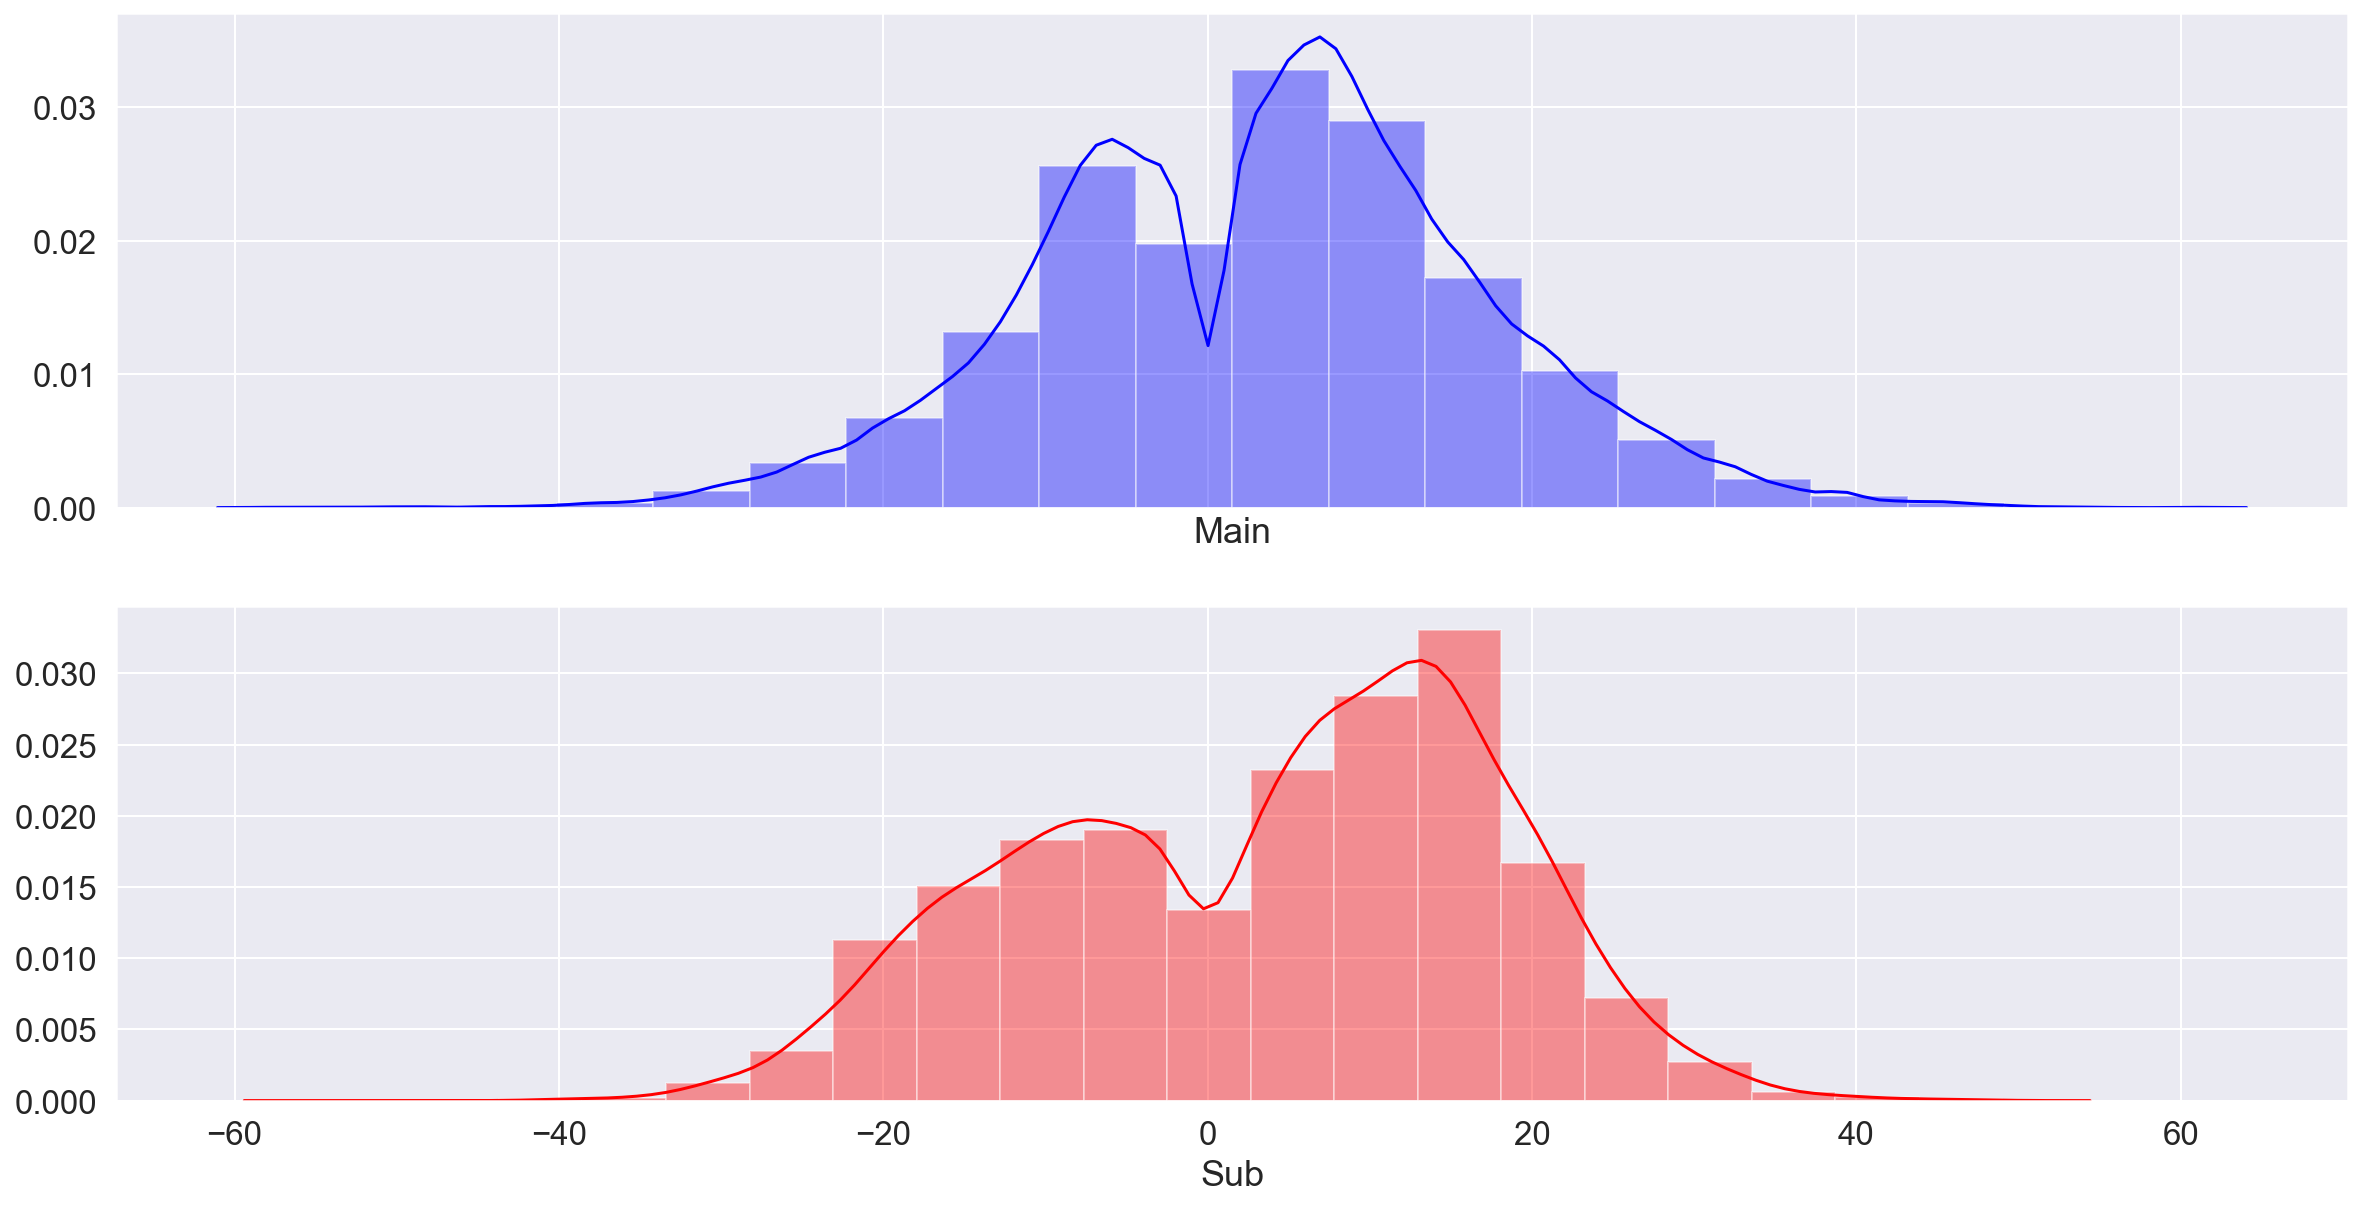

COLUMN : nba_seconds 
 Main min 301.00	 Sub min 1.00 
 Main max 3898.00	 Sub max 299.00


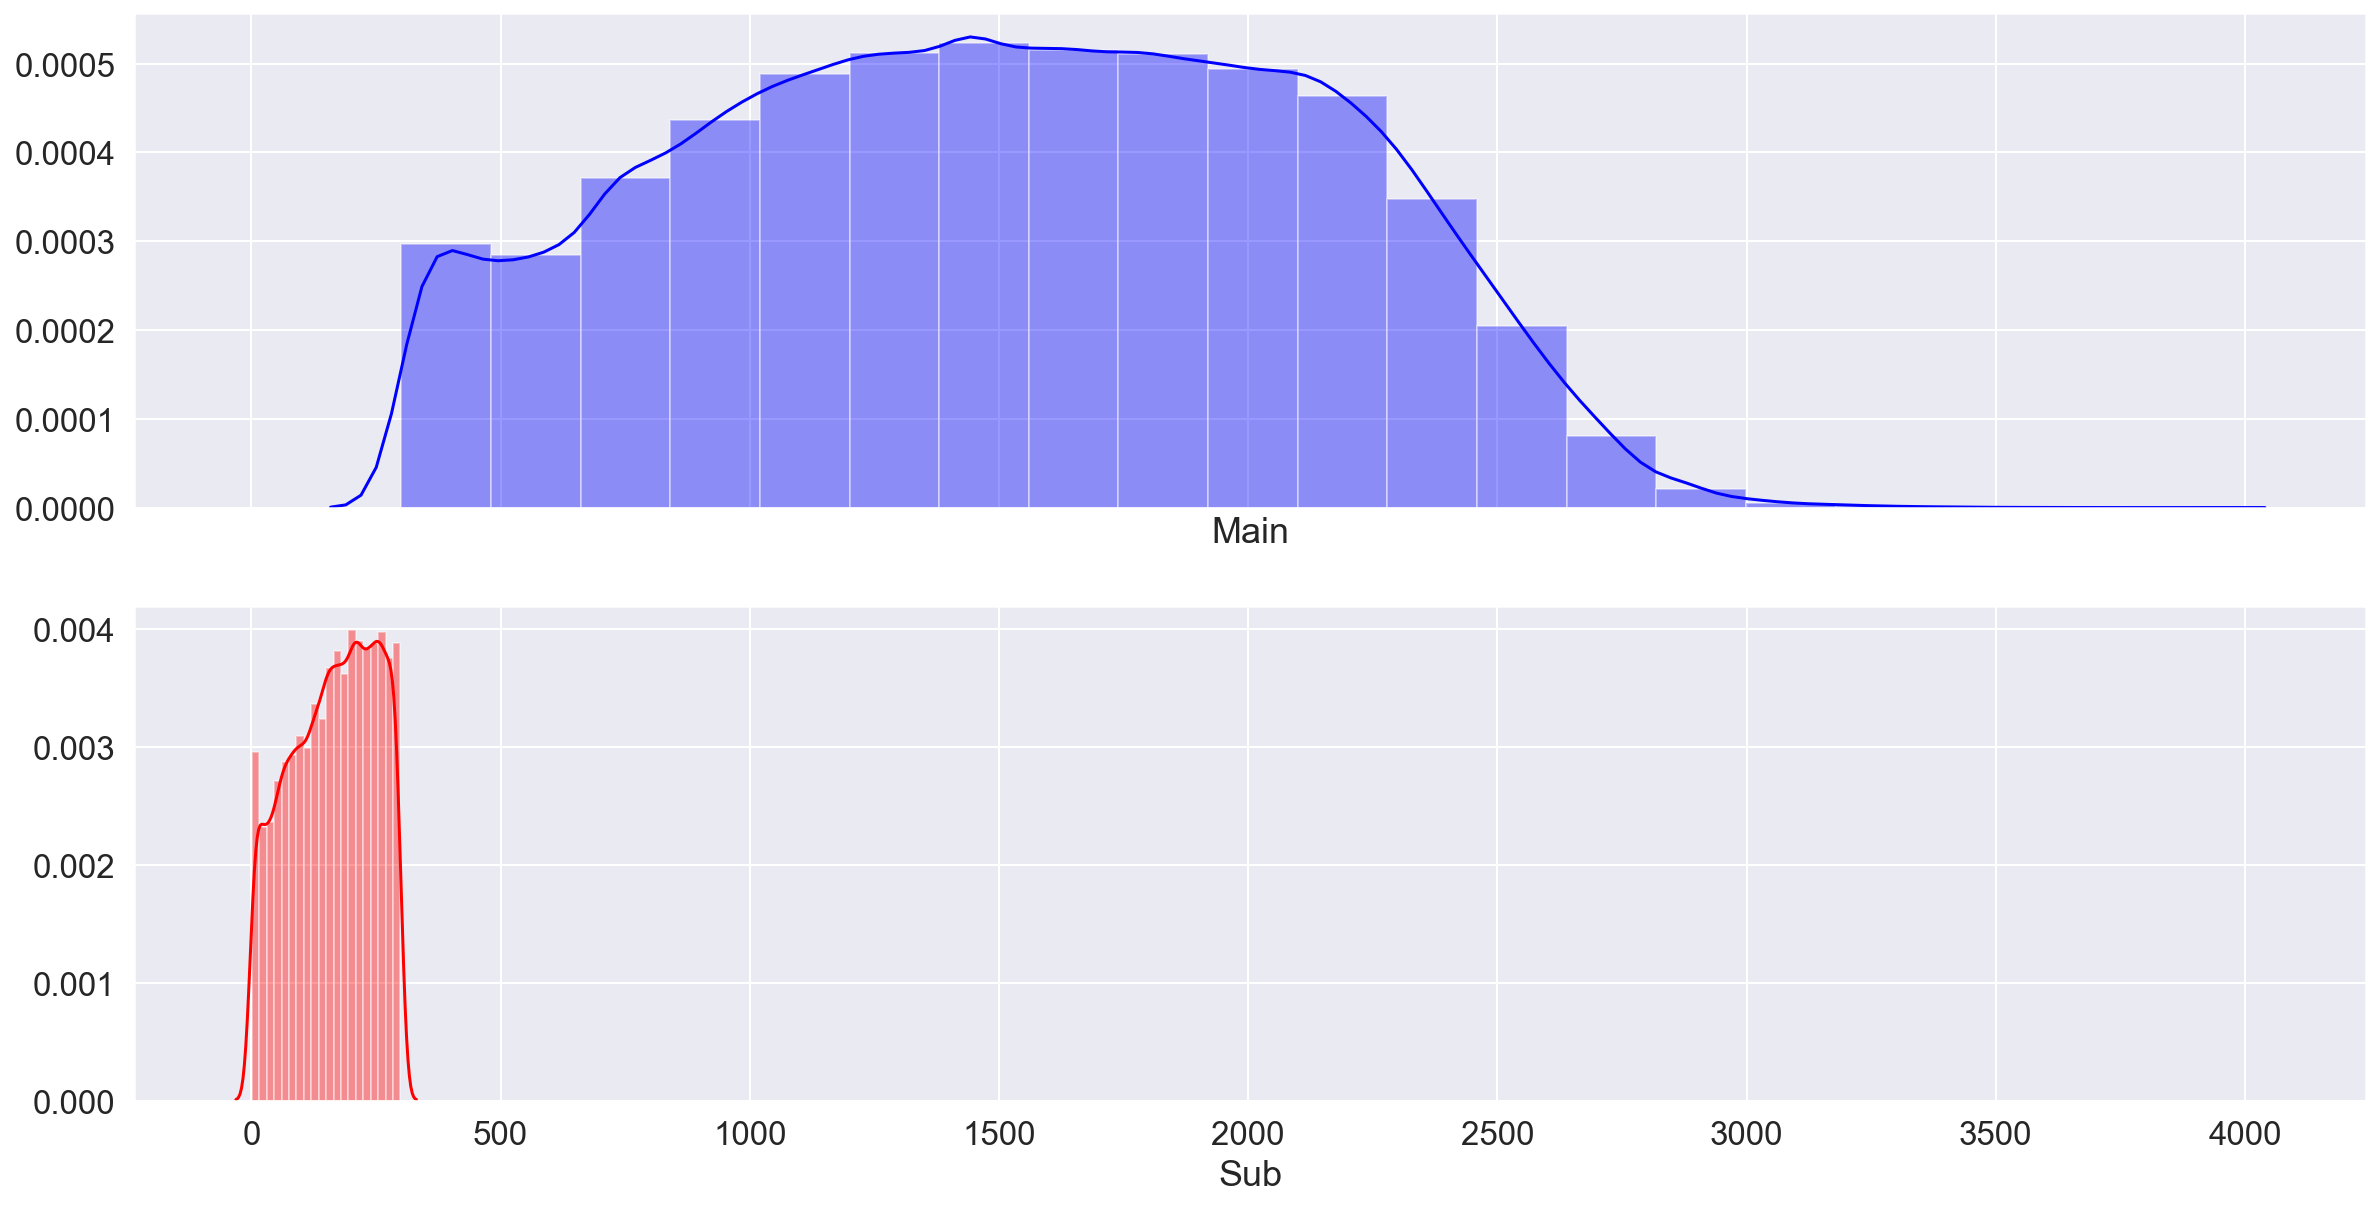

COLUMN : nba_fgm 
 Main min 0.00	 Sub min 0.00 
 Main max 28.00	 Sub max 4.00


/Users/finnalexander/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


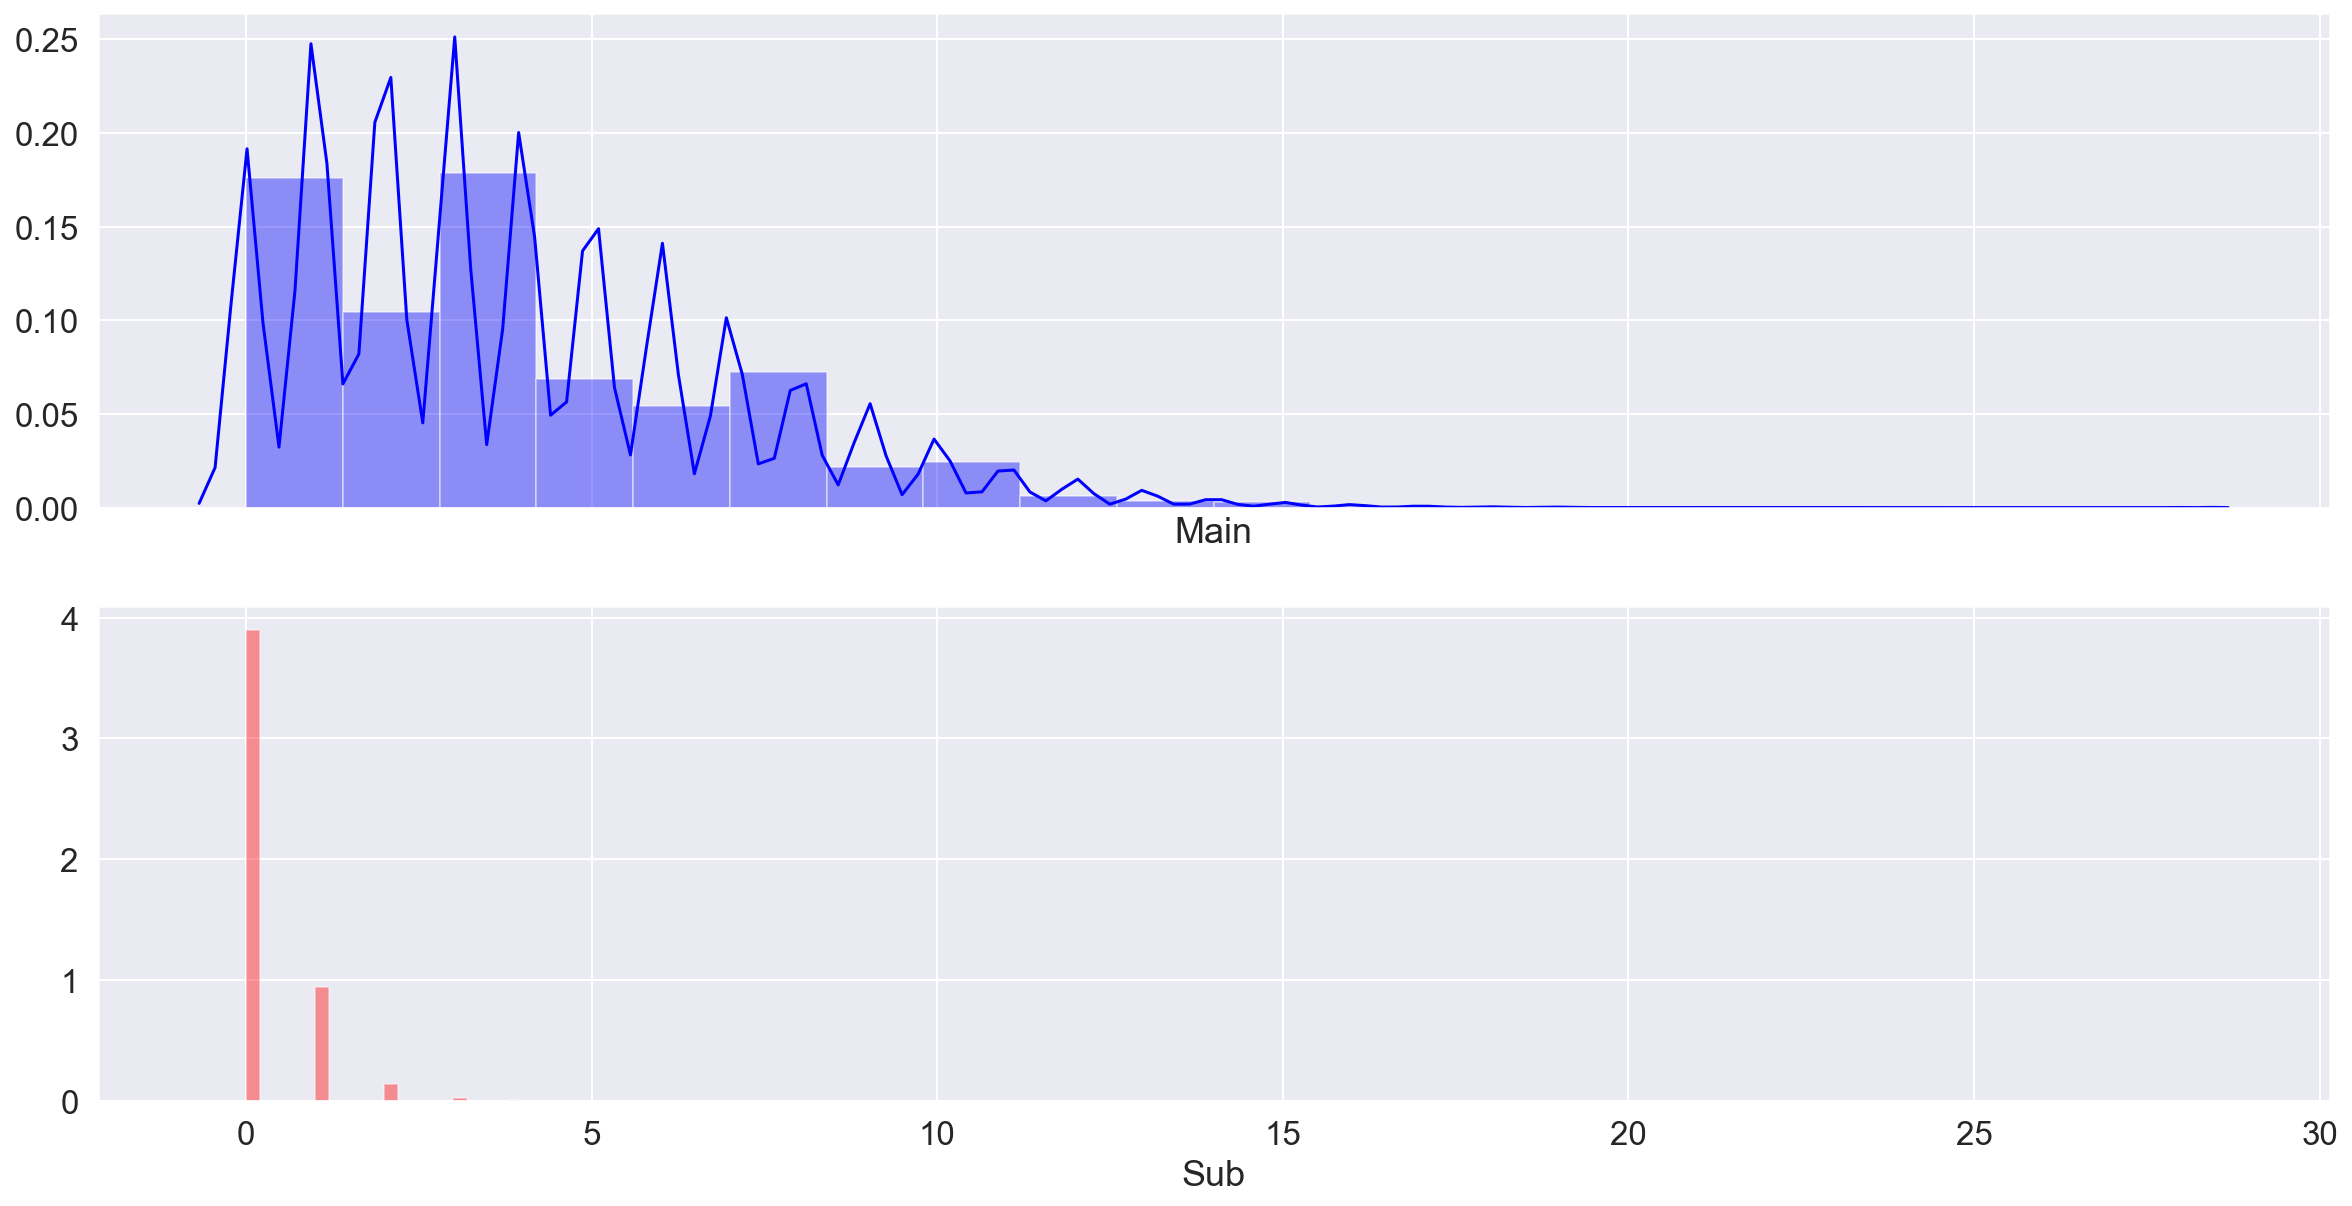

COLUMN : nba_fga 
 Main min 0.00	 Sub min 0.00 
 Main max 50.00	 Sub max 8.00


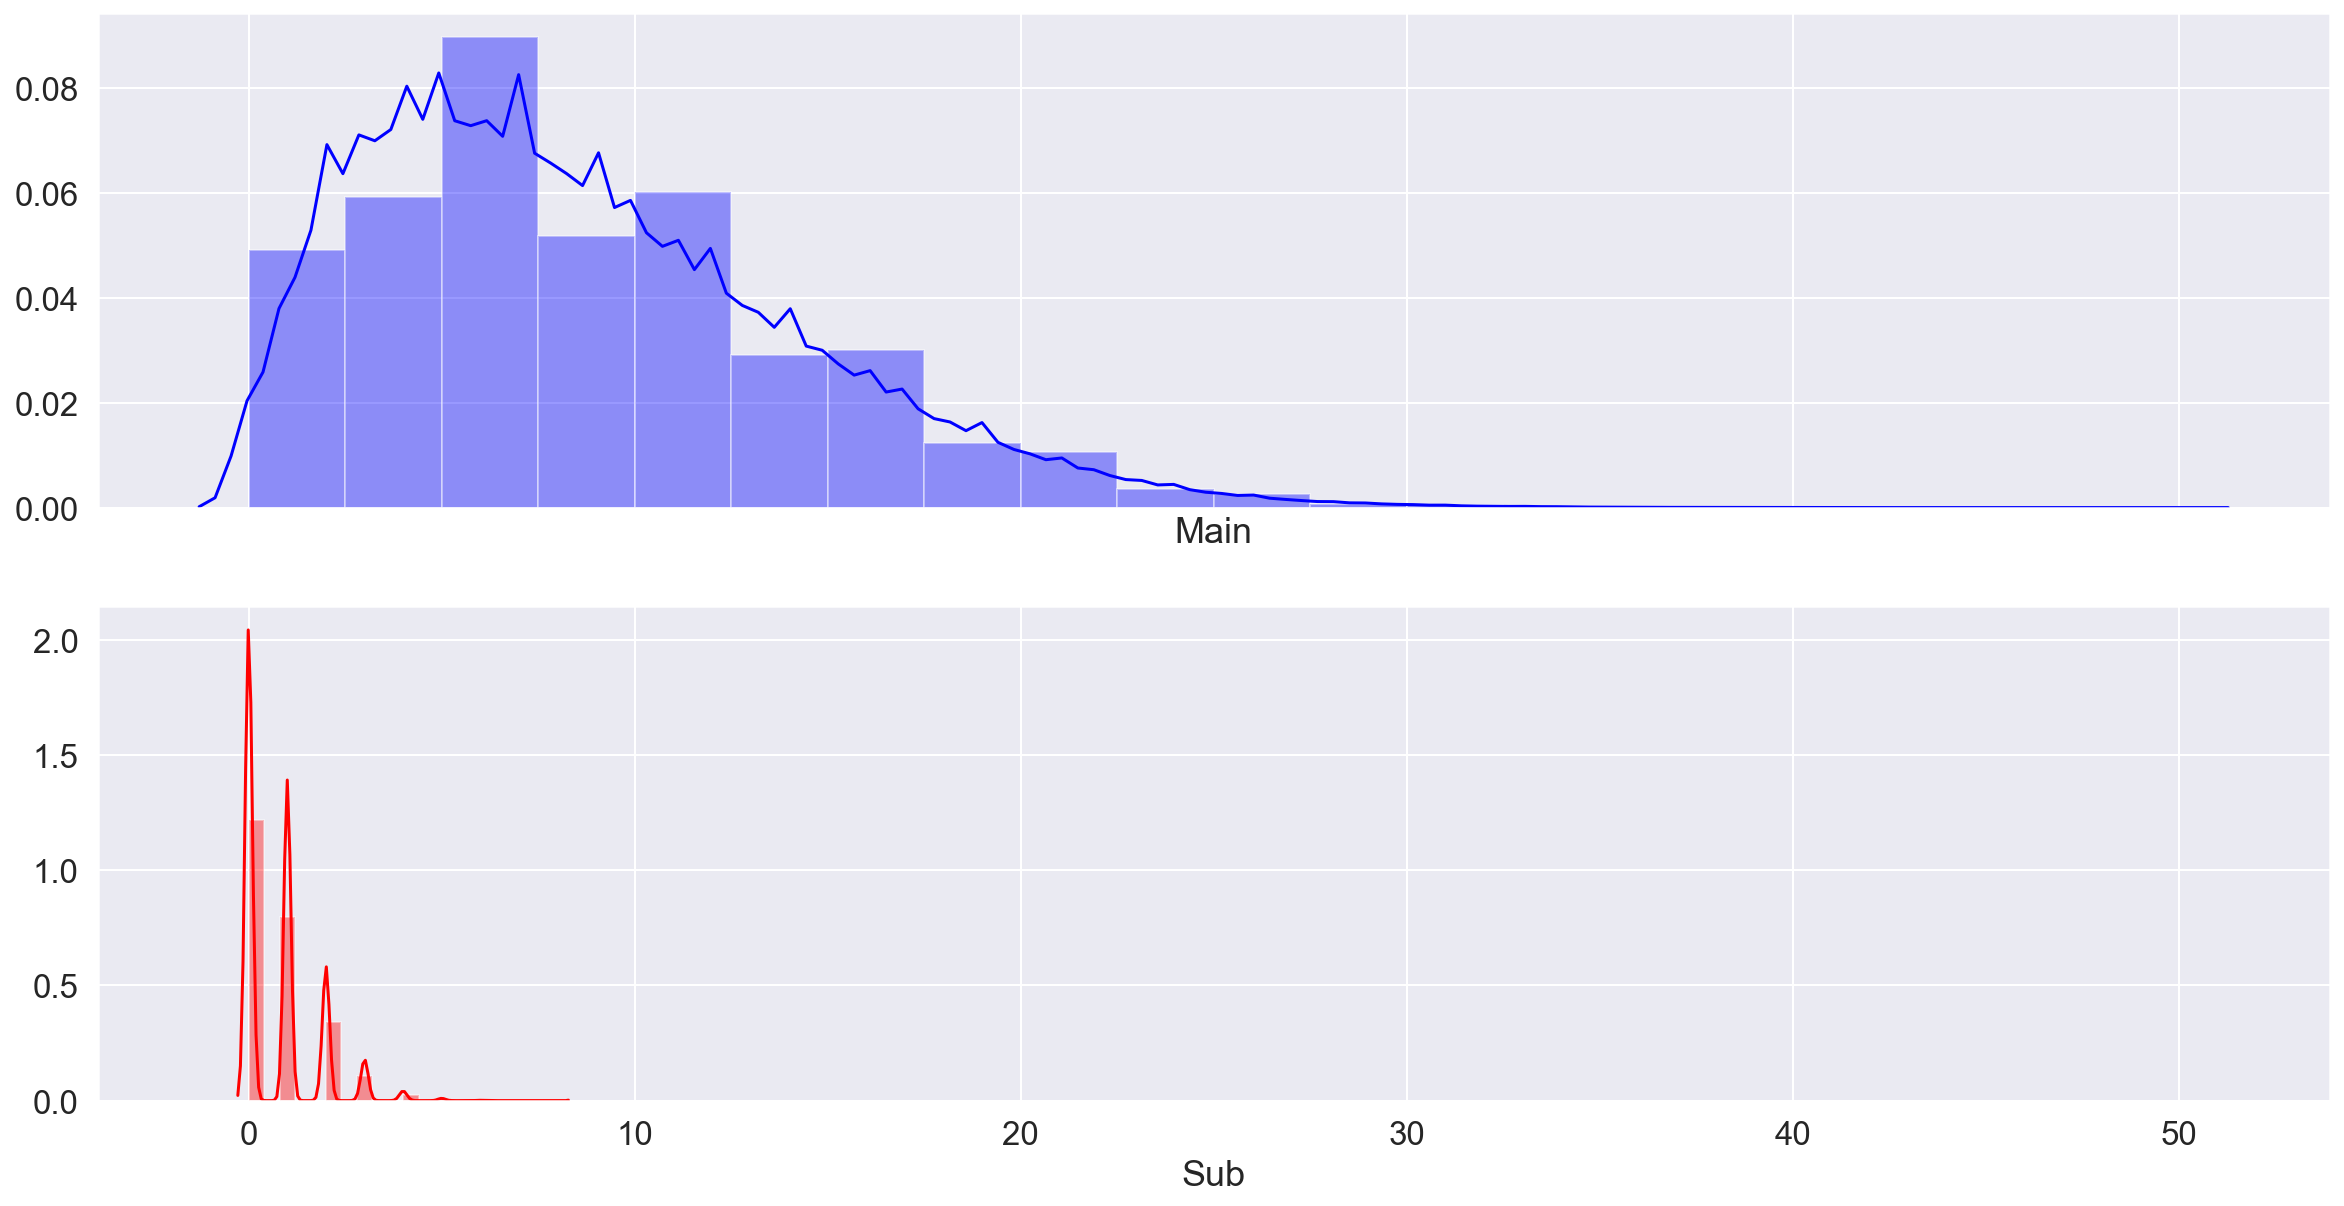

COLUMN : nba_fg_pct 
 Main min 0.00	 Sub min 0.00 
 Main max 1.00	 Sub max 1.00


/Users/finnalexander/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


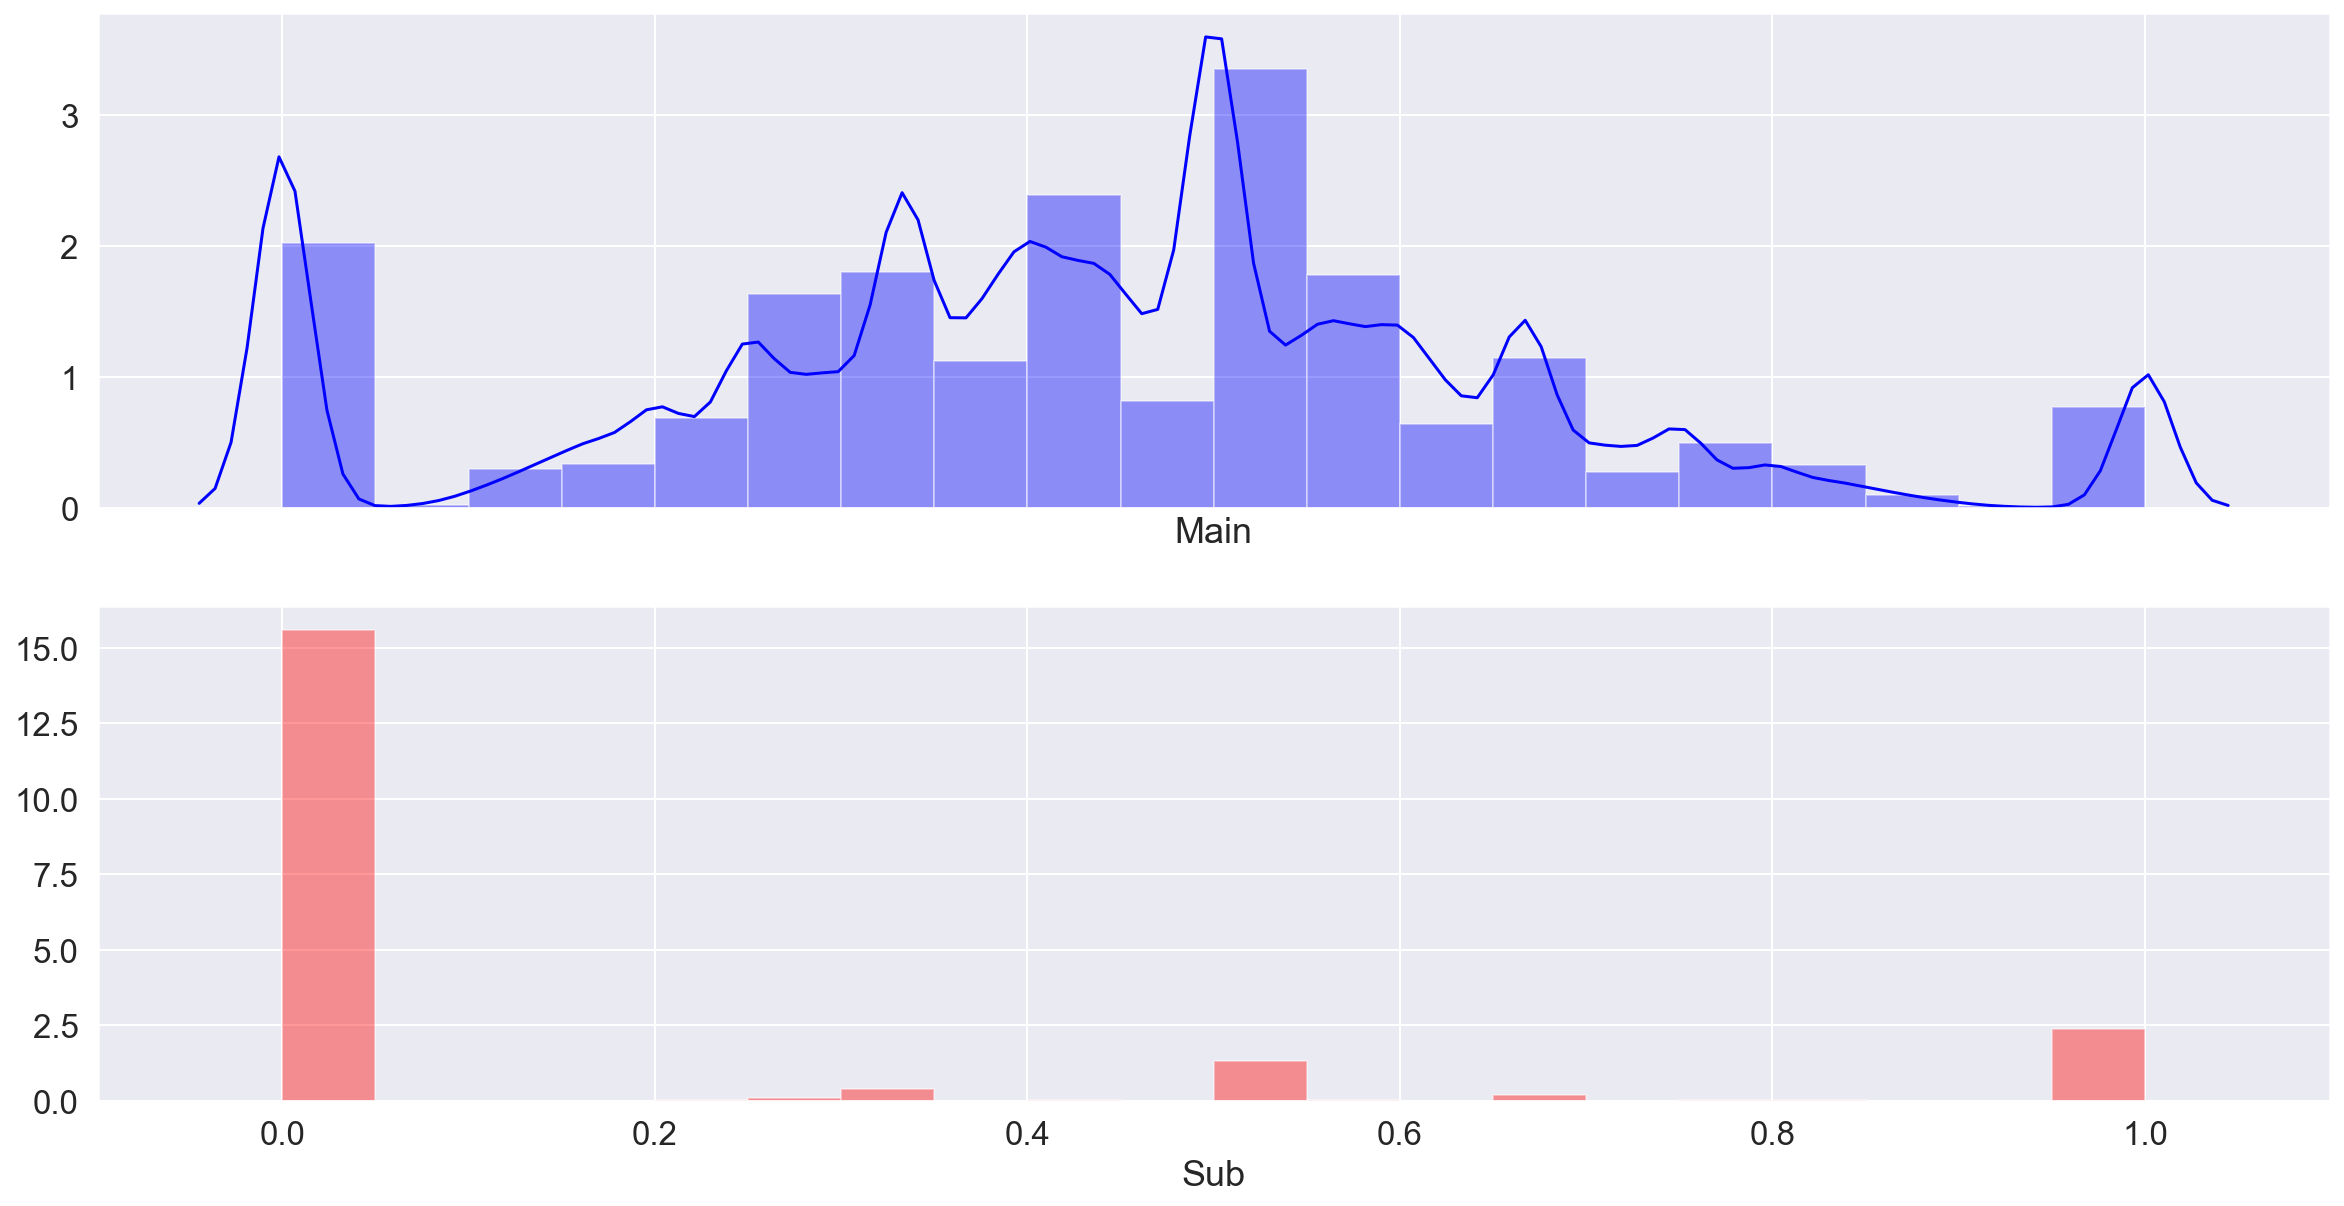

COLUMN : nba_fg3m 
 Main min 0.00	 Sub min 0.00 
 Main max 14.00	 Sub max 3.00


/Users/finnalexander/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


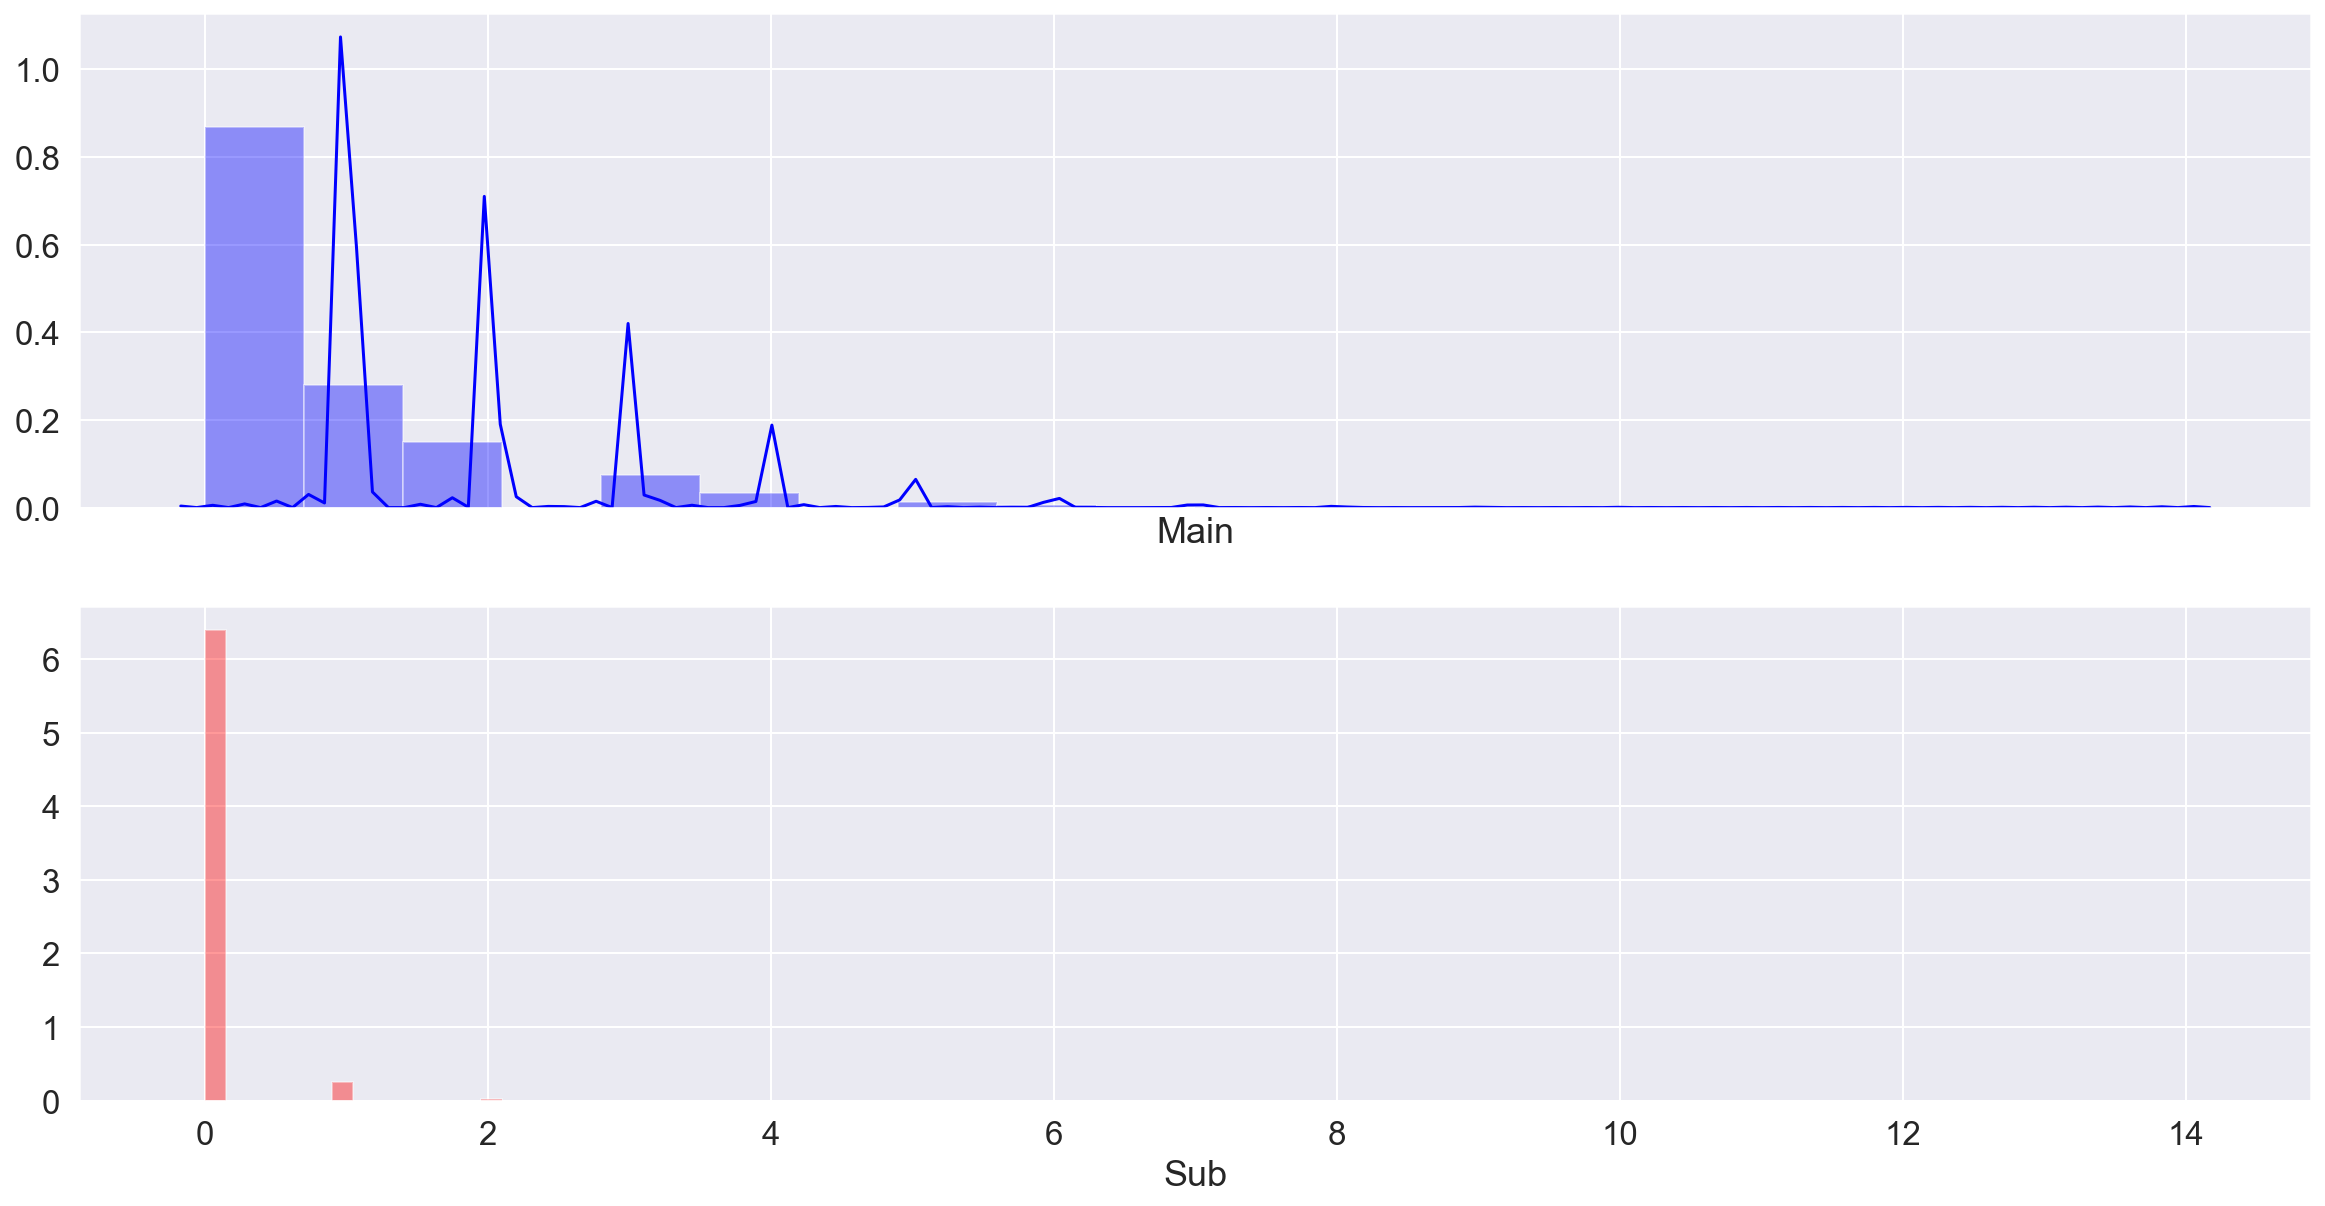

COLUMN : nba_fg3a 
 Main min 0.00	 Sub min 0.00 
 Main max 24.00	 Sub max 5.00


/Users/finnalexander/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


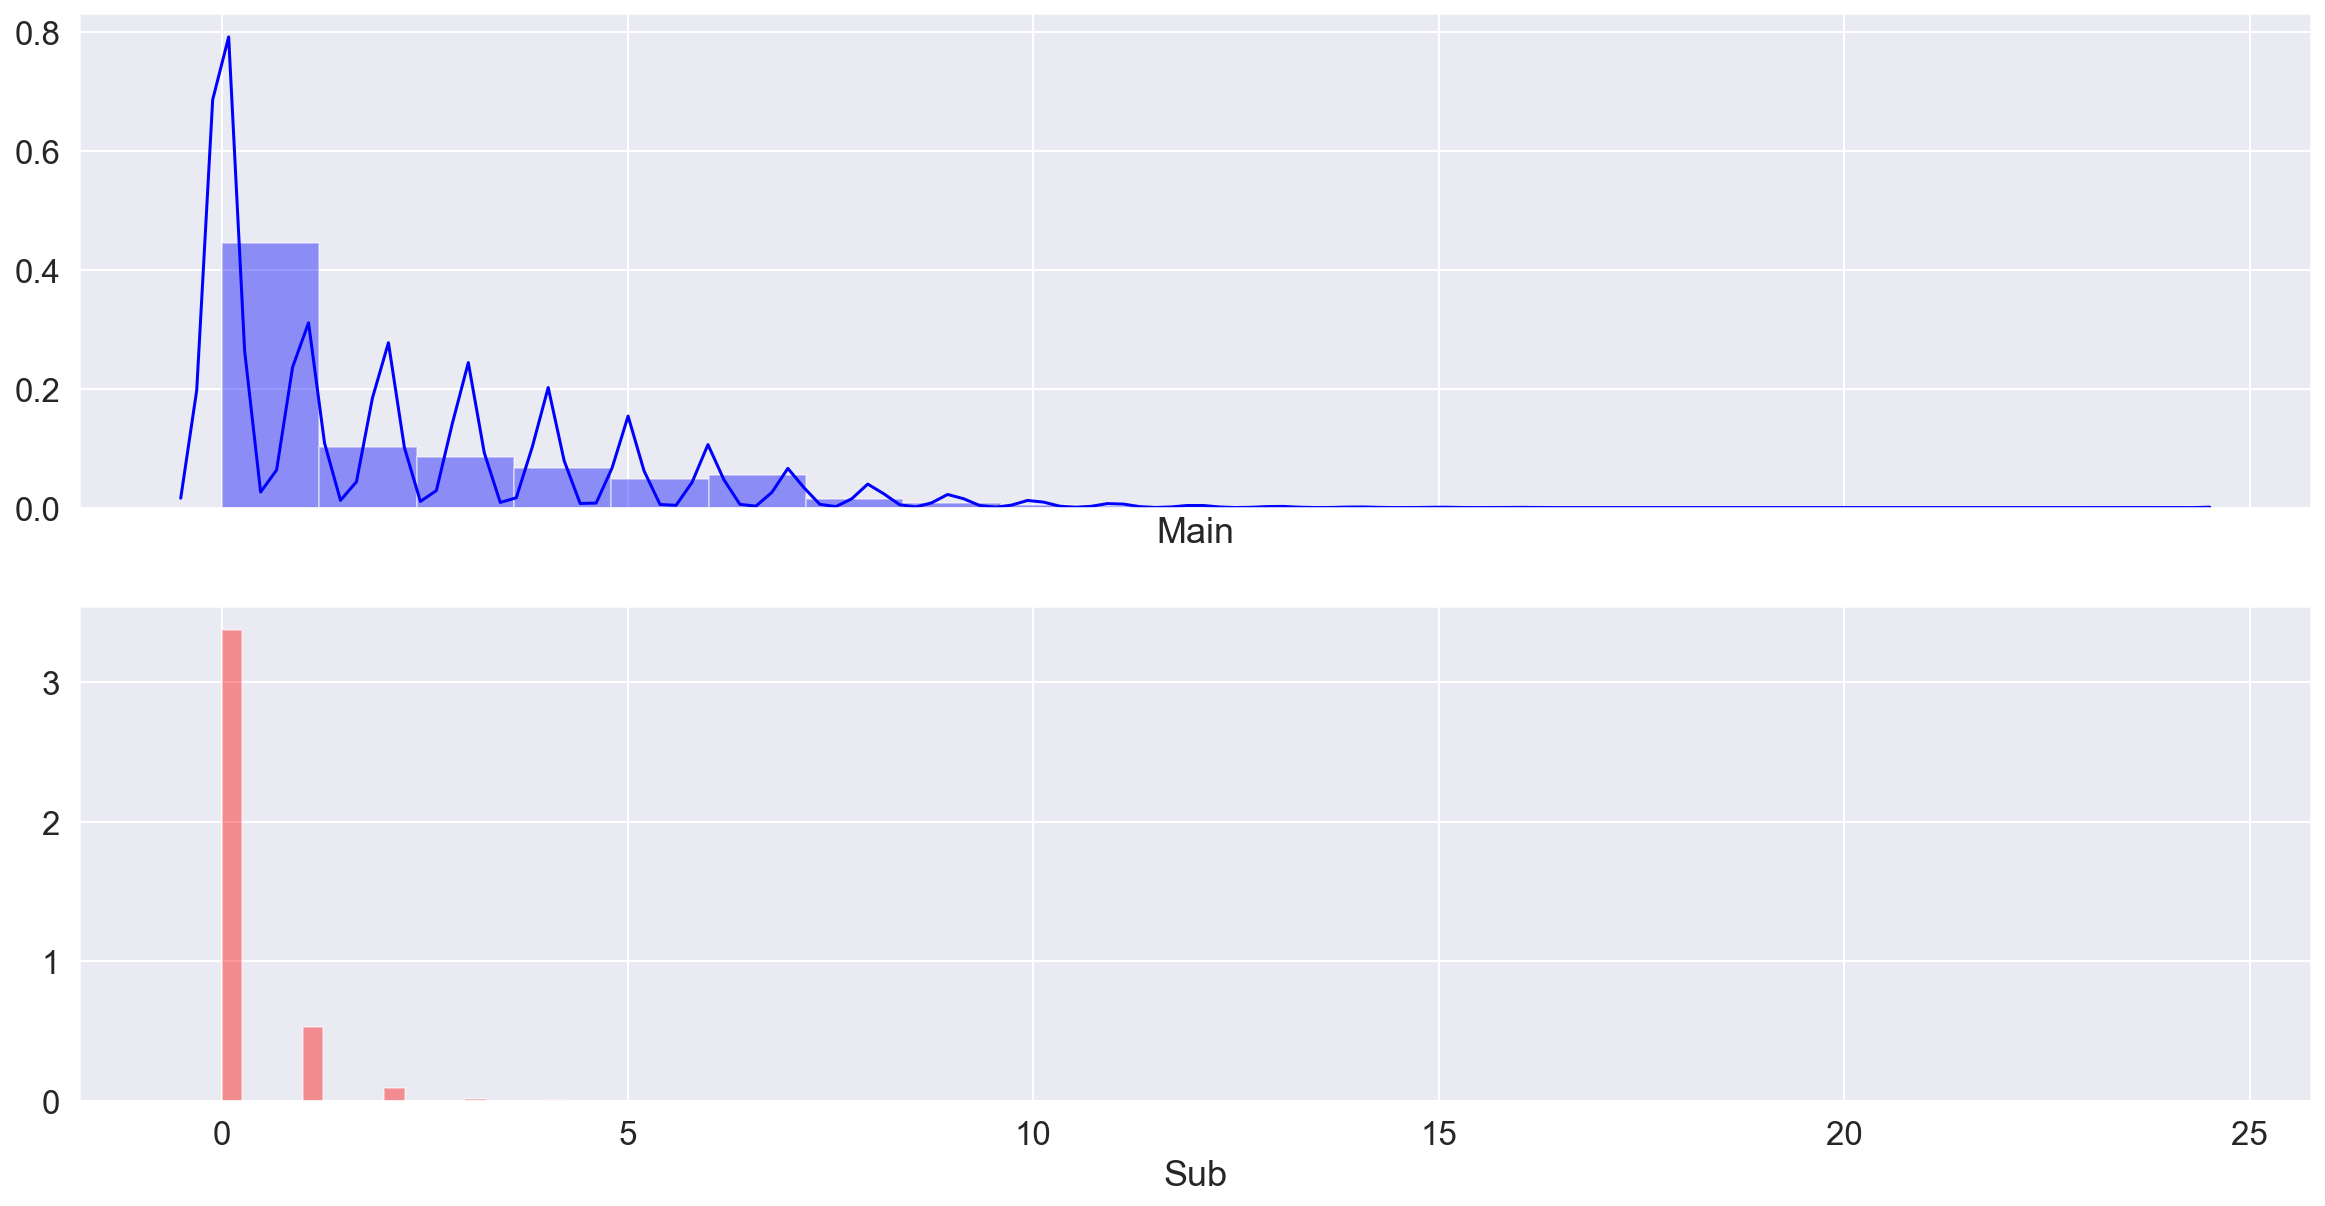

COLUMN : nba_fg3_pct 
 Main min 0.00	 Sub min 0.00 
 Main max 1.00	 Sub max 1.00


/Users/finnalexander/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


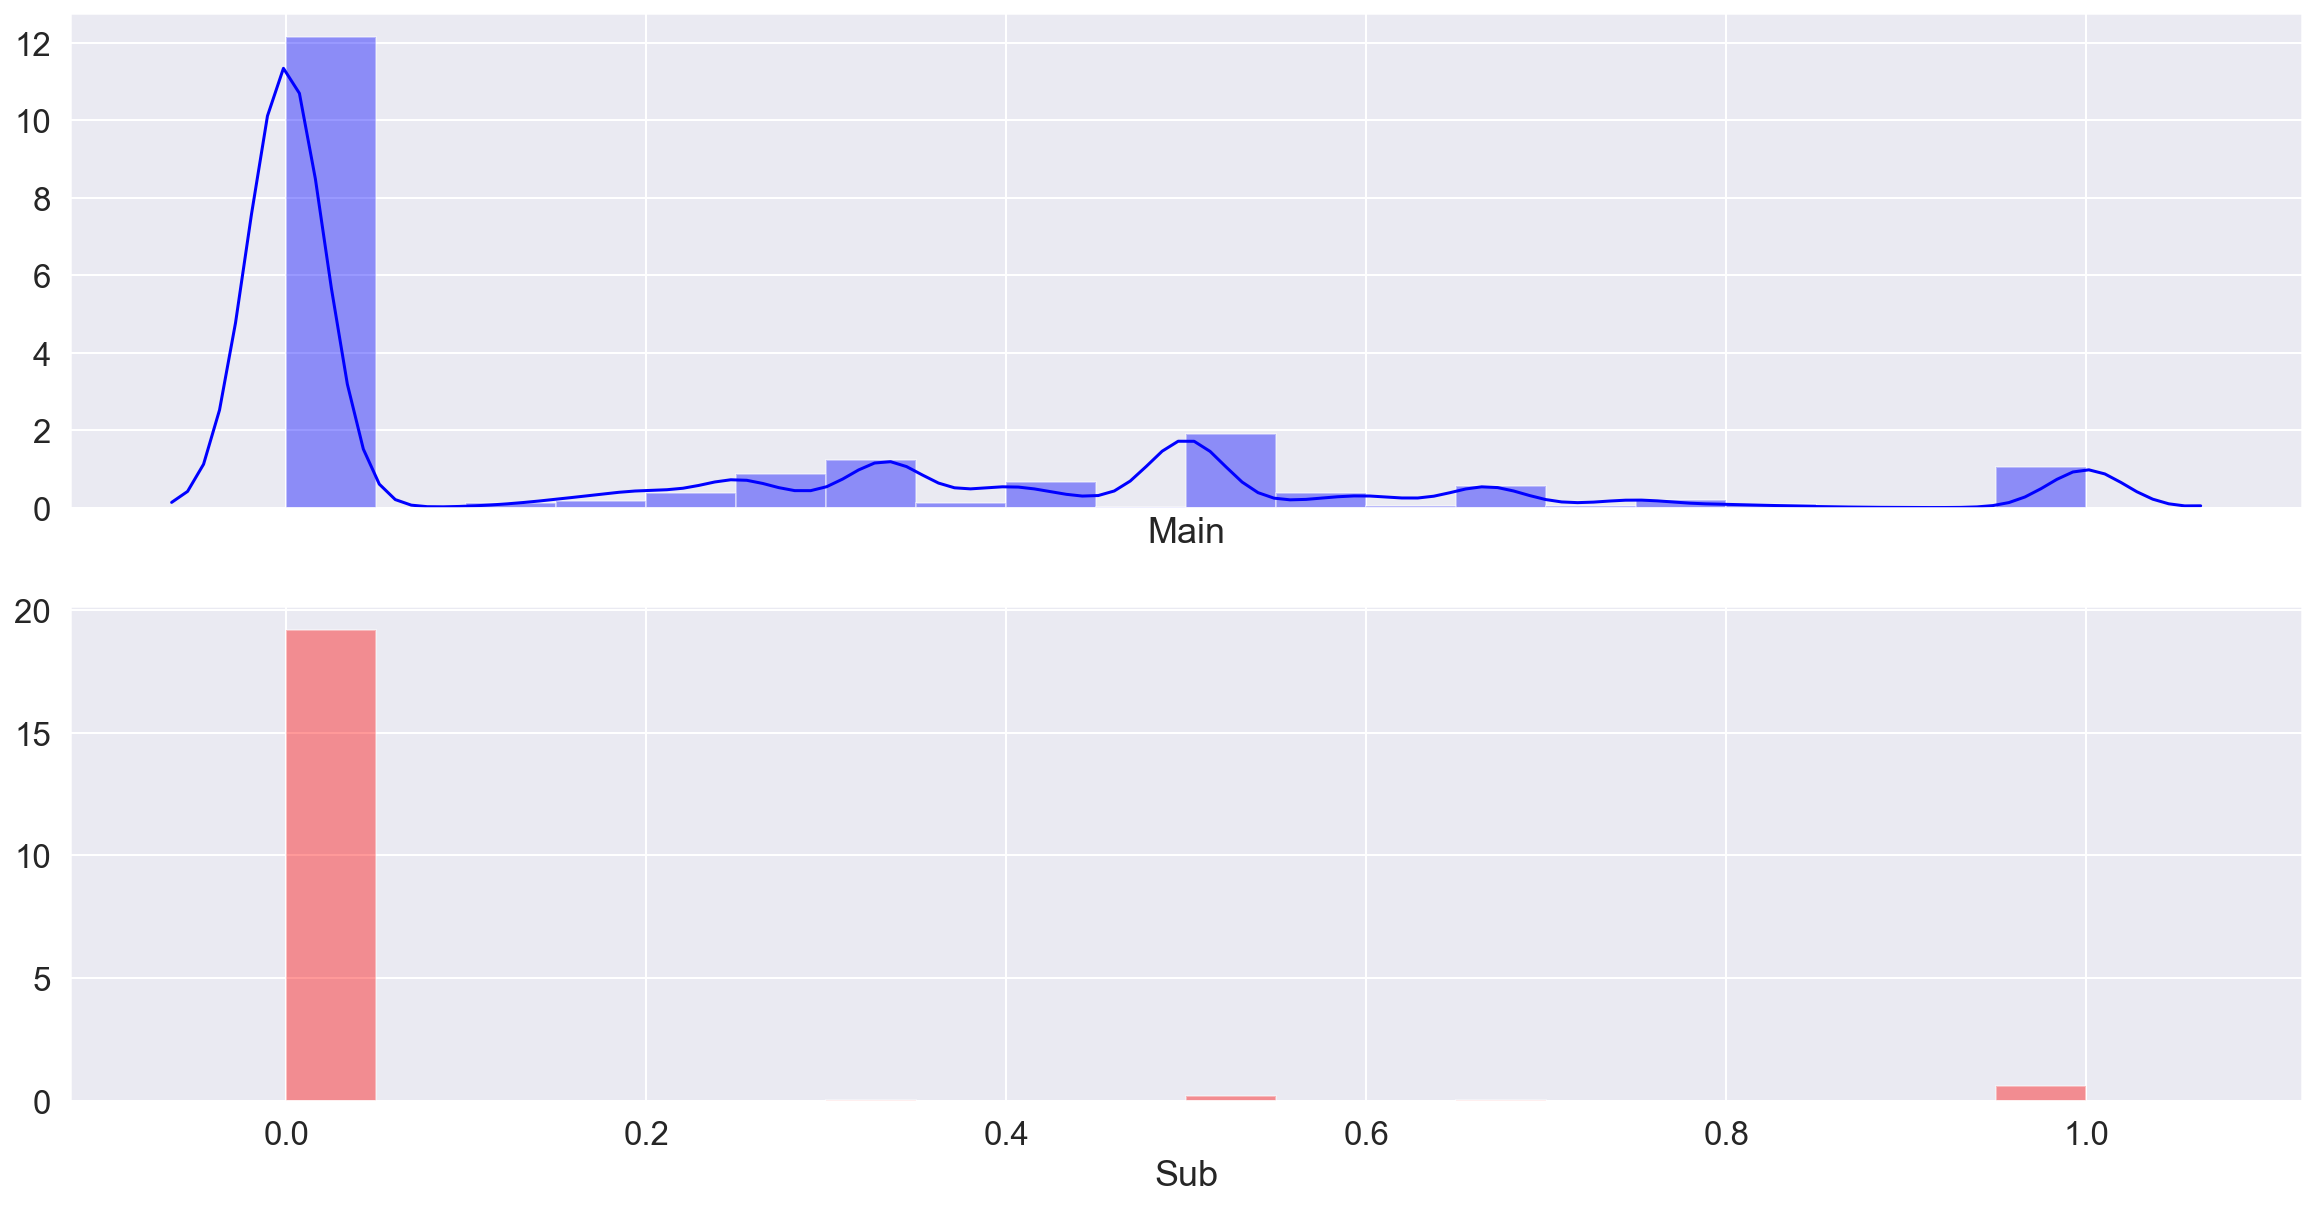

COLUMN : nba_ftm 
 Main min 0.00	 Sub min 0.00 
 Main max 26.00	 Sub max 6.00


/Users/finnalexander/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


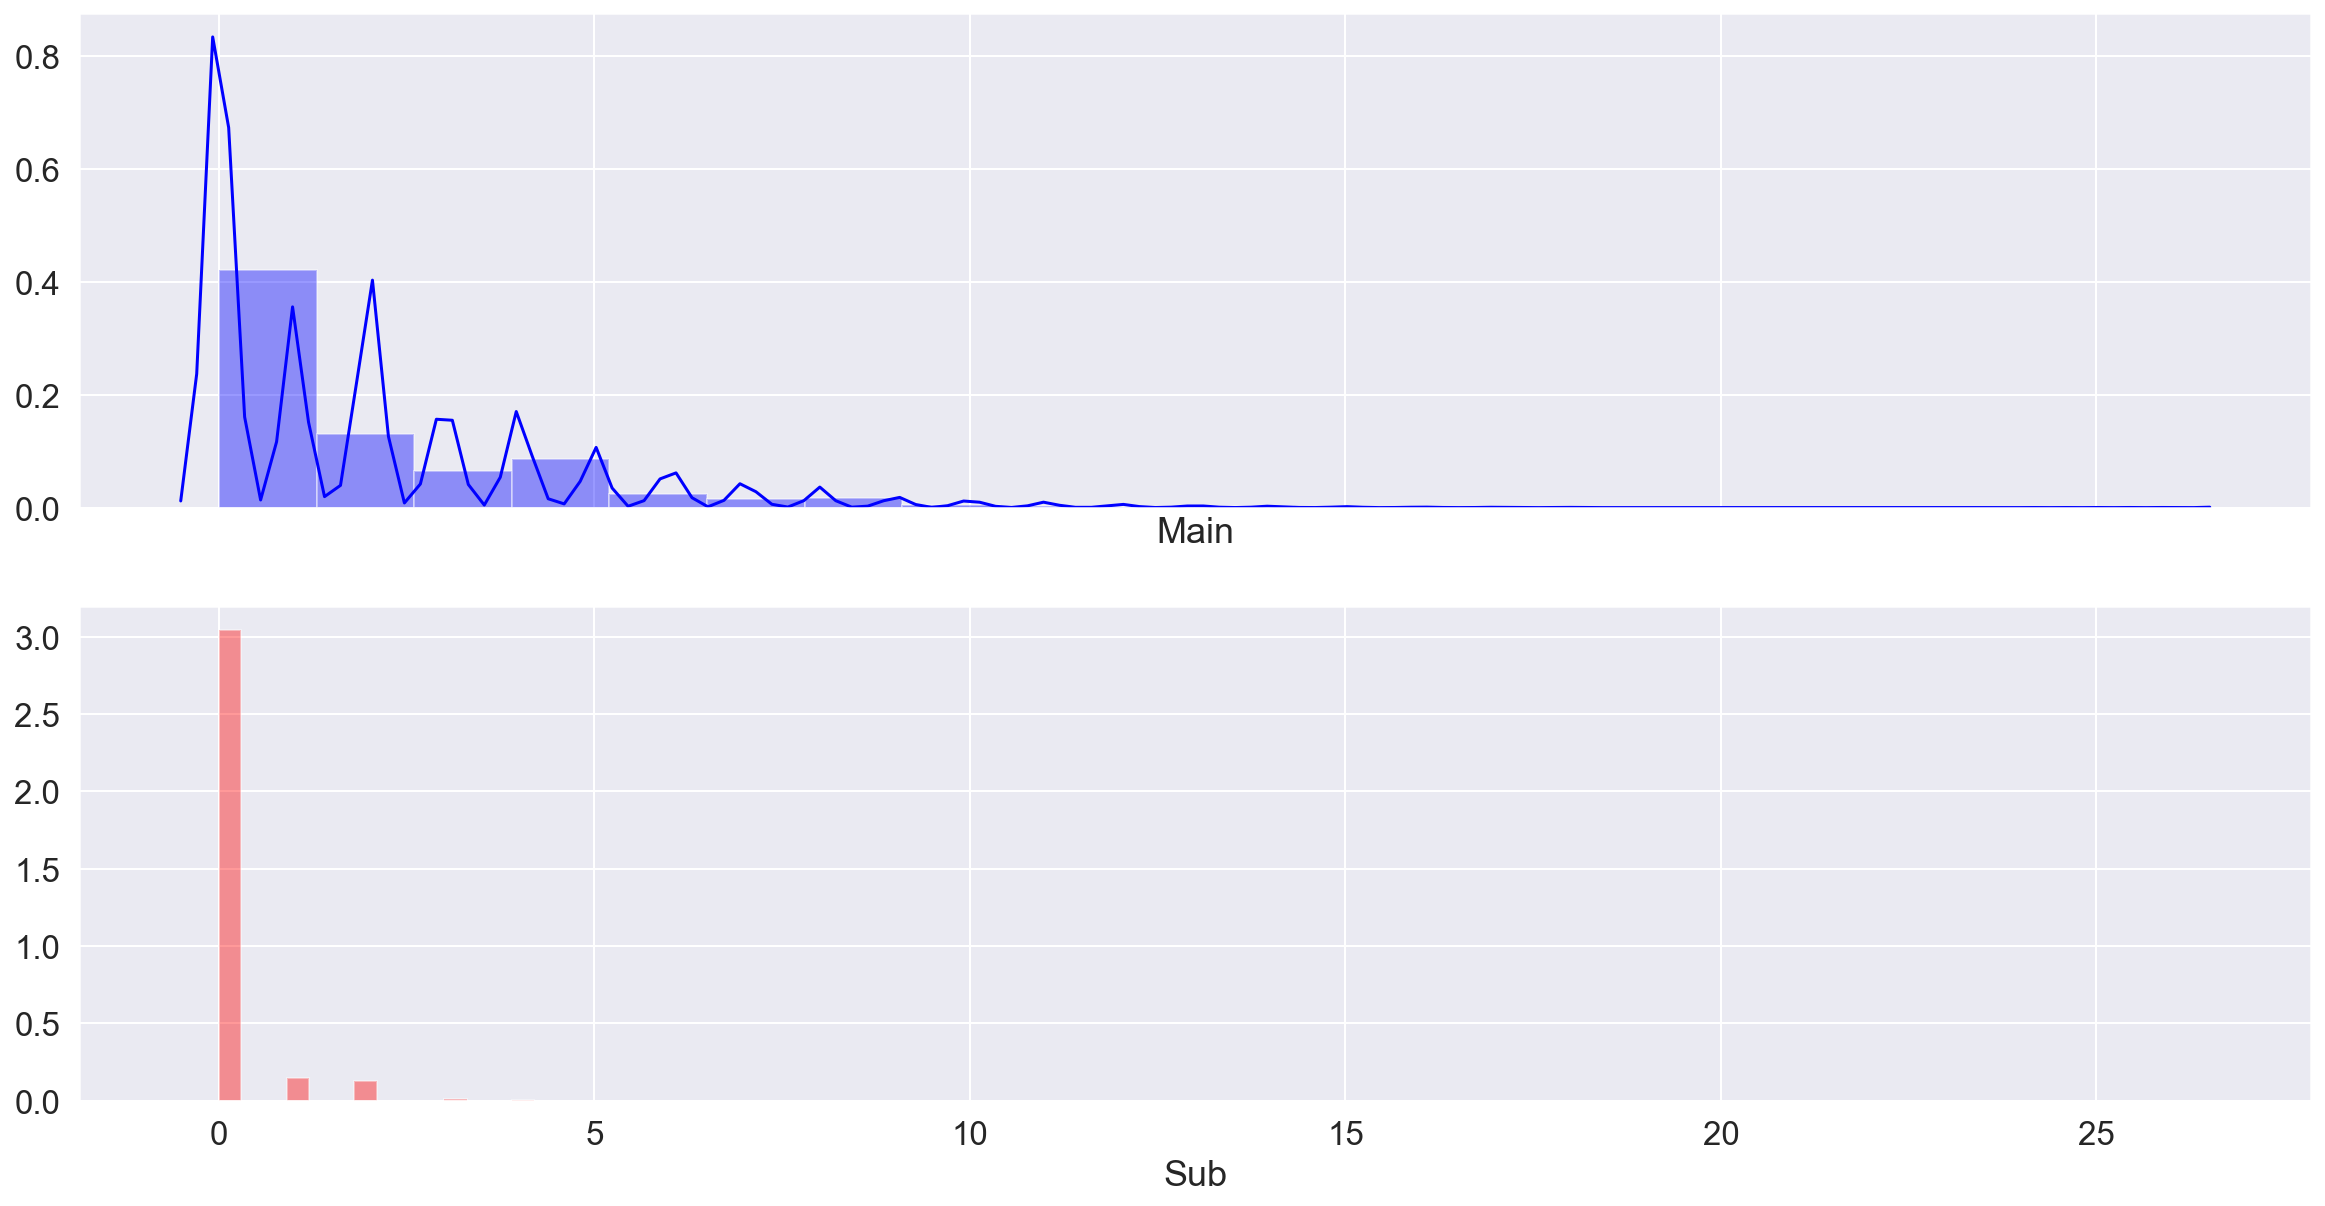

COLUMN : nba_fta 
 Main min 0.00	 Sub min 0.00 
 Main max 39.00	 Sub max 10.00


/Users/finnalexander/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


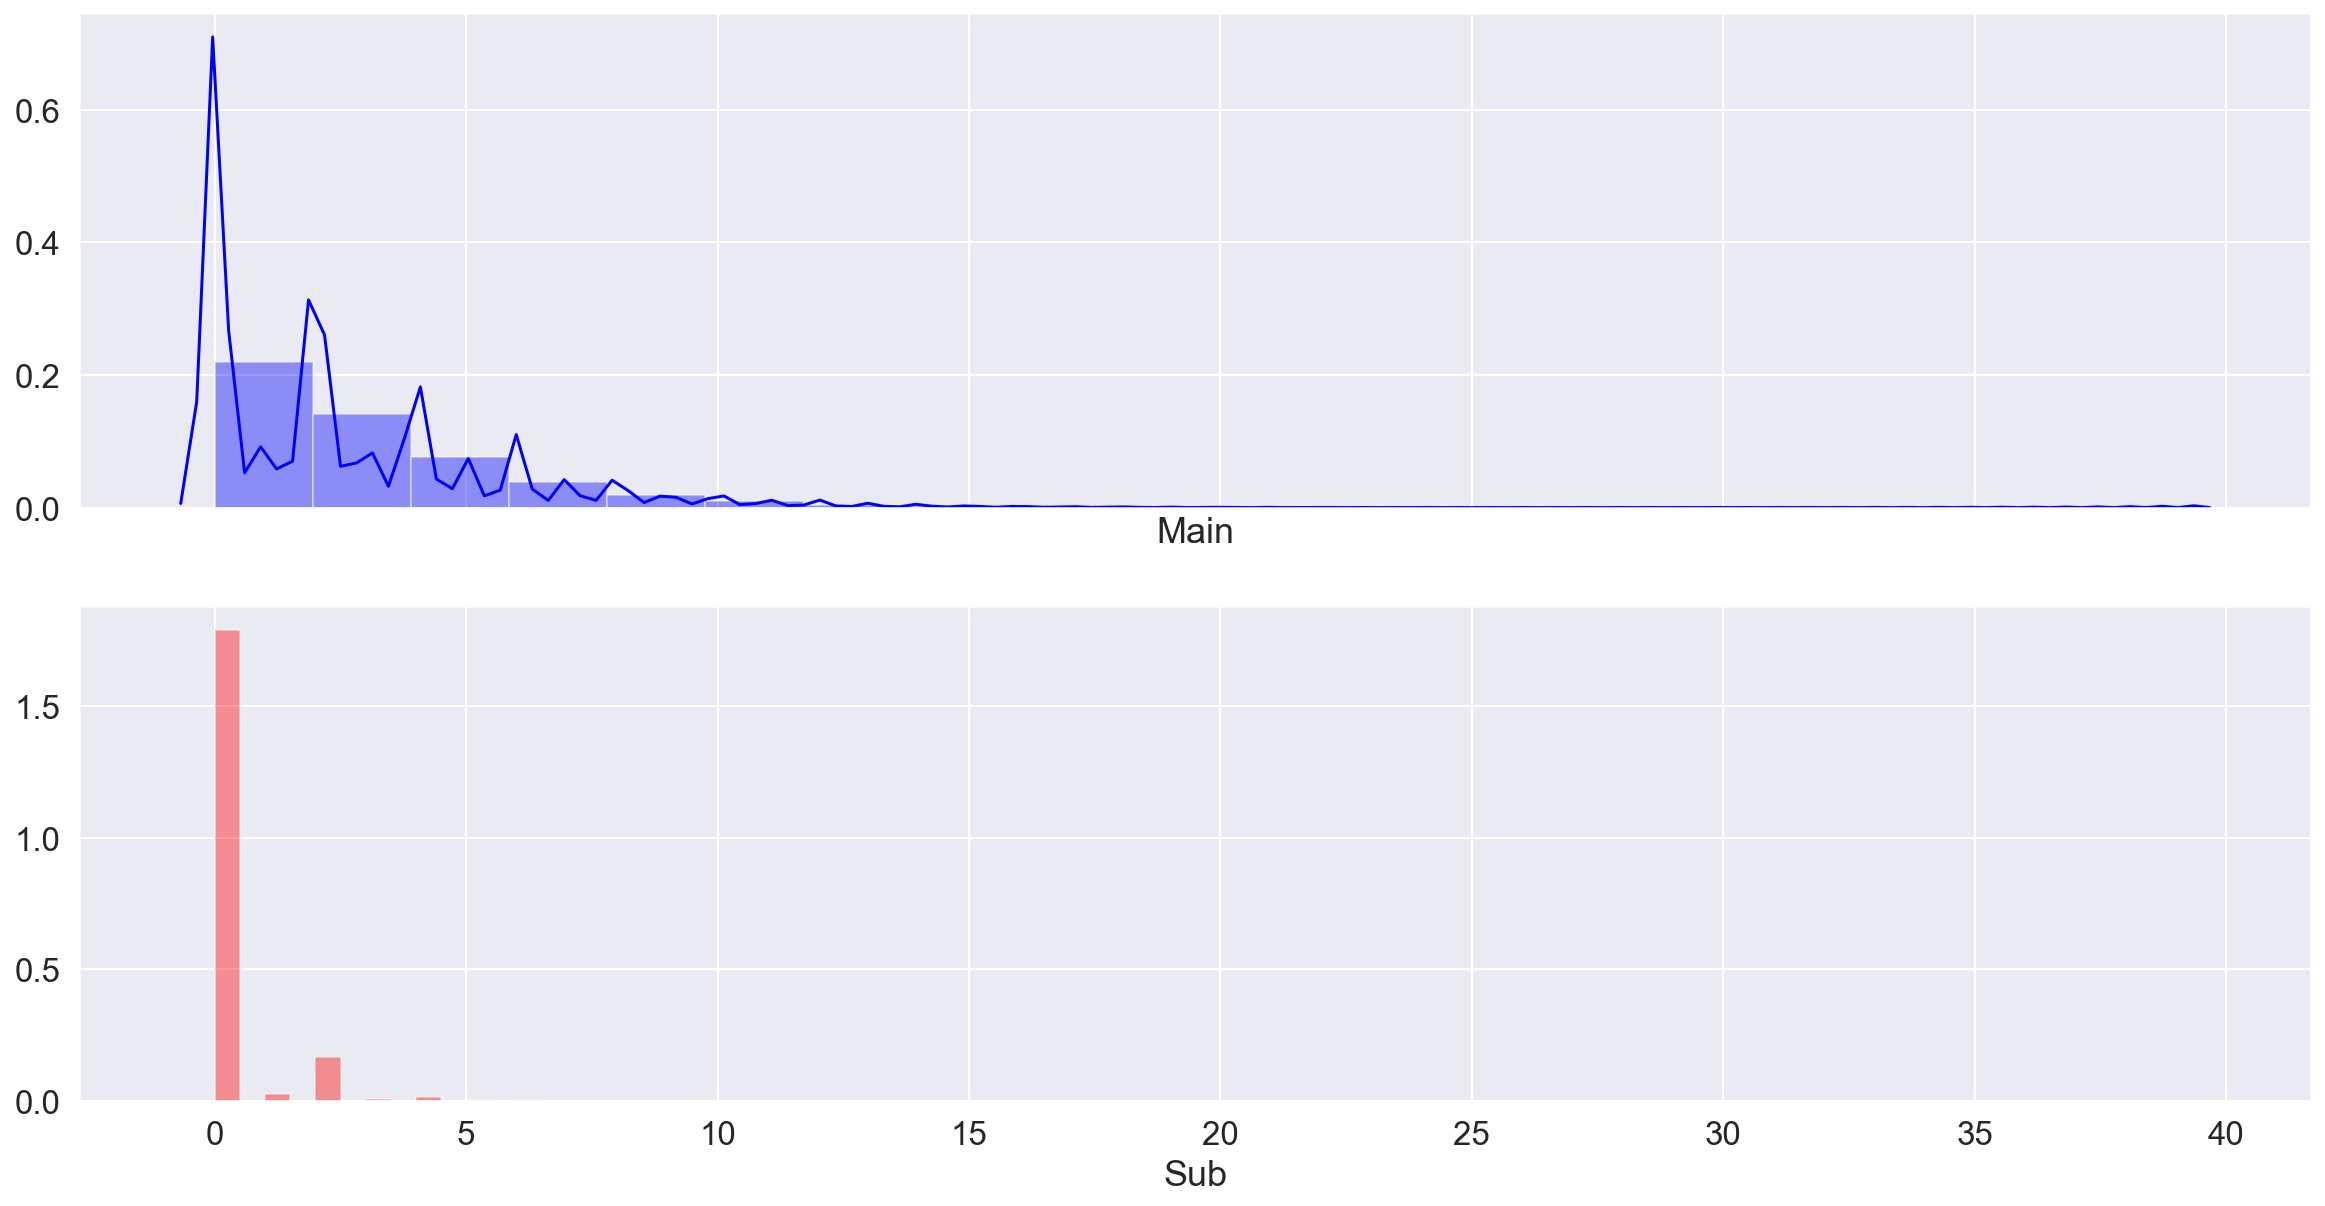

COLUMN : nba_ft_pct 
 Main min 0.00	 Sub min 0.00 
 Main max 1.00	 Sub max 1.00


/Users/finnalexander/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


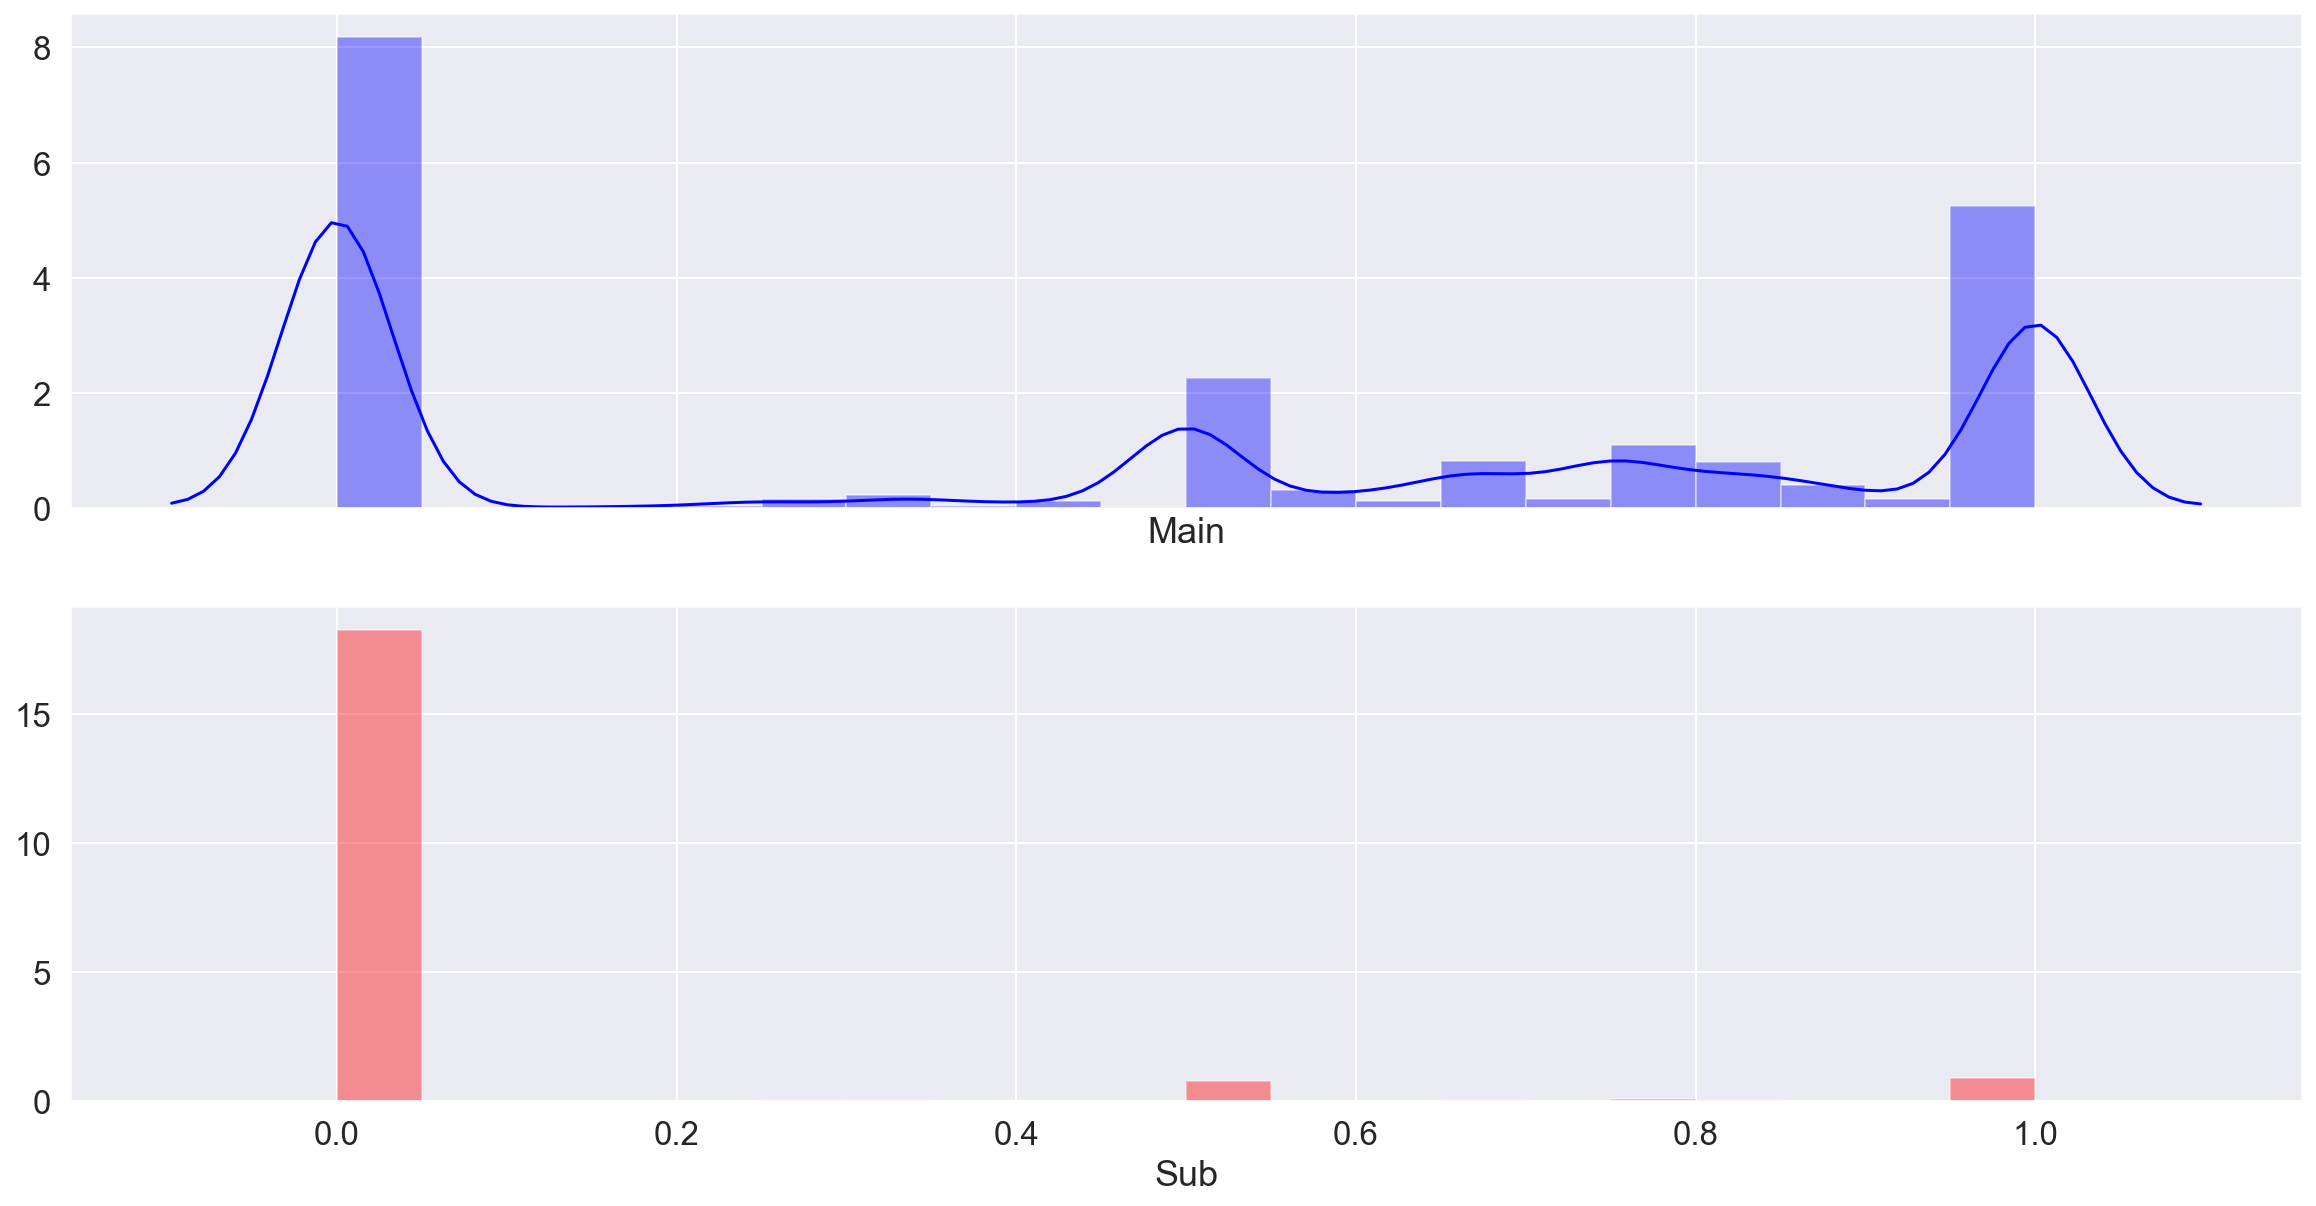

COLUMN : nba_oreb 
 Main min 0.00	 Sub min 0.00 
 Main max 18.00	 Sub max 4.00


/Users/finnalexander/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


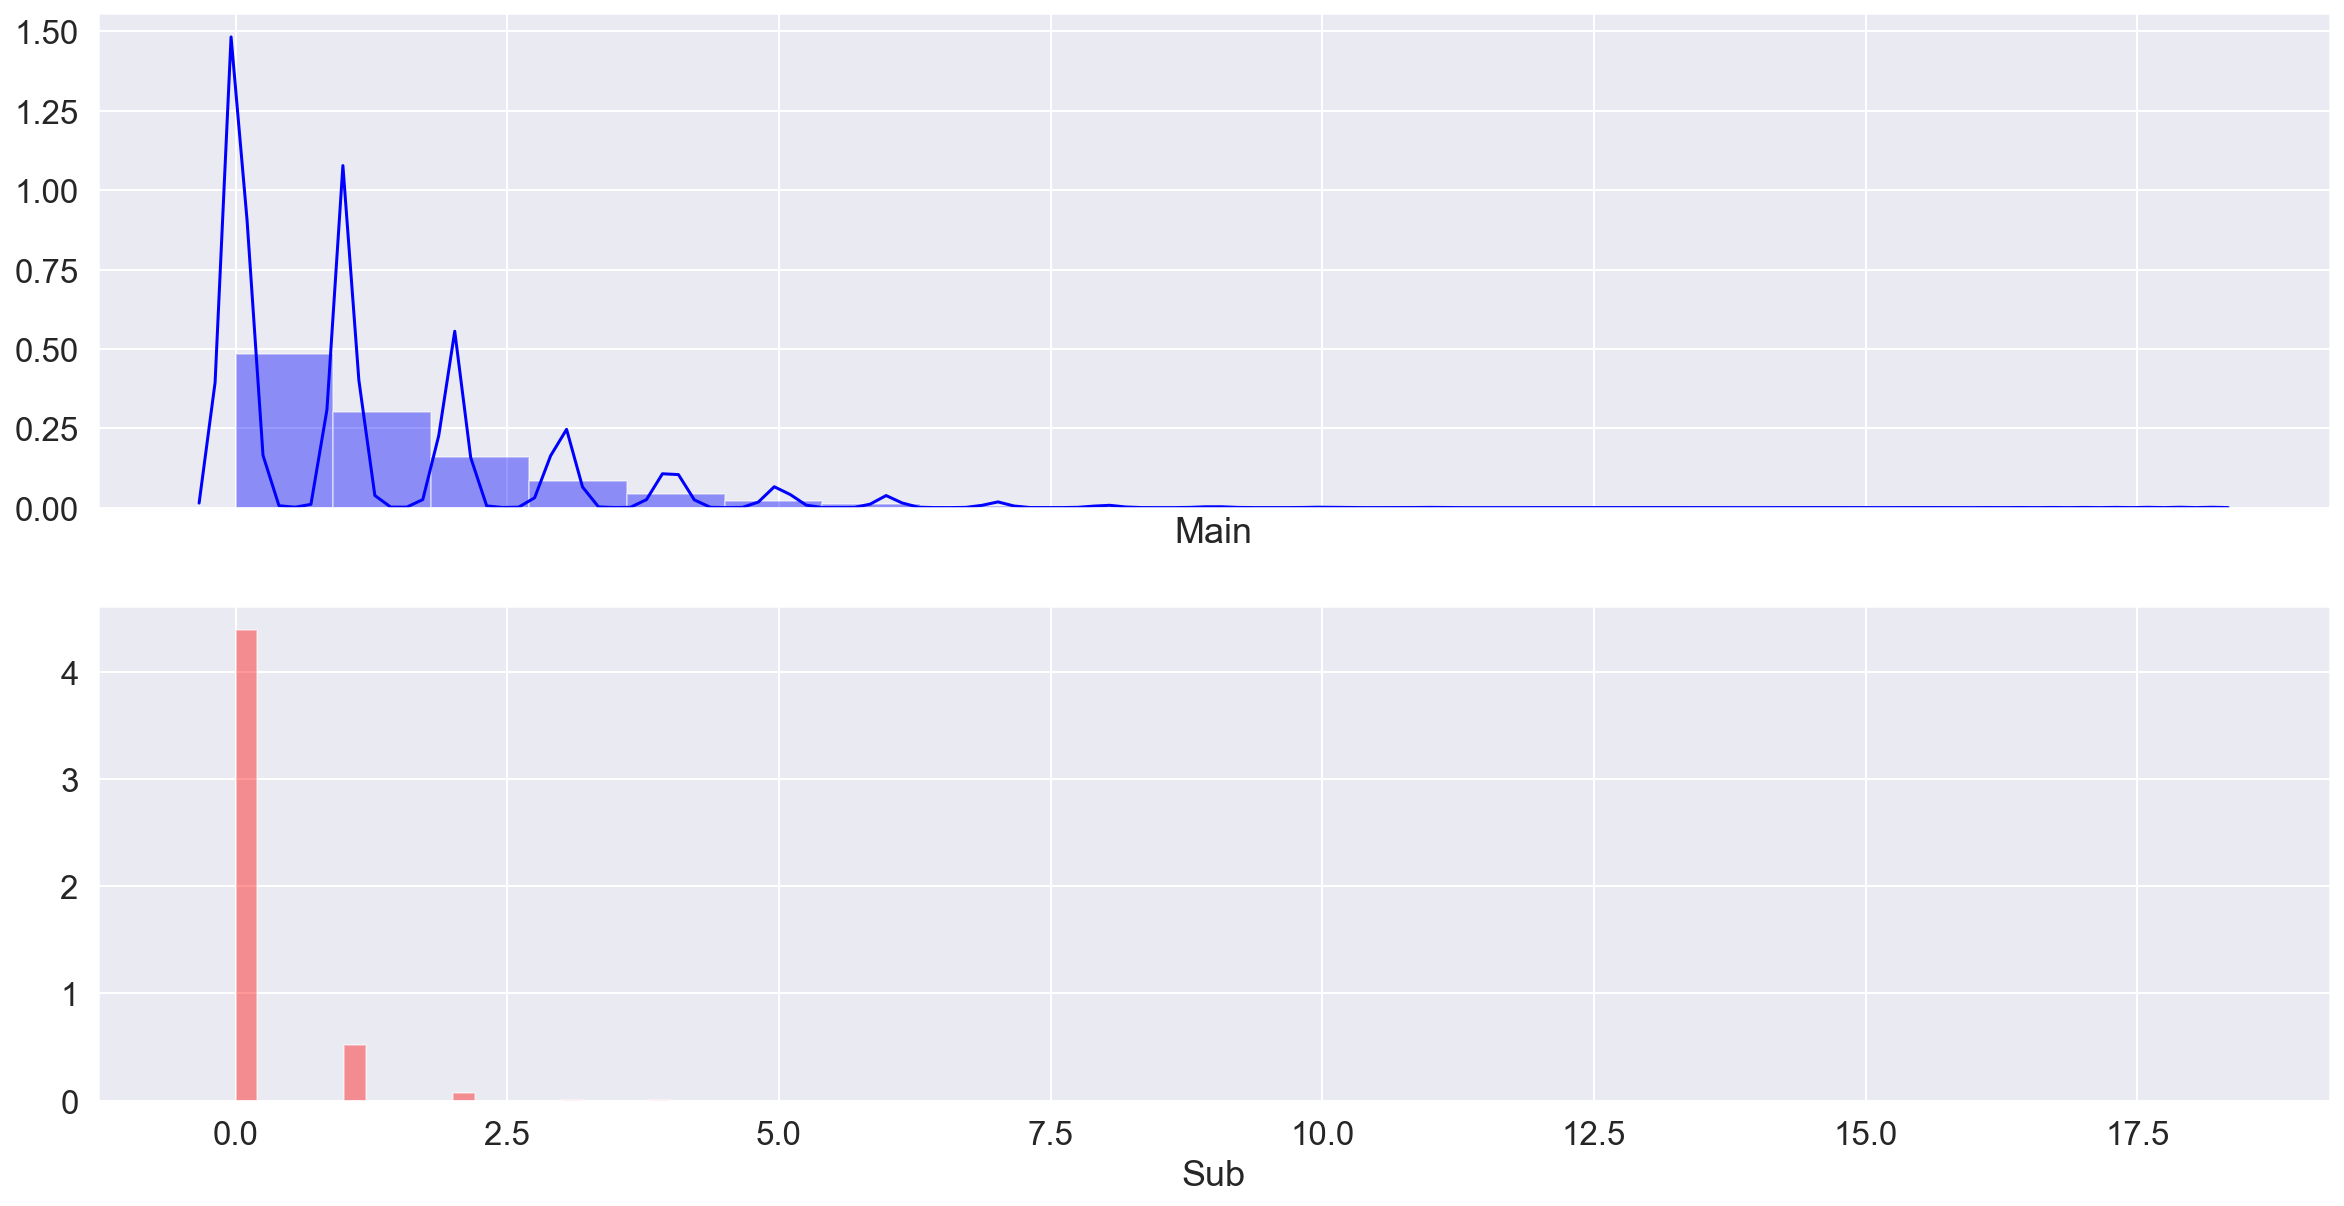

COLUMN : nba_dreb 
 Main min 0.00	 Sub min 0.00 
 Main max 25.00	 Sub max 6.00


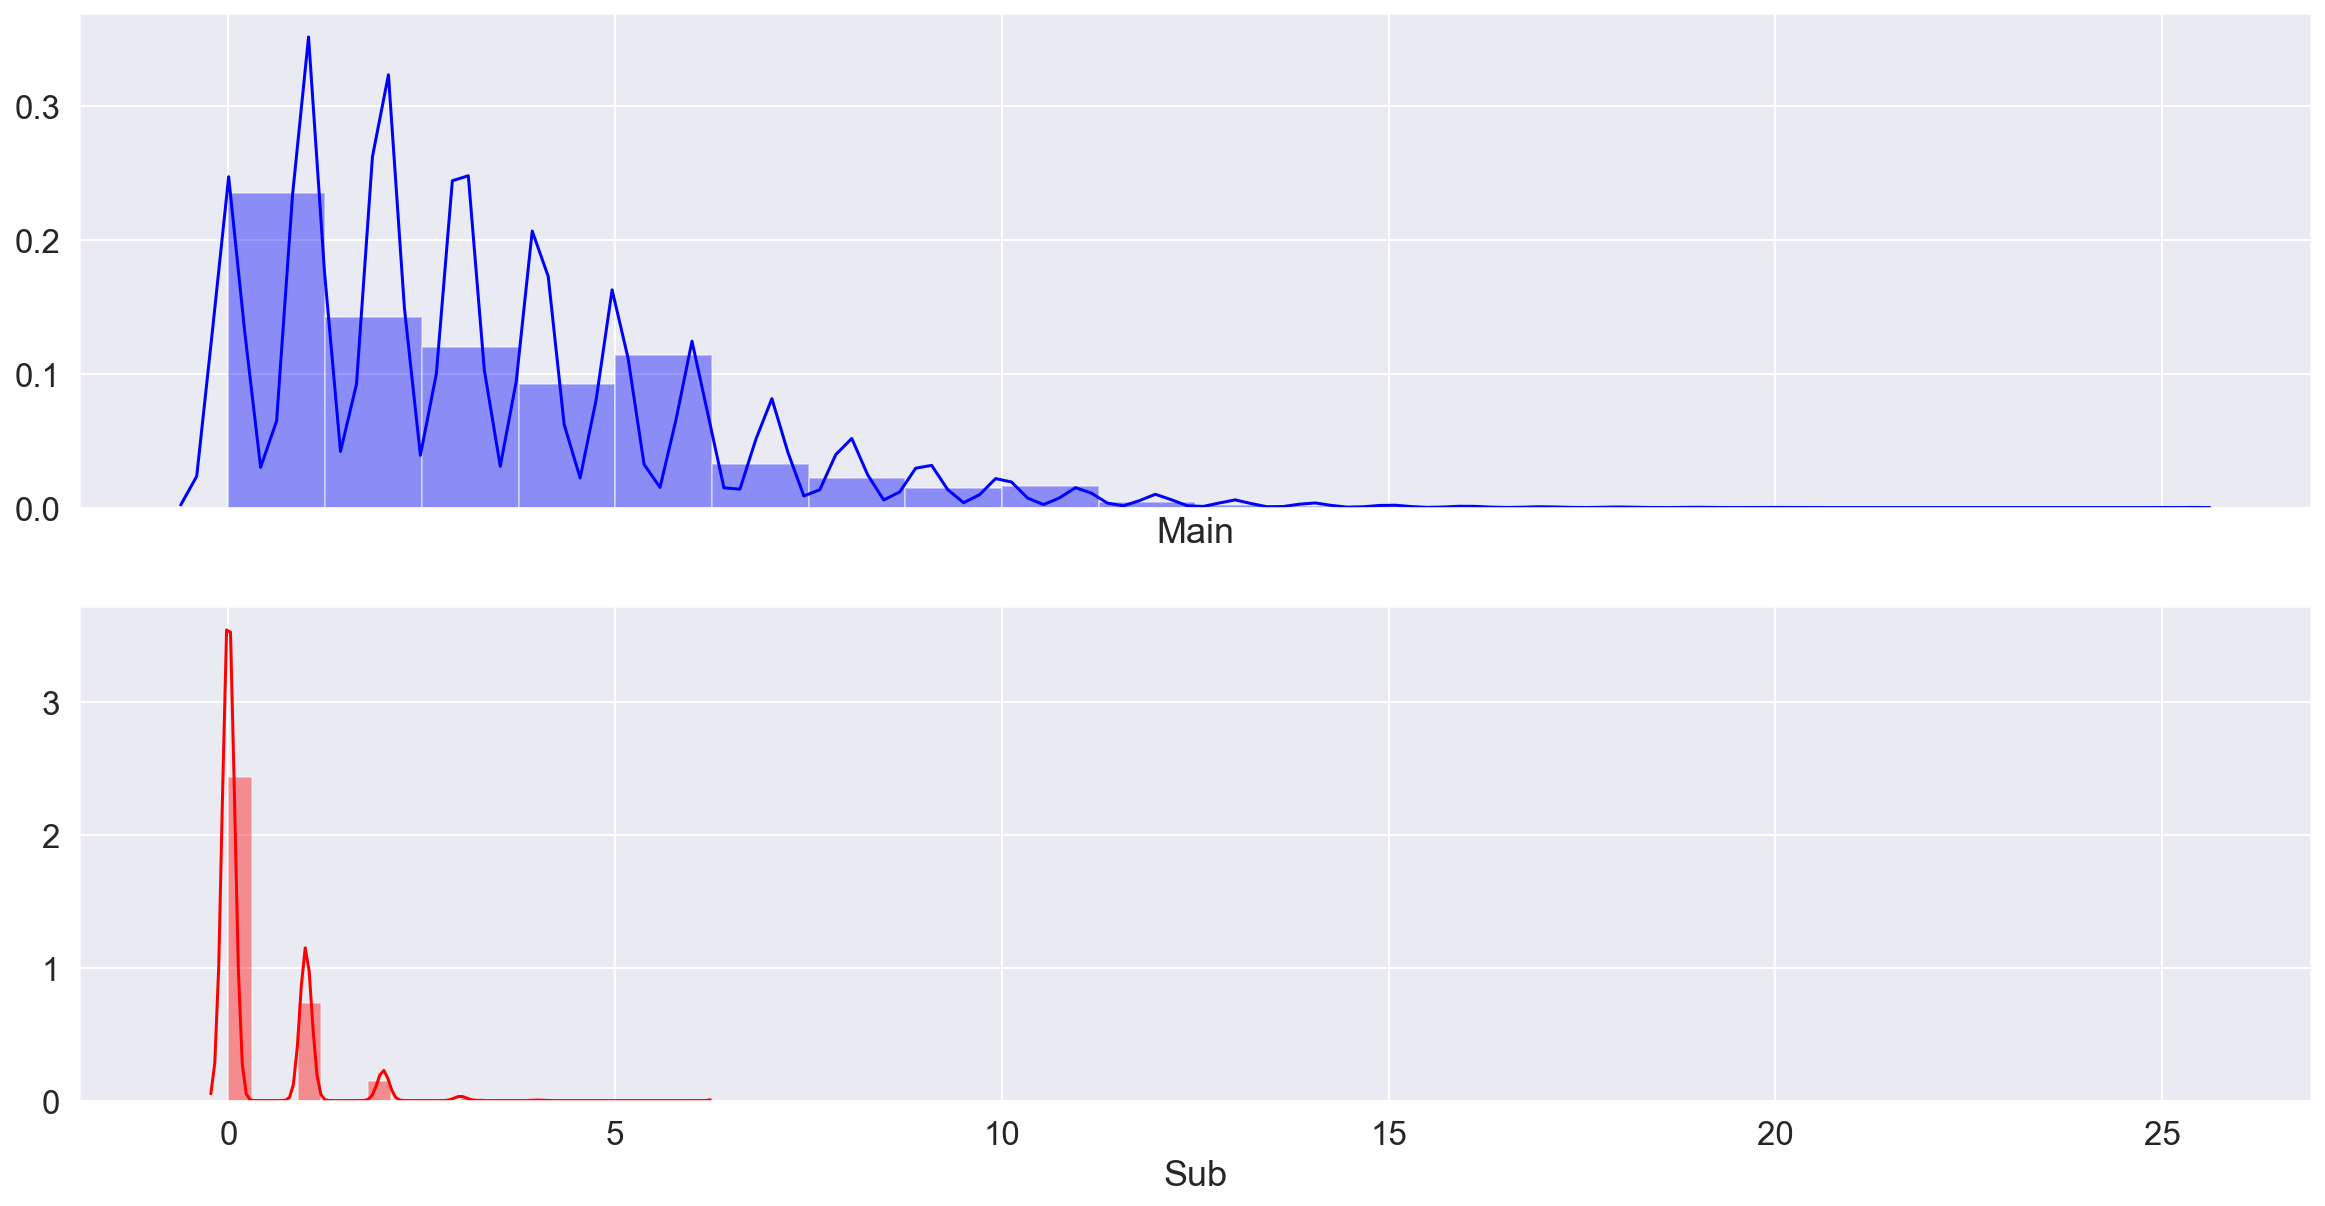

COLUMN : nba_reb 
 Main min 0.00	 Sub min 0.00 
 Main max 31.00	 Sub max 6.00


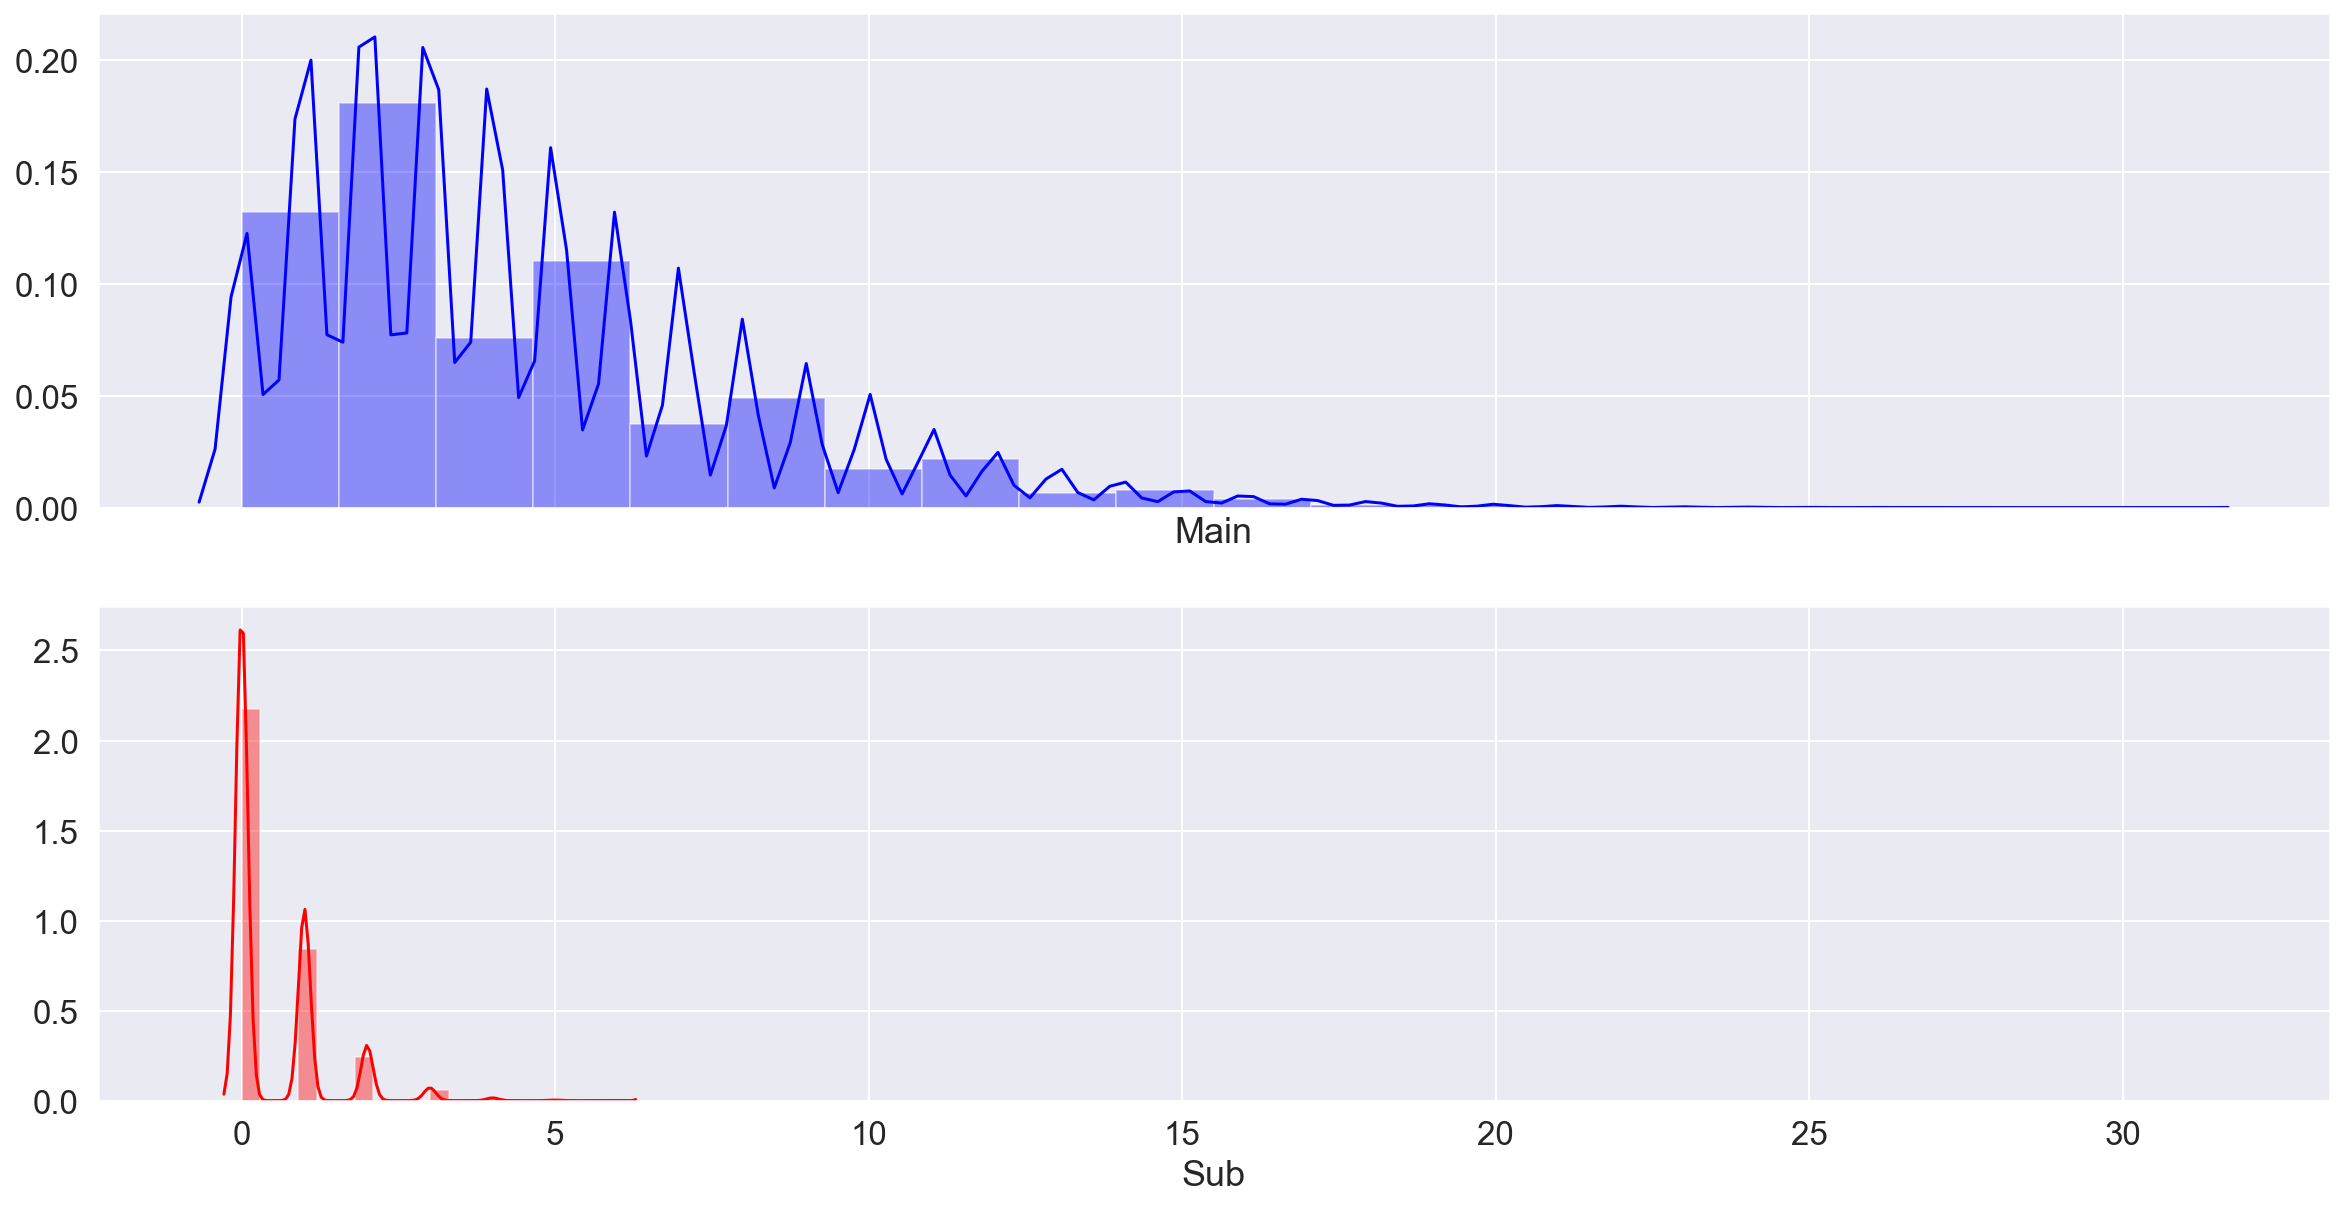

COLUMN : nba_ast 
 Main min 0.00	 Sub min 0.00 
 Main max 25.00	 Sub max 4.00


/Users/finnalexander/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


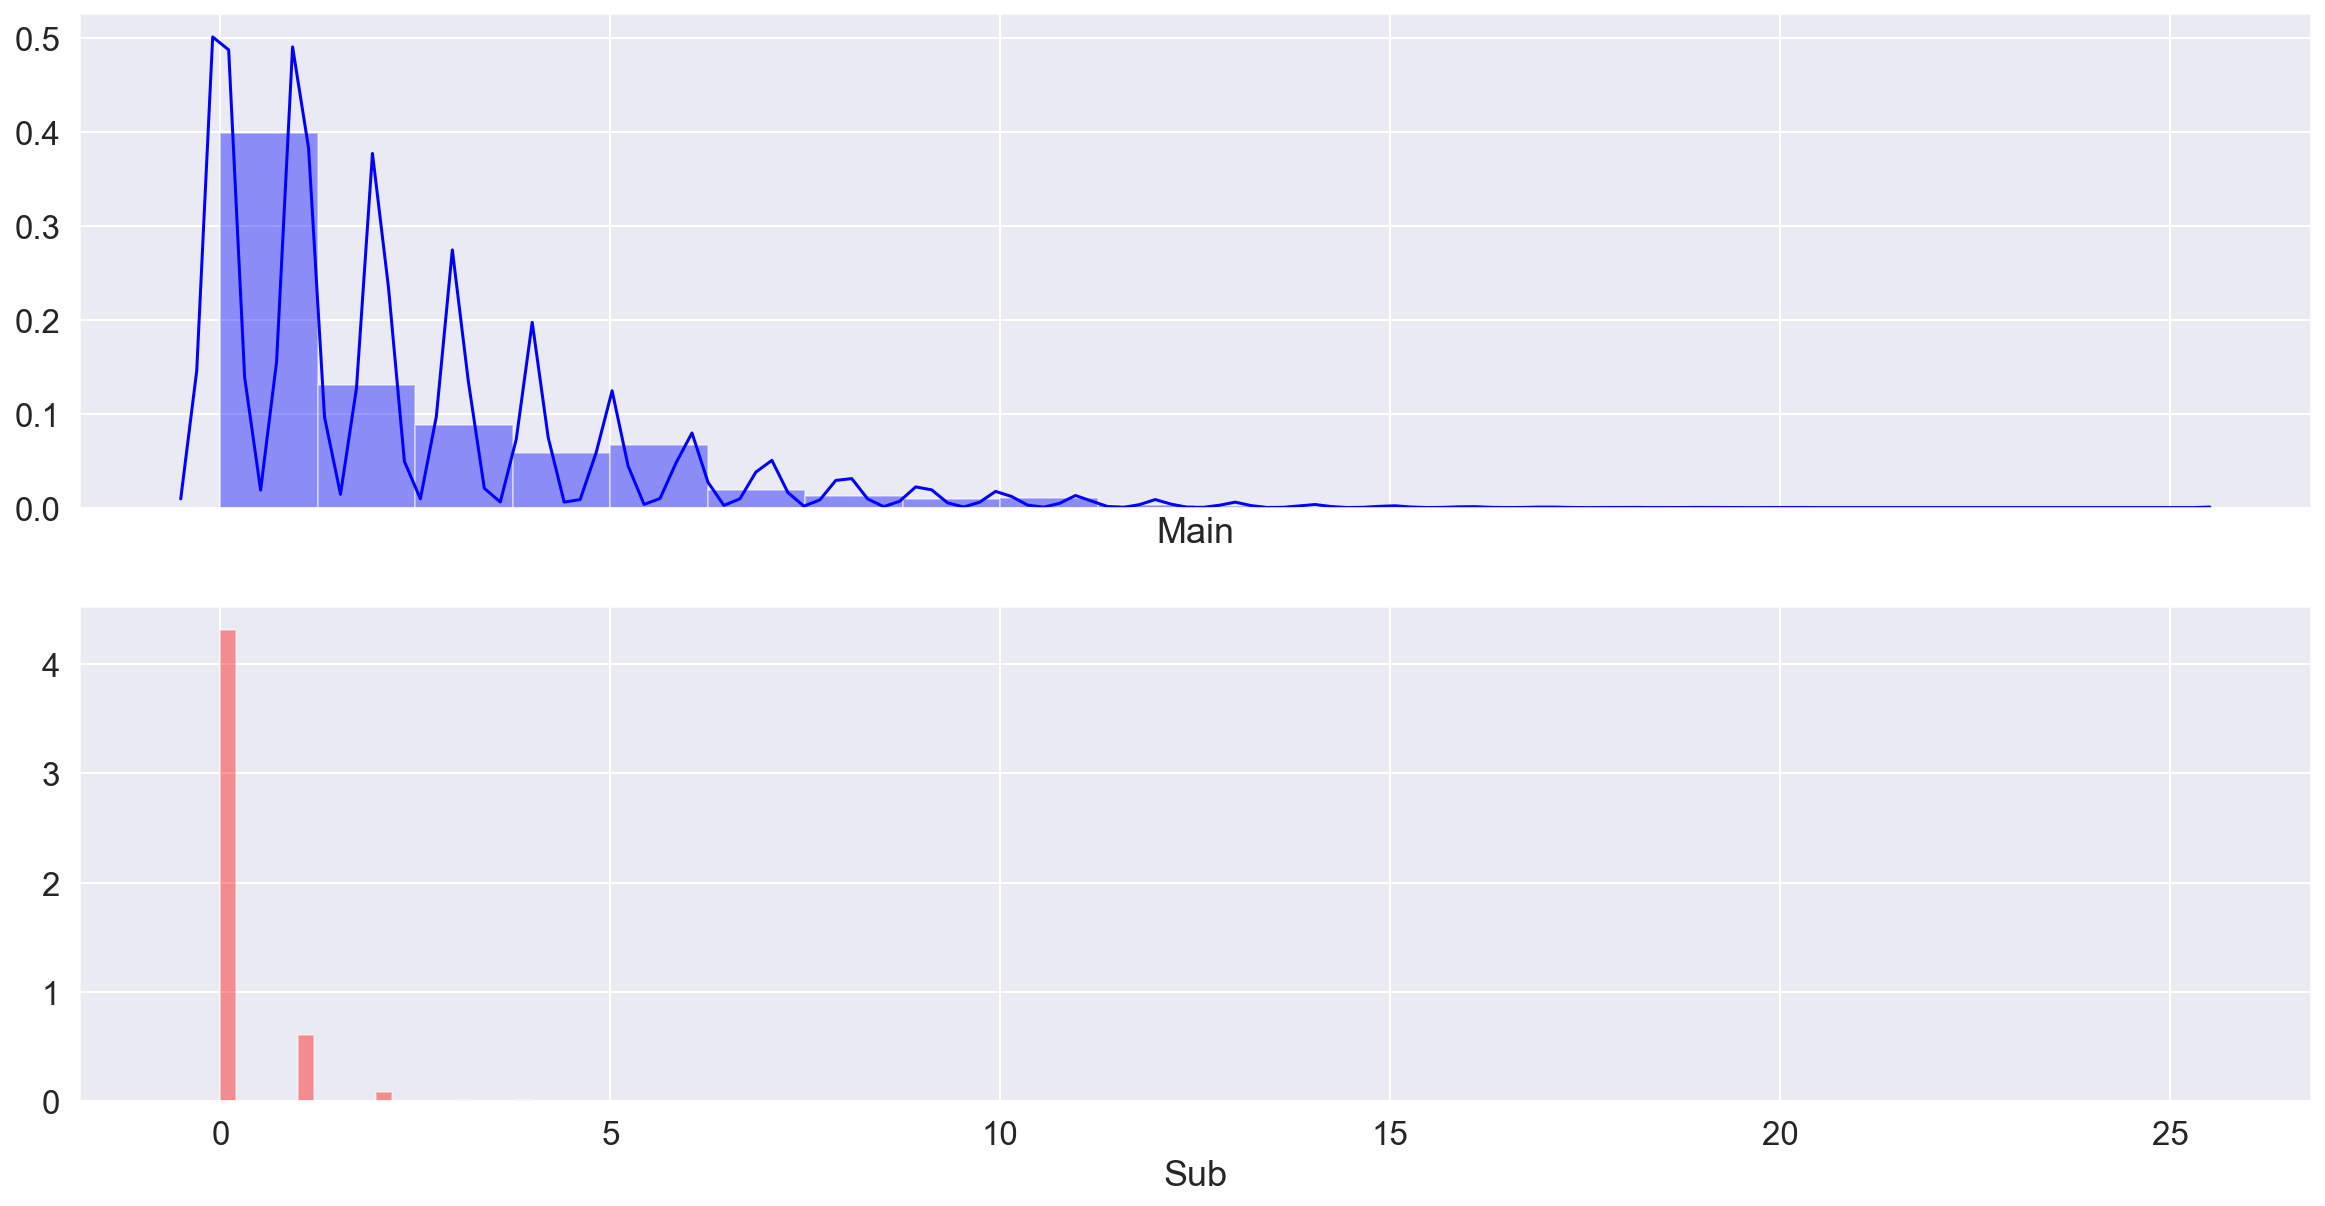

COLUMN : nba_stl 
 Main min 0.00	 Sub min 0.00 
 Main max 10.00	 Sub max 3.00


/Users/finnalexander/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


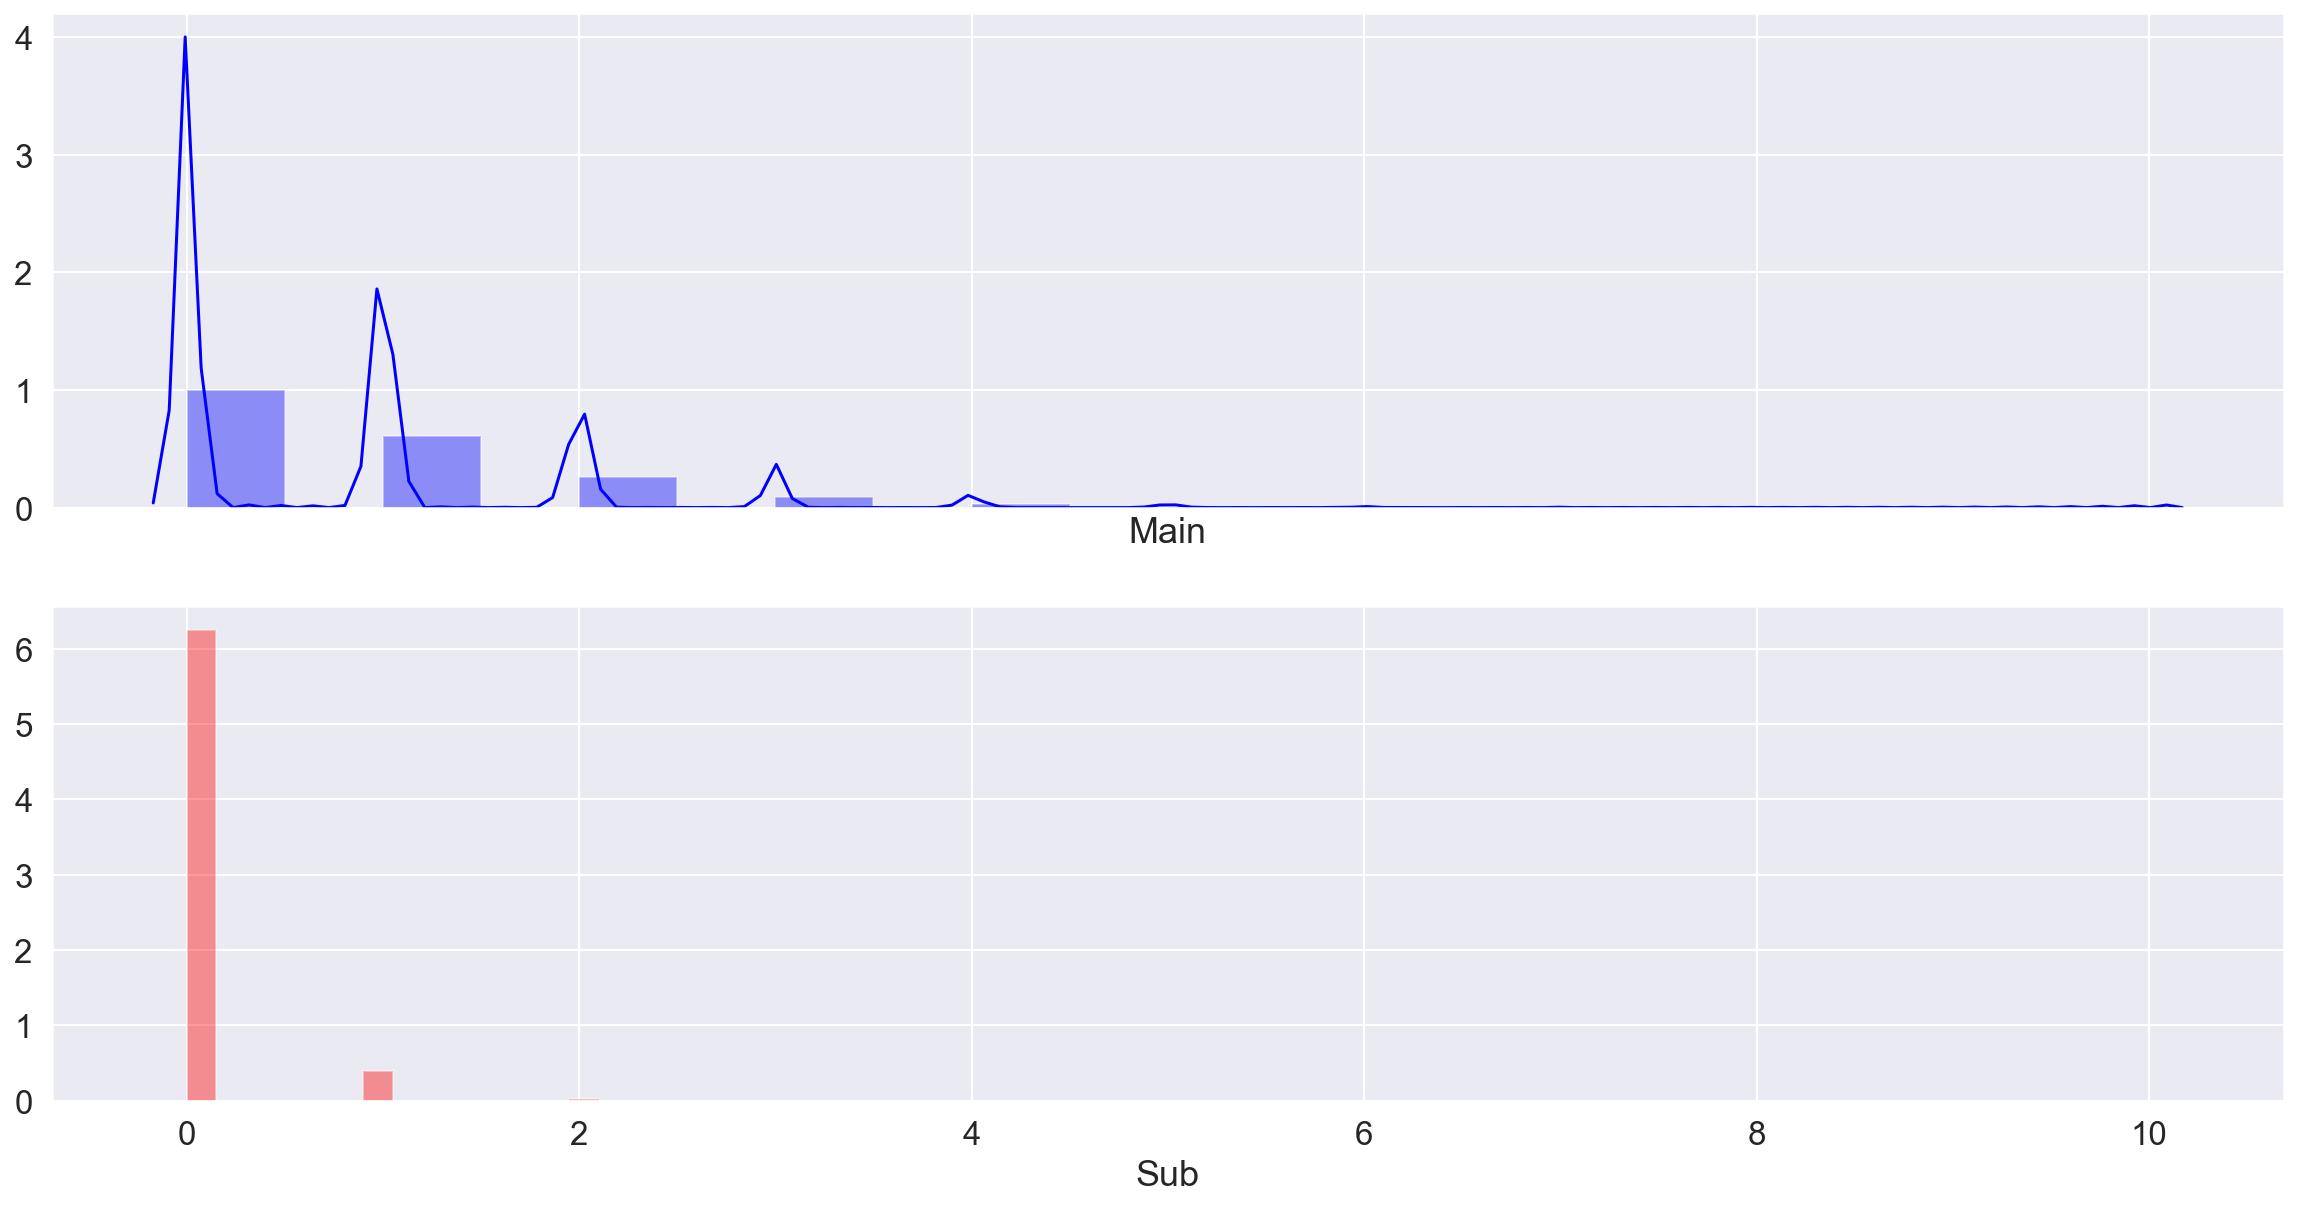

COLUMN : nba_blk 
 Main min 0.00	 Sub min 0.00 
 Main max 12.00	 Sub max 3.00


/Users/finnalexander/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


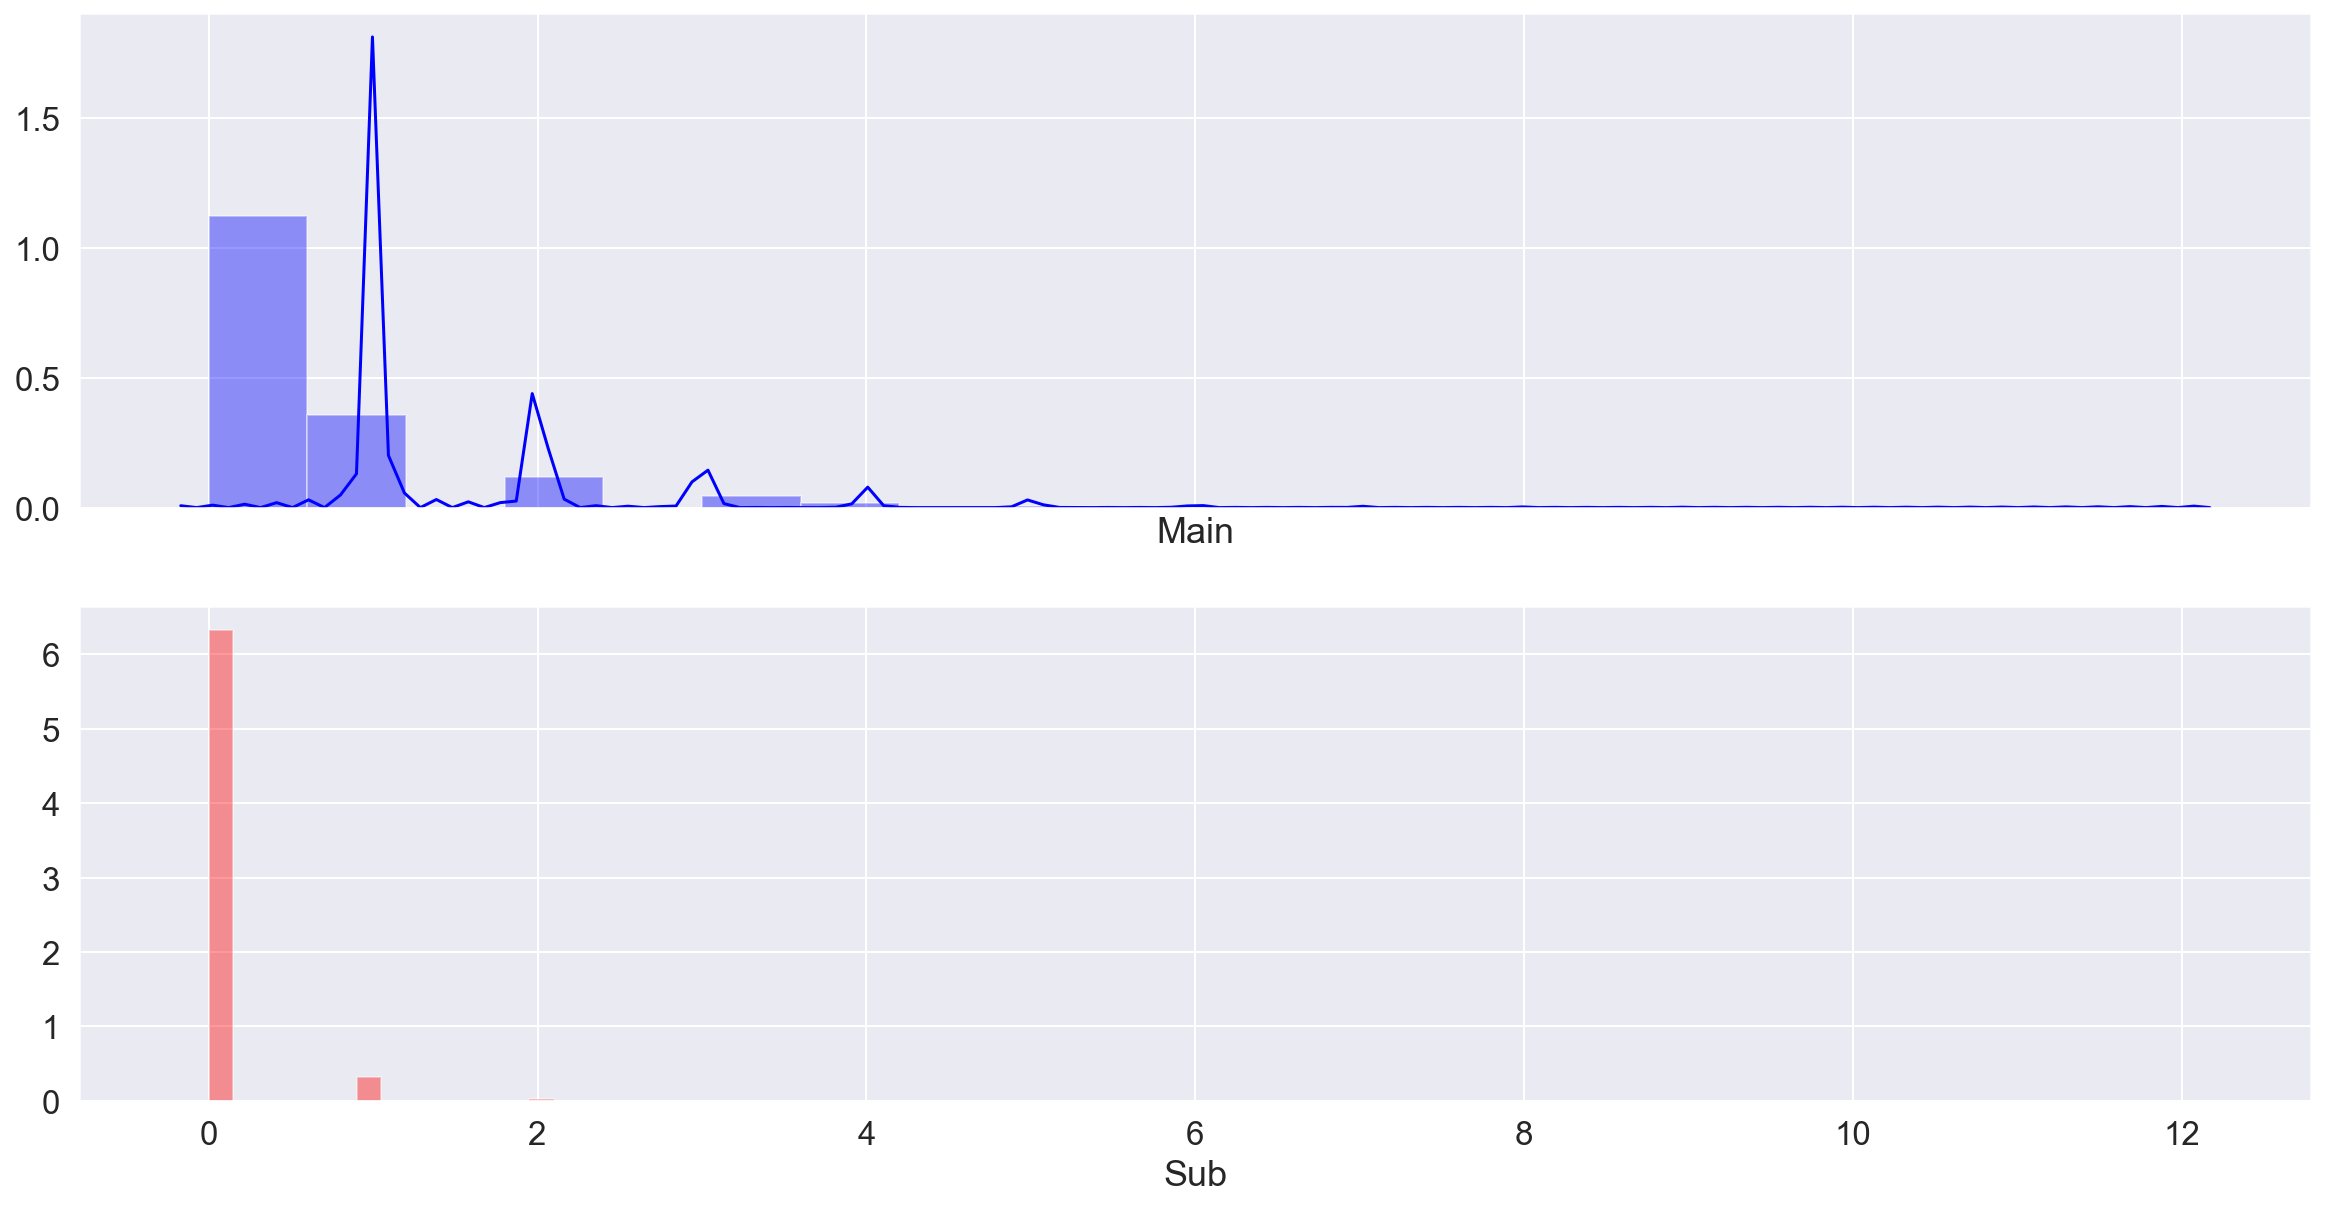

COLUMN : nba_to 
 Main min 0.00	 Sub min 0.00 
 Main max 14.00	 Sub max 4.00


/Users/finnalexander/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


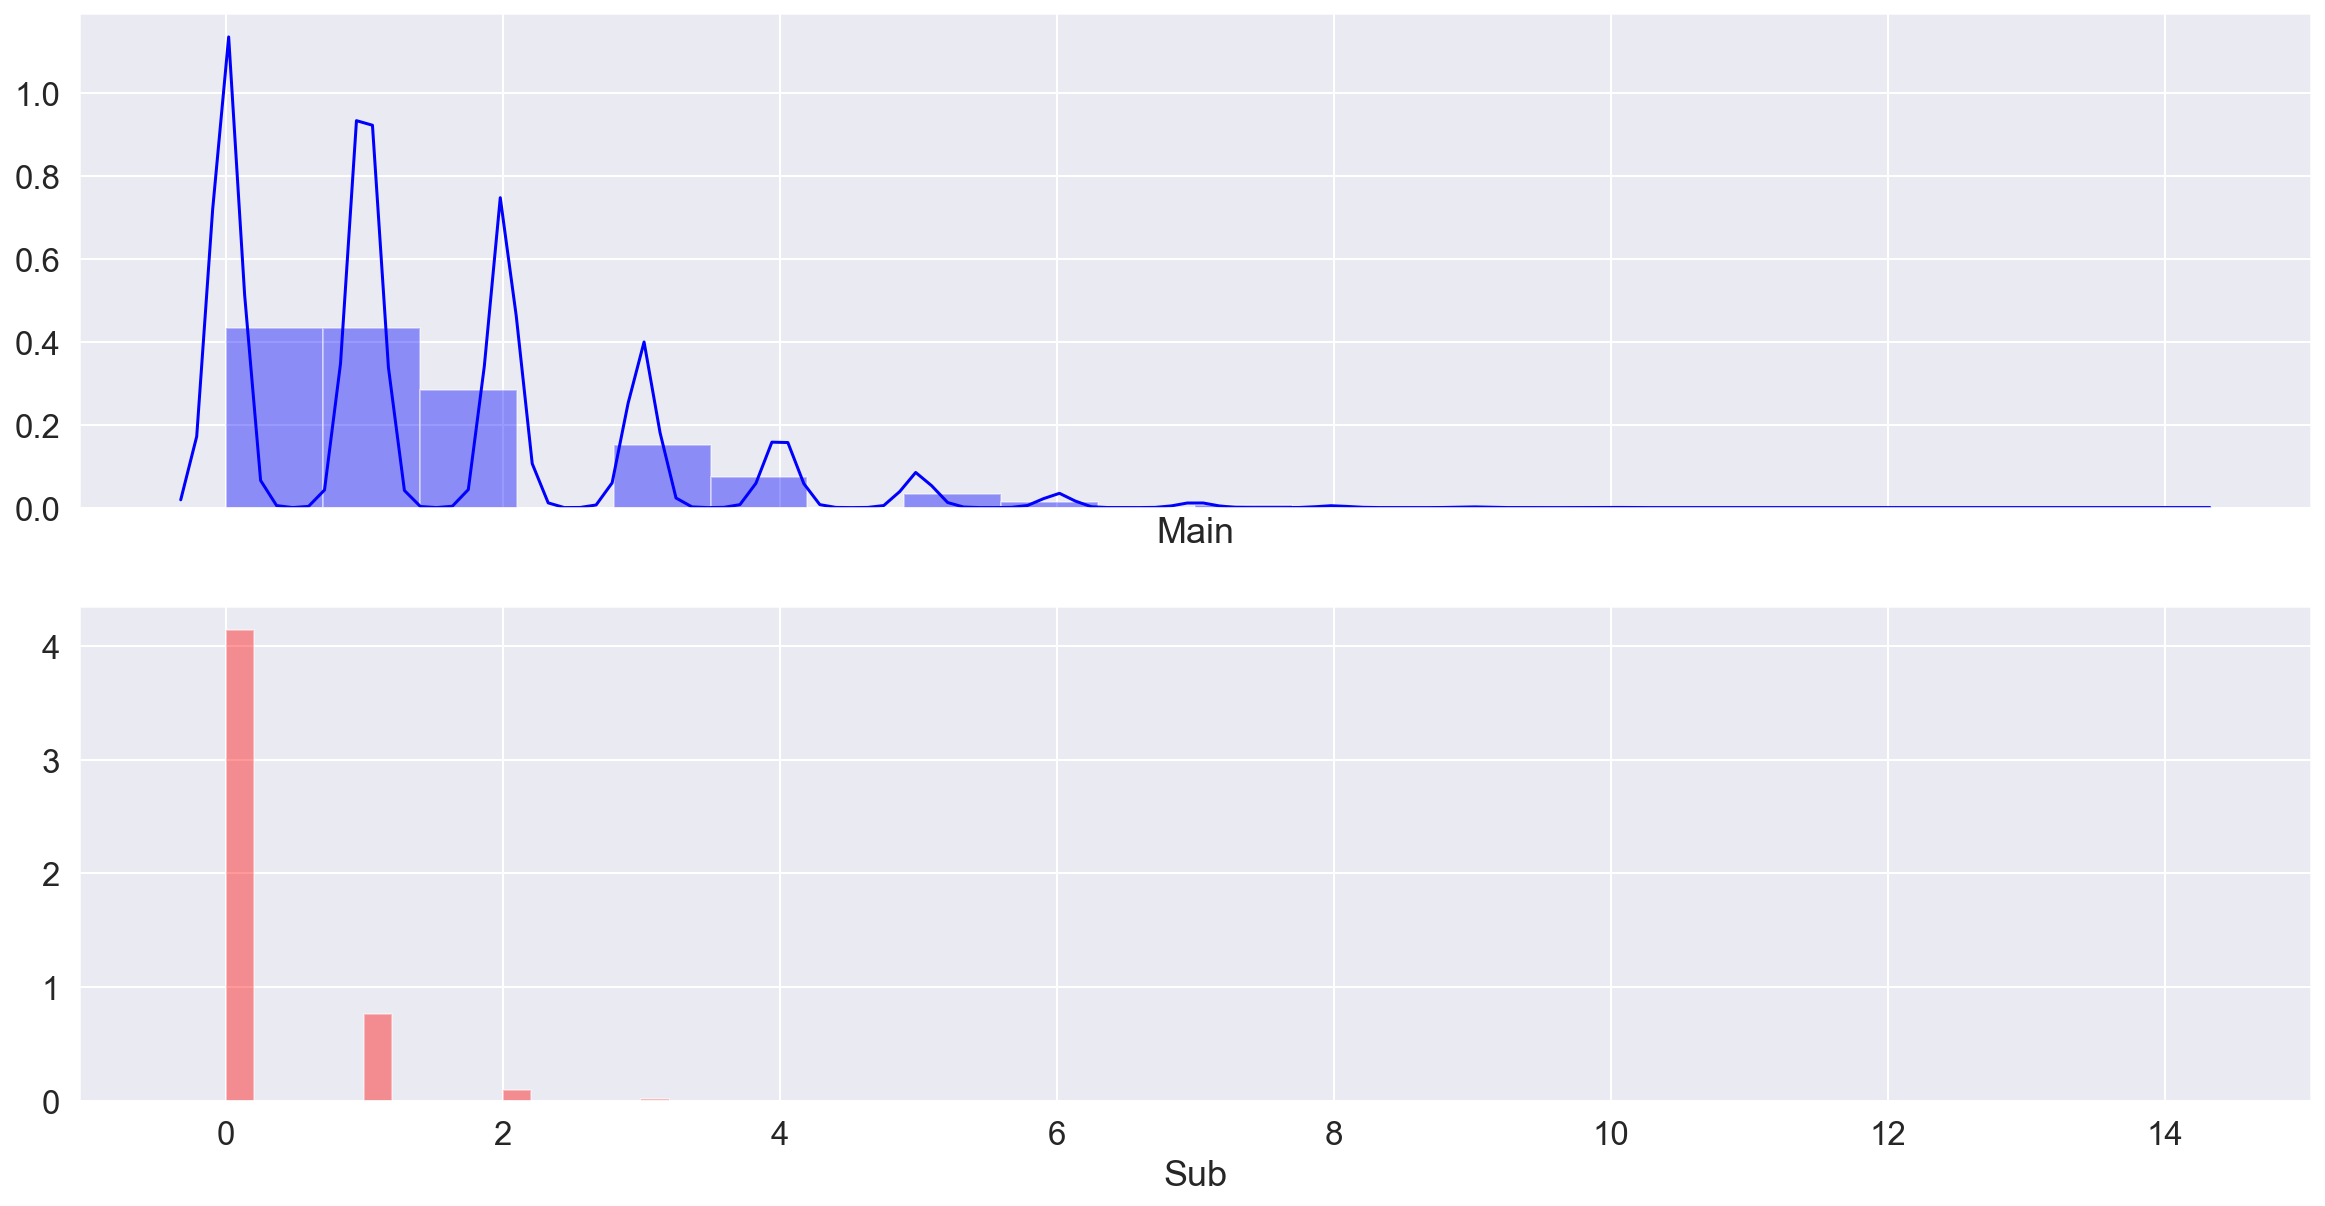

COLUMN : nba_pf 
 Main min 0.00	 Sub min 0.00 
 Main max 7.00	 Sub max 5.00


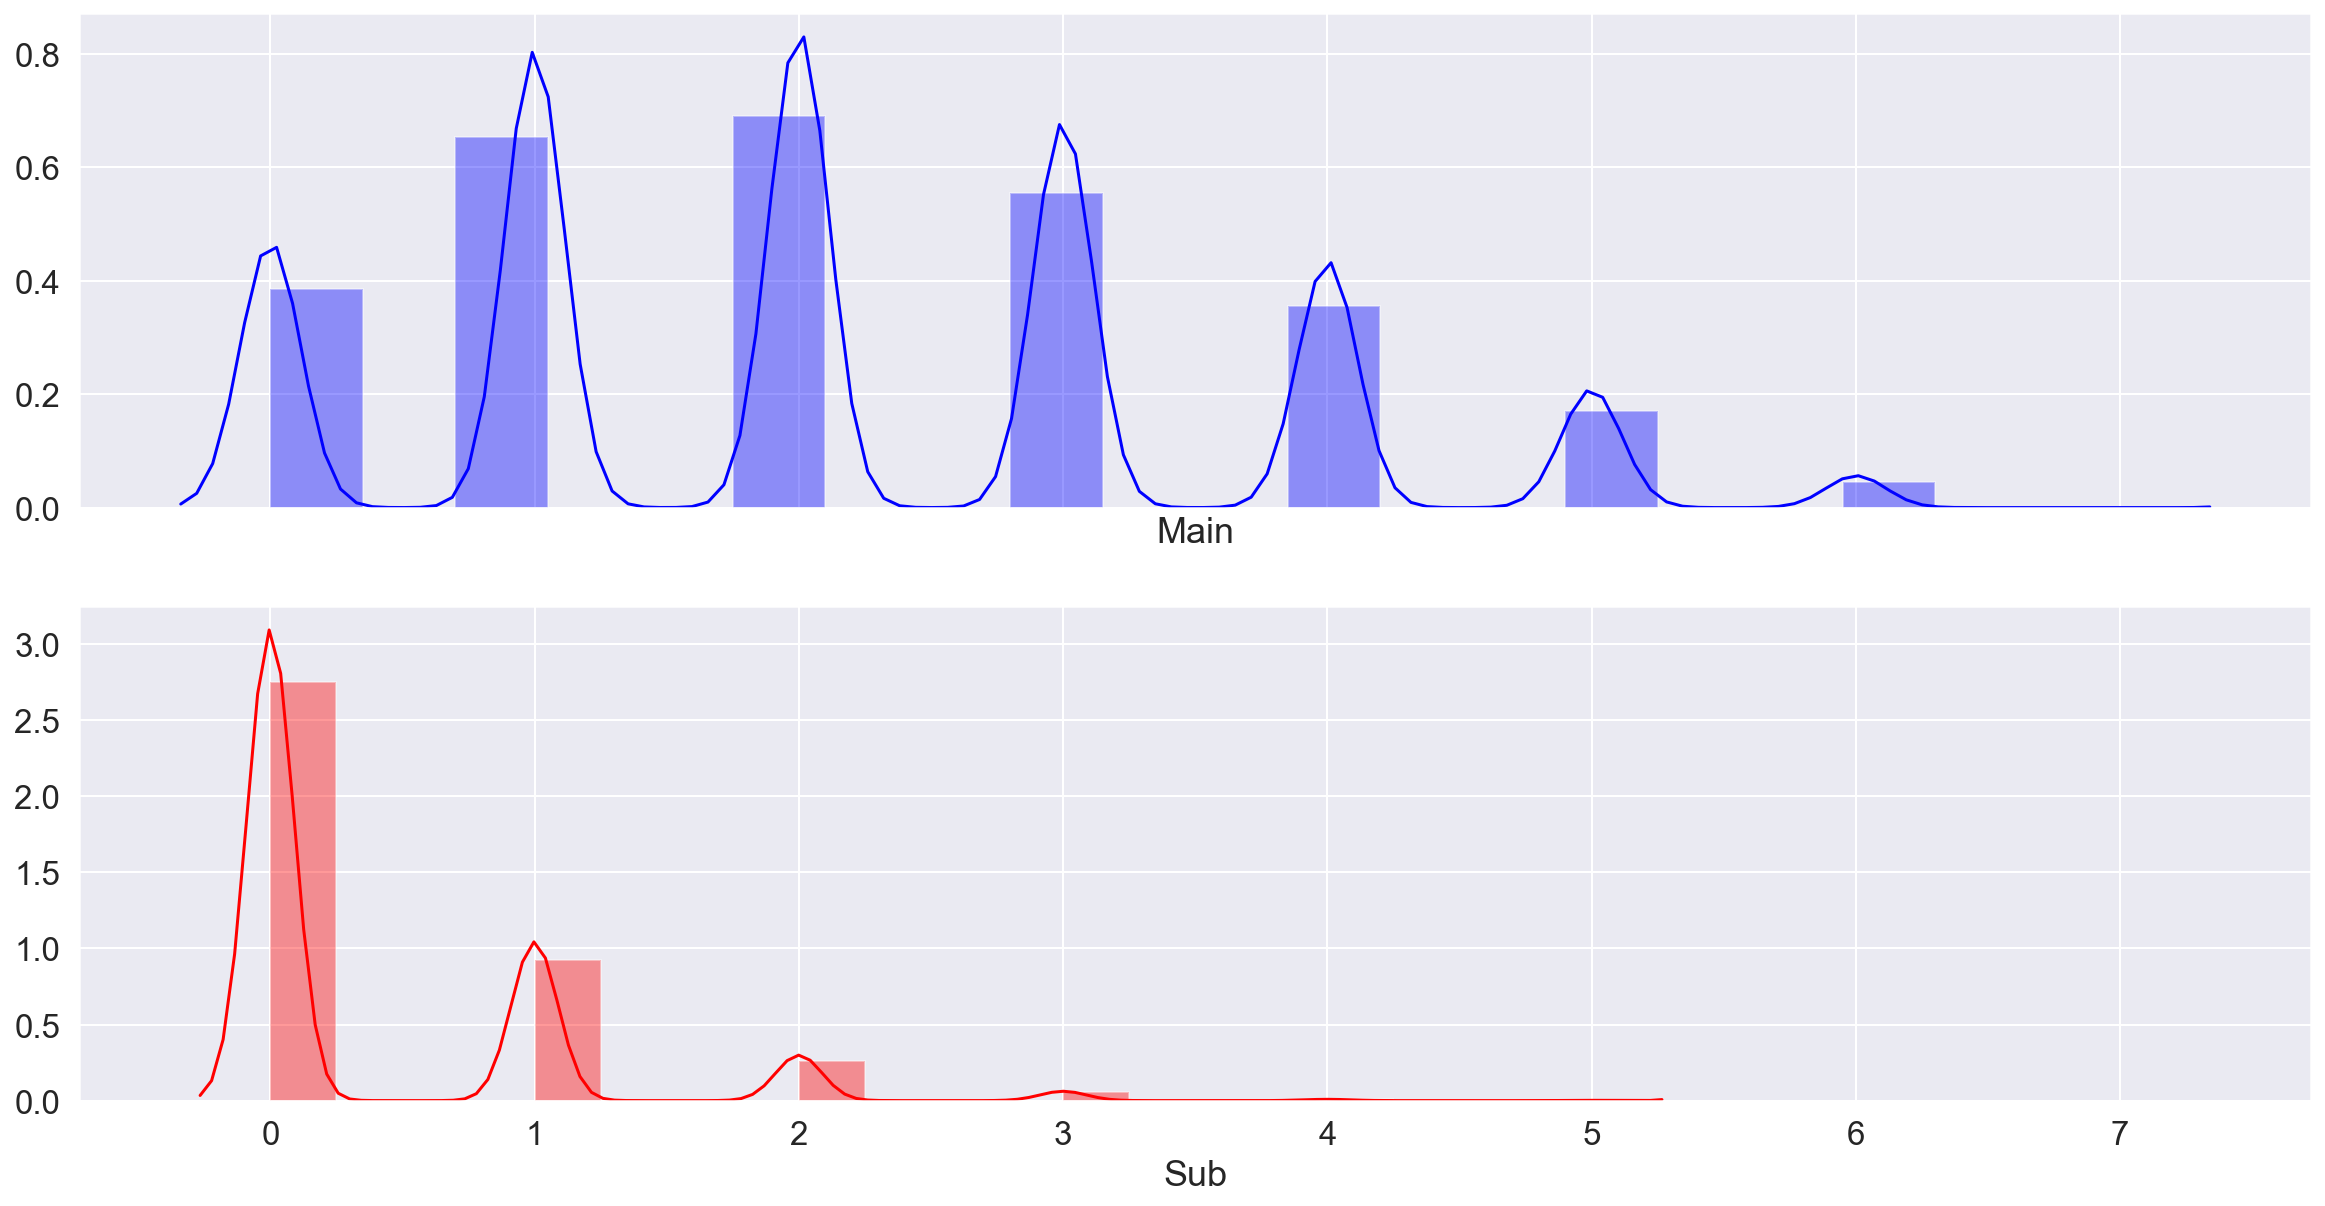

COLUMN : nba_pts 
 Main min 0.00	 Sub min 0.00 
 Main max 81.00	 Sub max 11.00


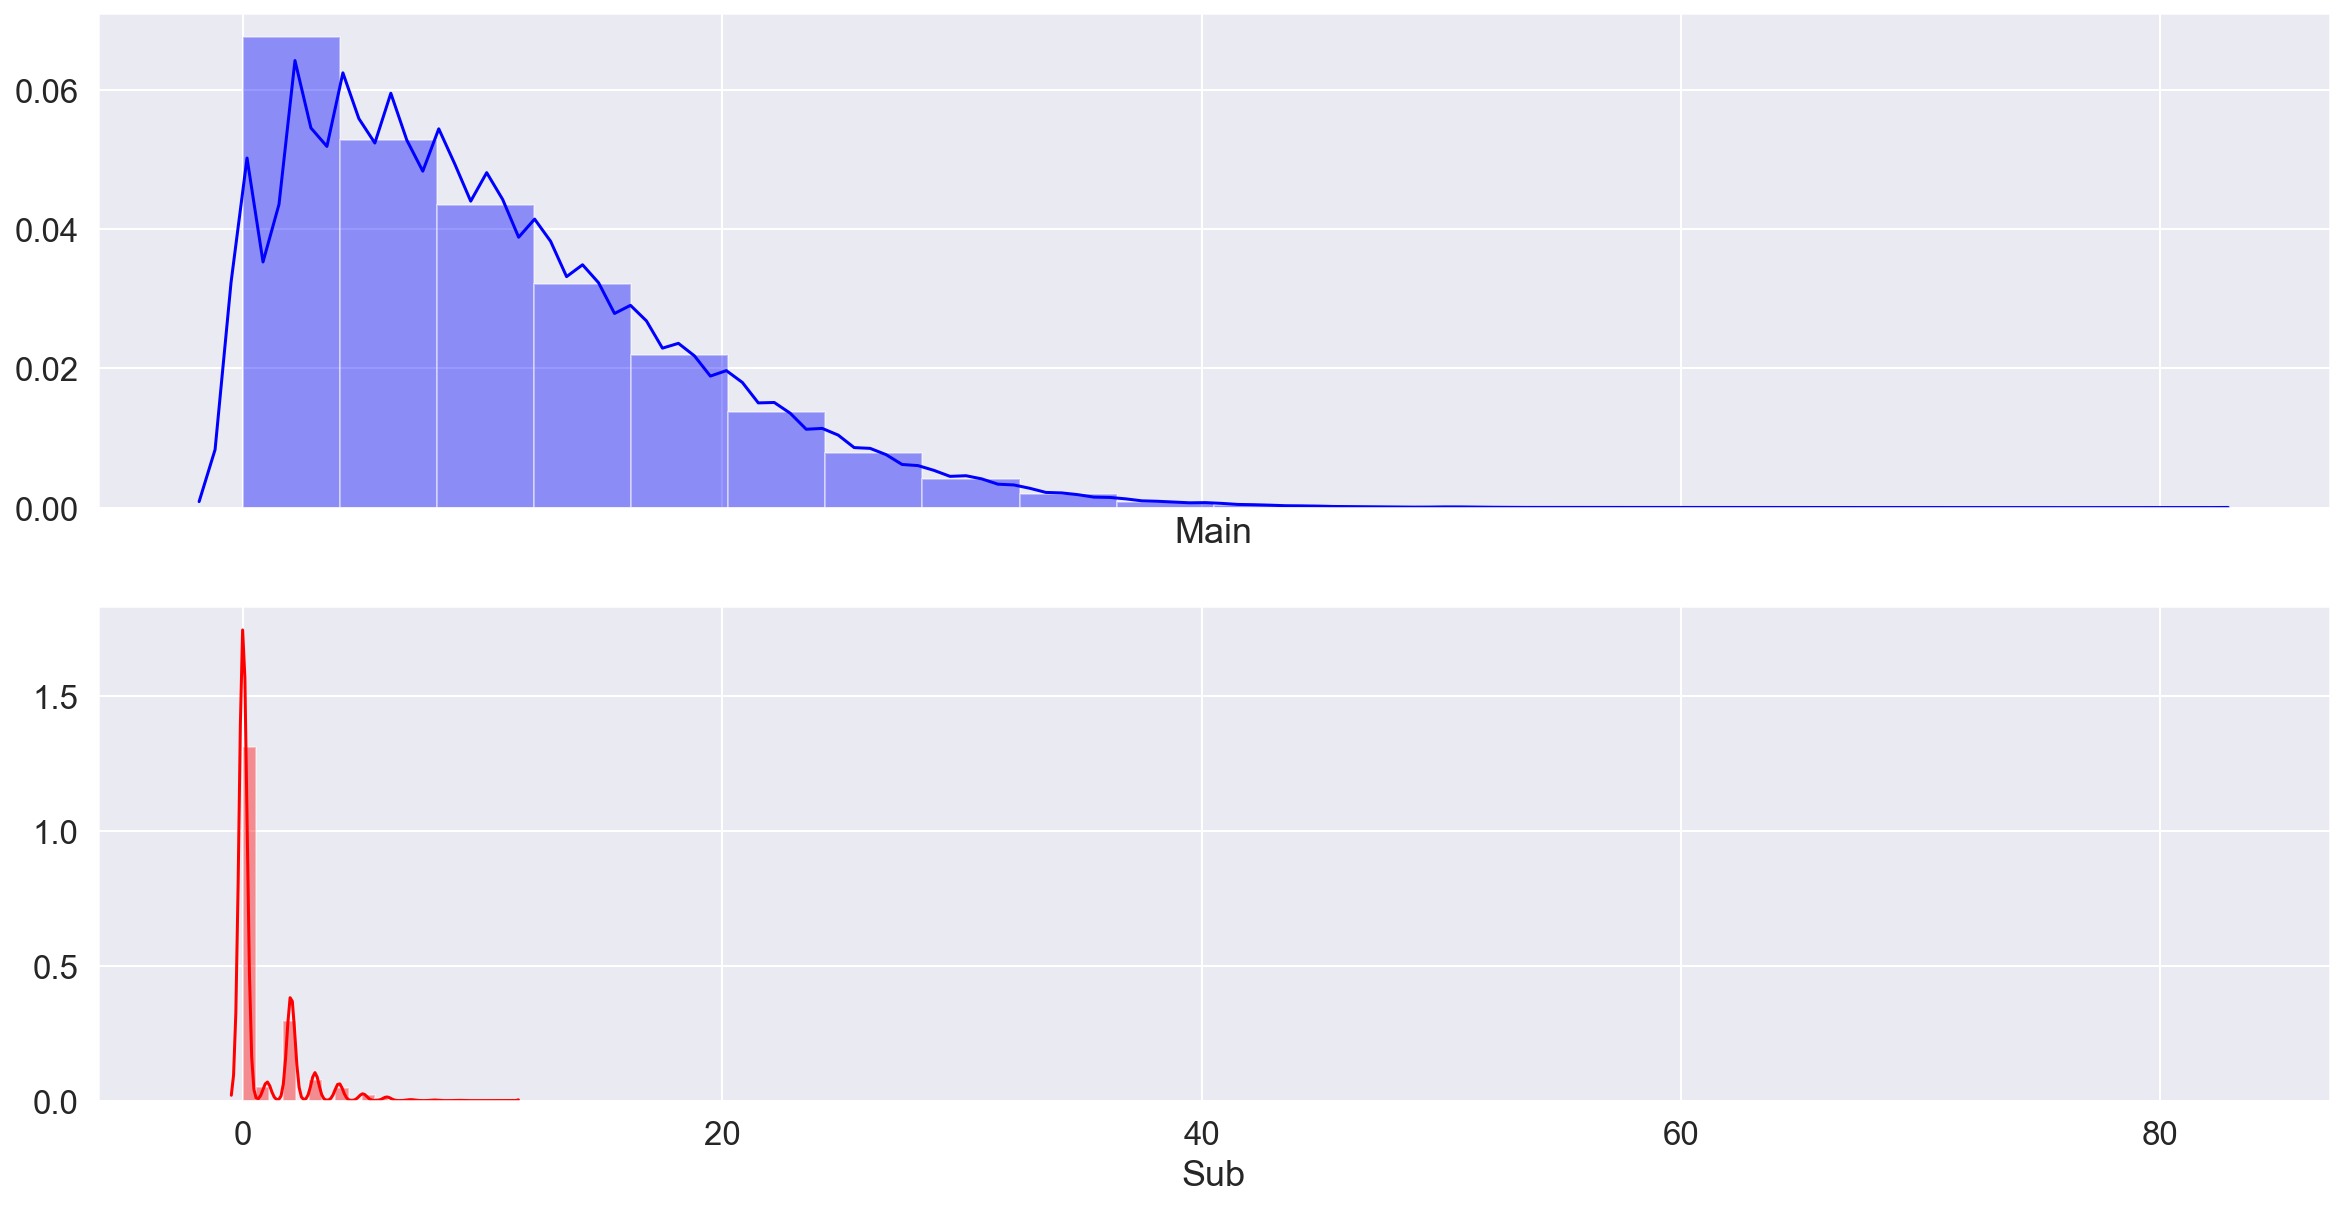

COLUMN : nba_plus_minus 
 Main min -57.00	 Sub min -20.00 
 Main max 57.00	 Sub max 15.00


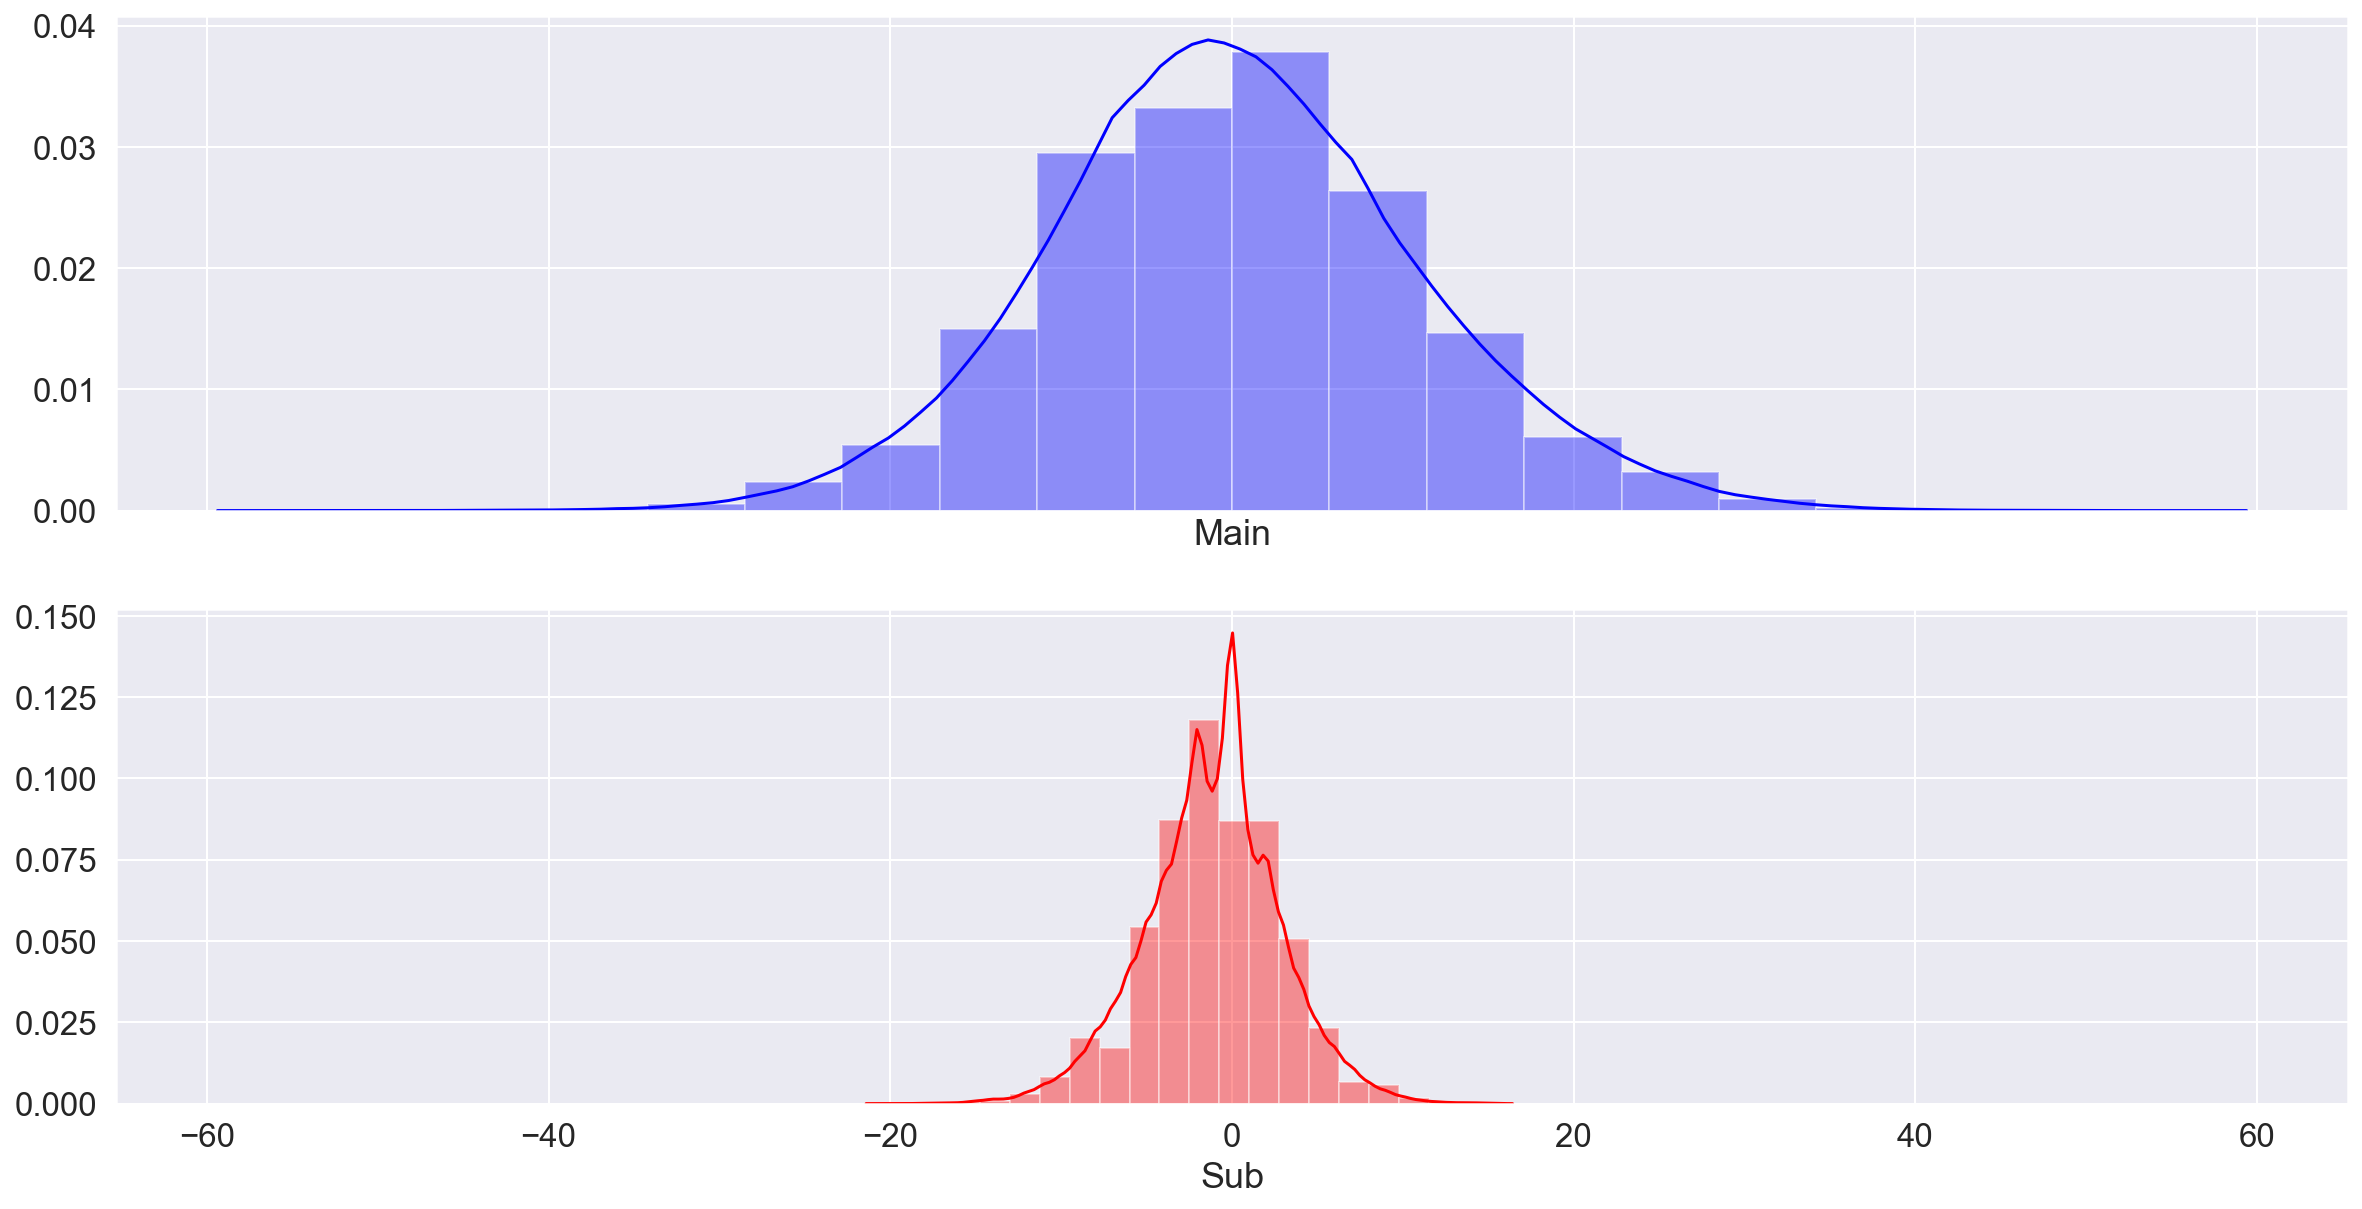

COLUMN : nba_height 
 Main min 1.60	 Sub min 1.65 
 Main max 2.31	 Sub max 2.31


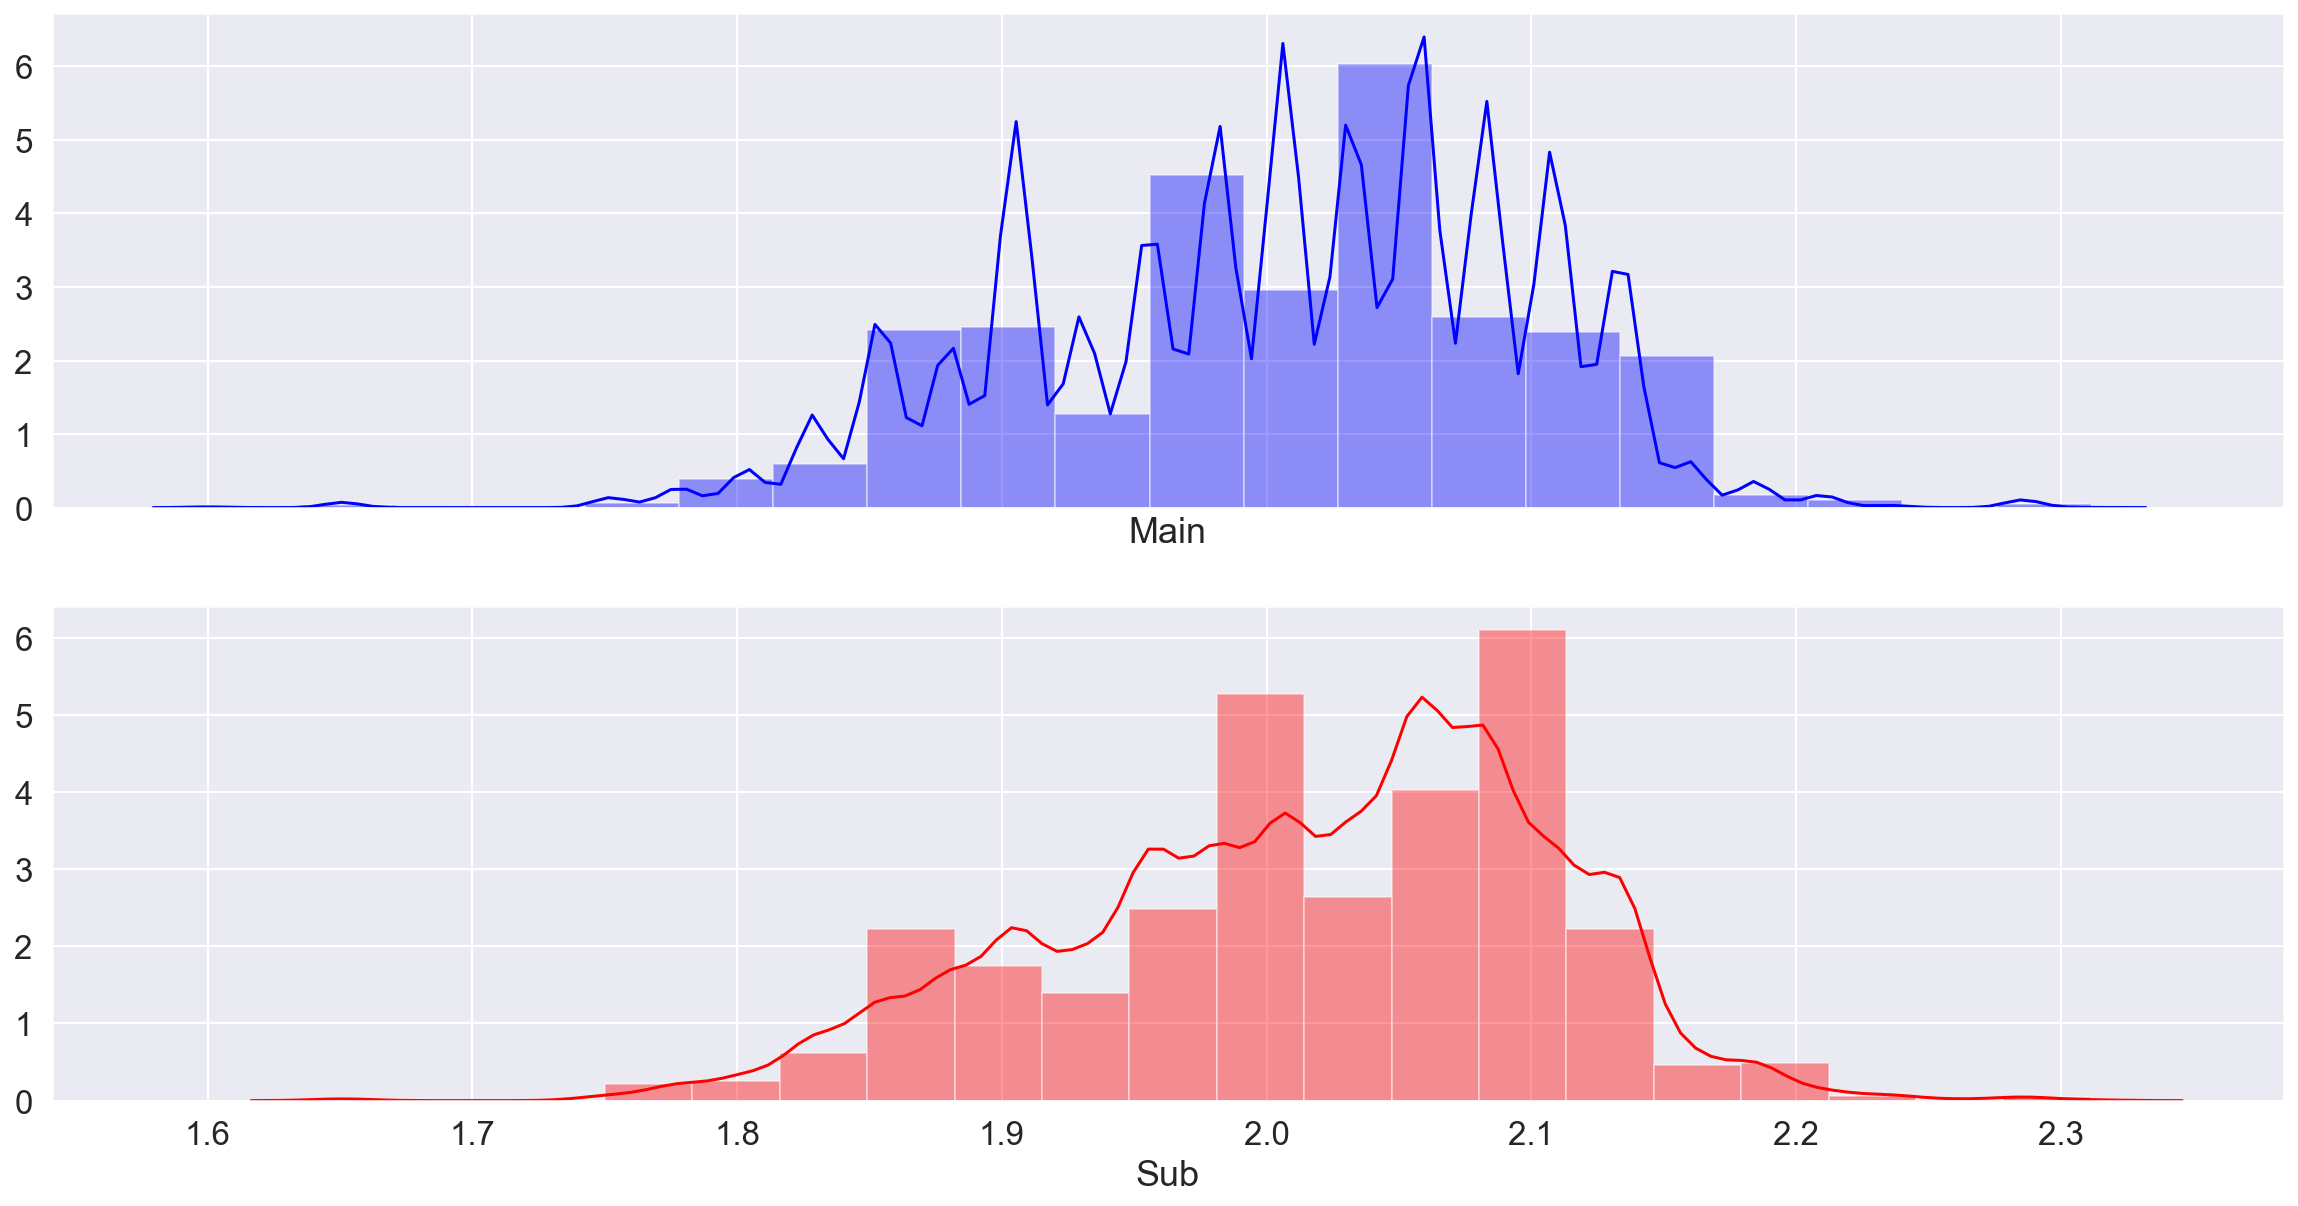

COLUMN : nba_e_off_rating 
 Main min 0.00	 Sub min -1666.70 
 Main max 237.60	 Sub max 568.20


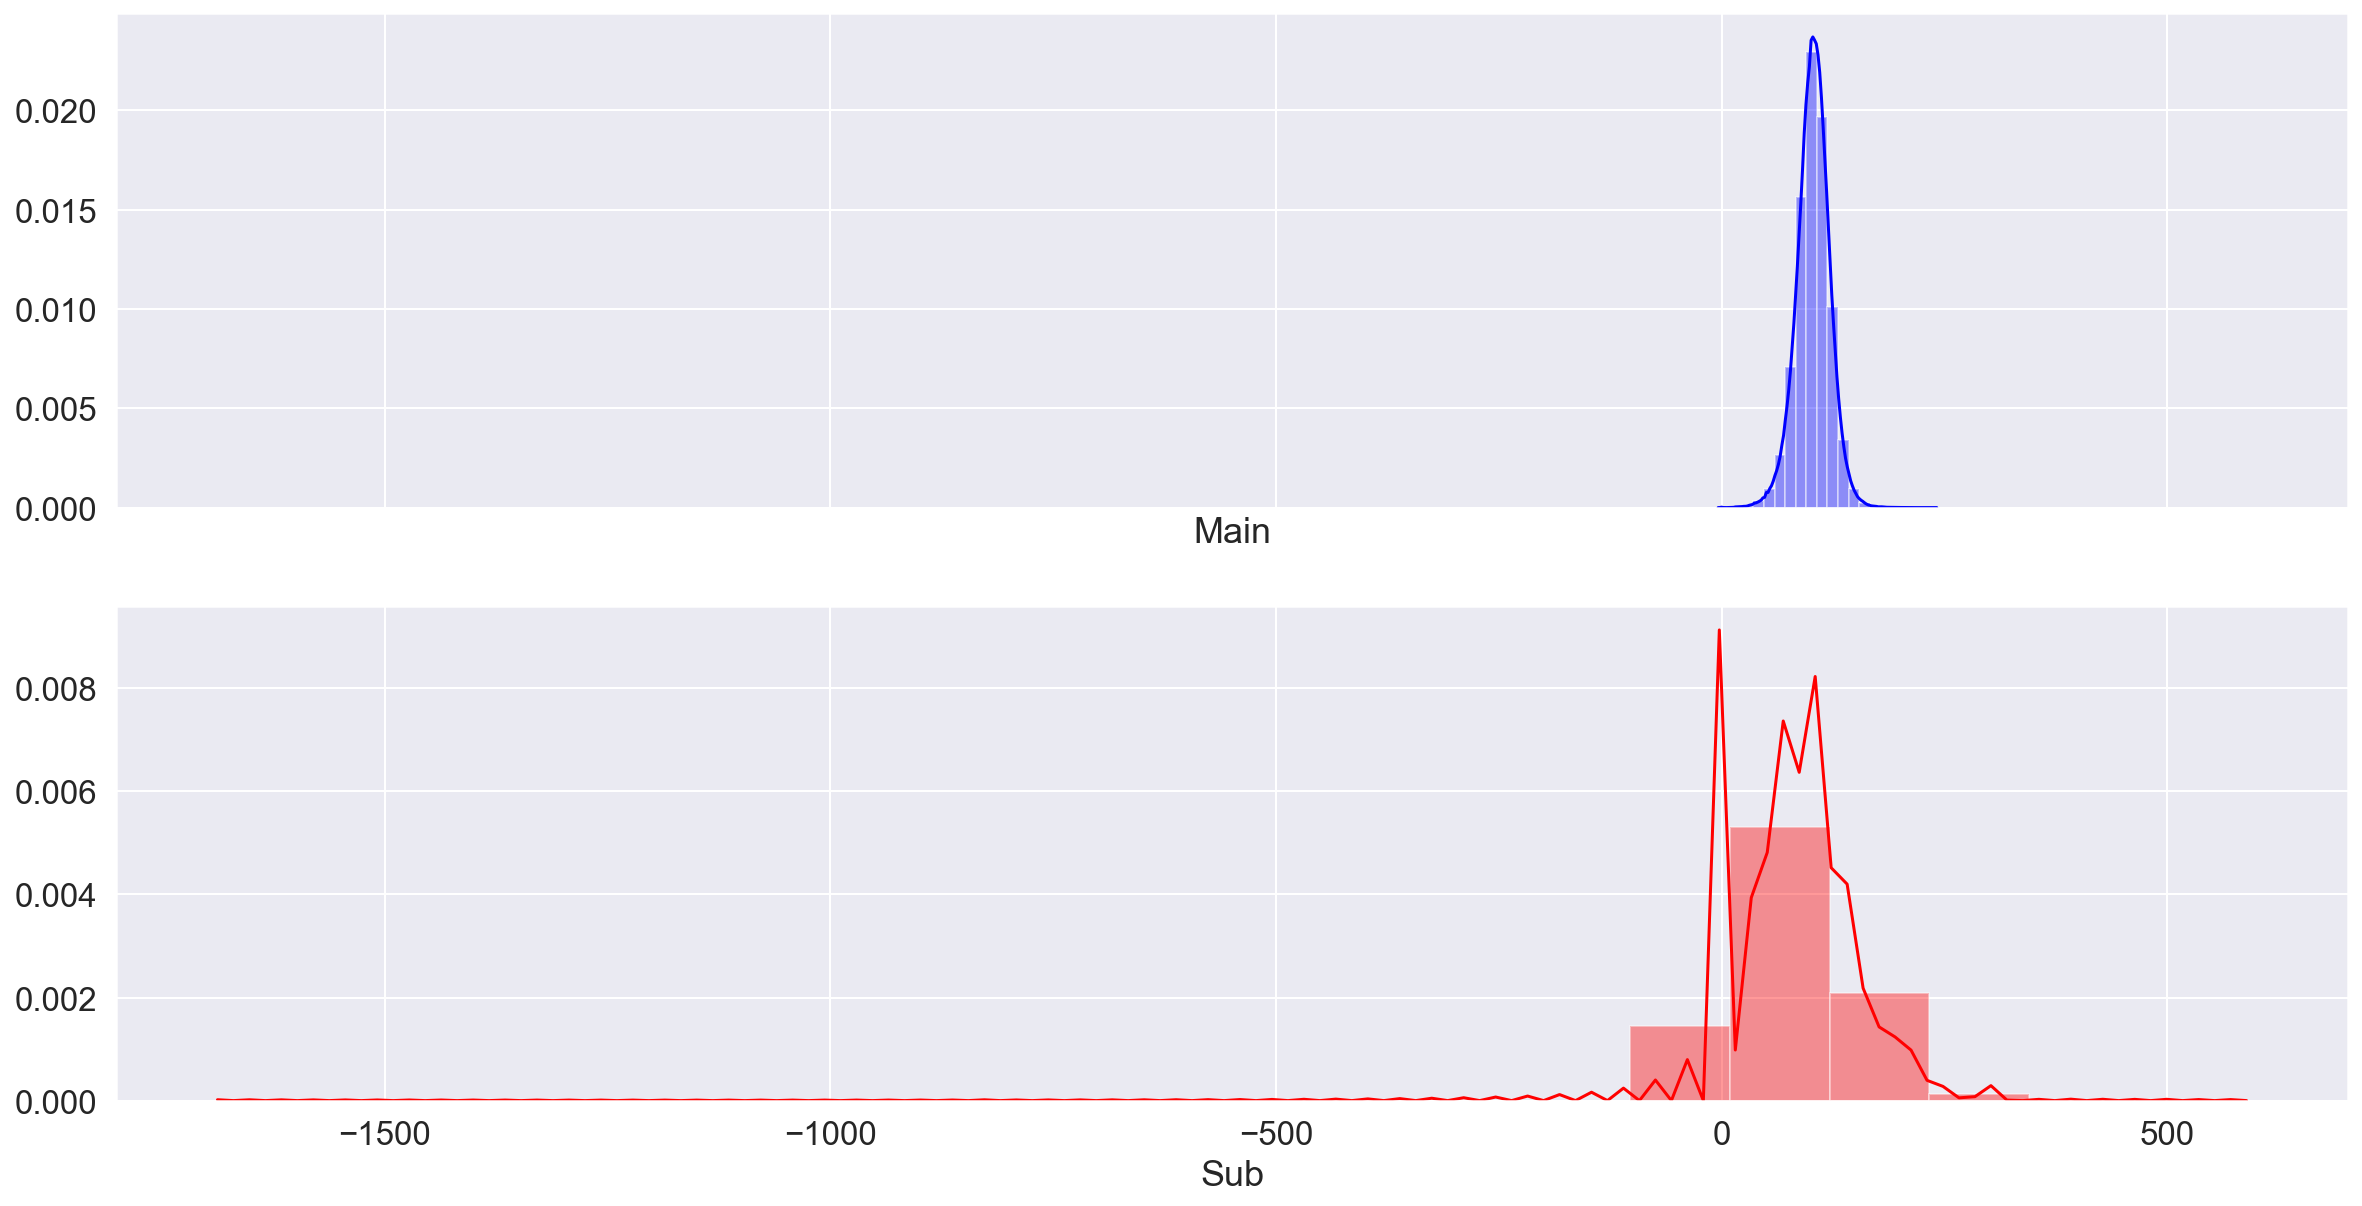

COLUMN : nba_off_rating 
 Main min 0.00	 Sub min 0.00 
 Main max 227.30	 Sub max 500.00


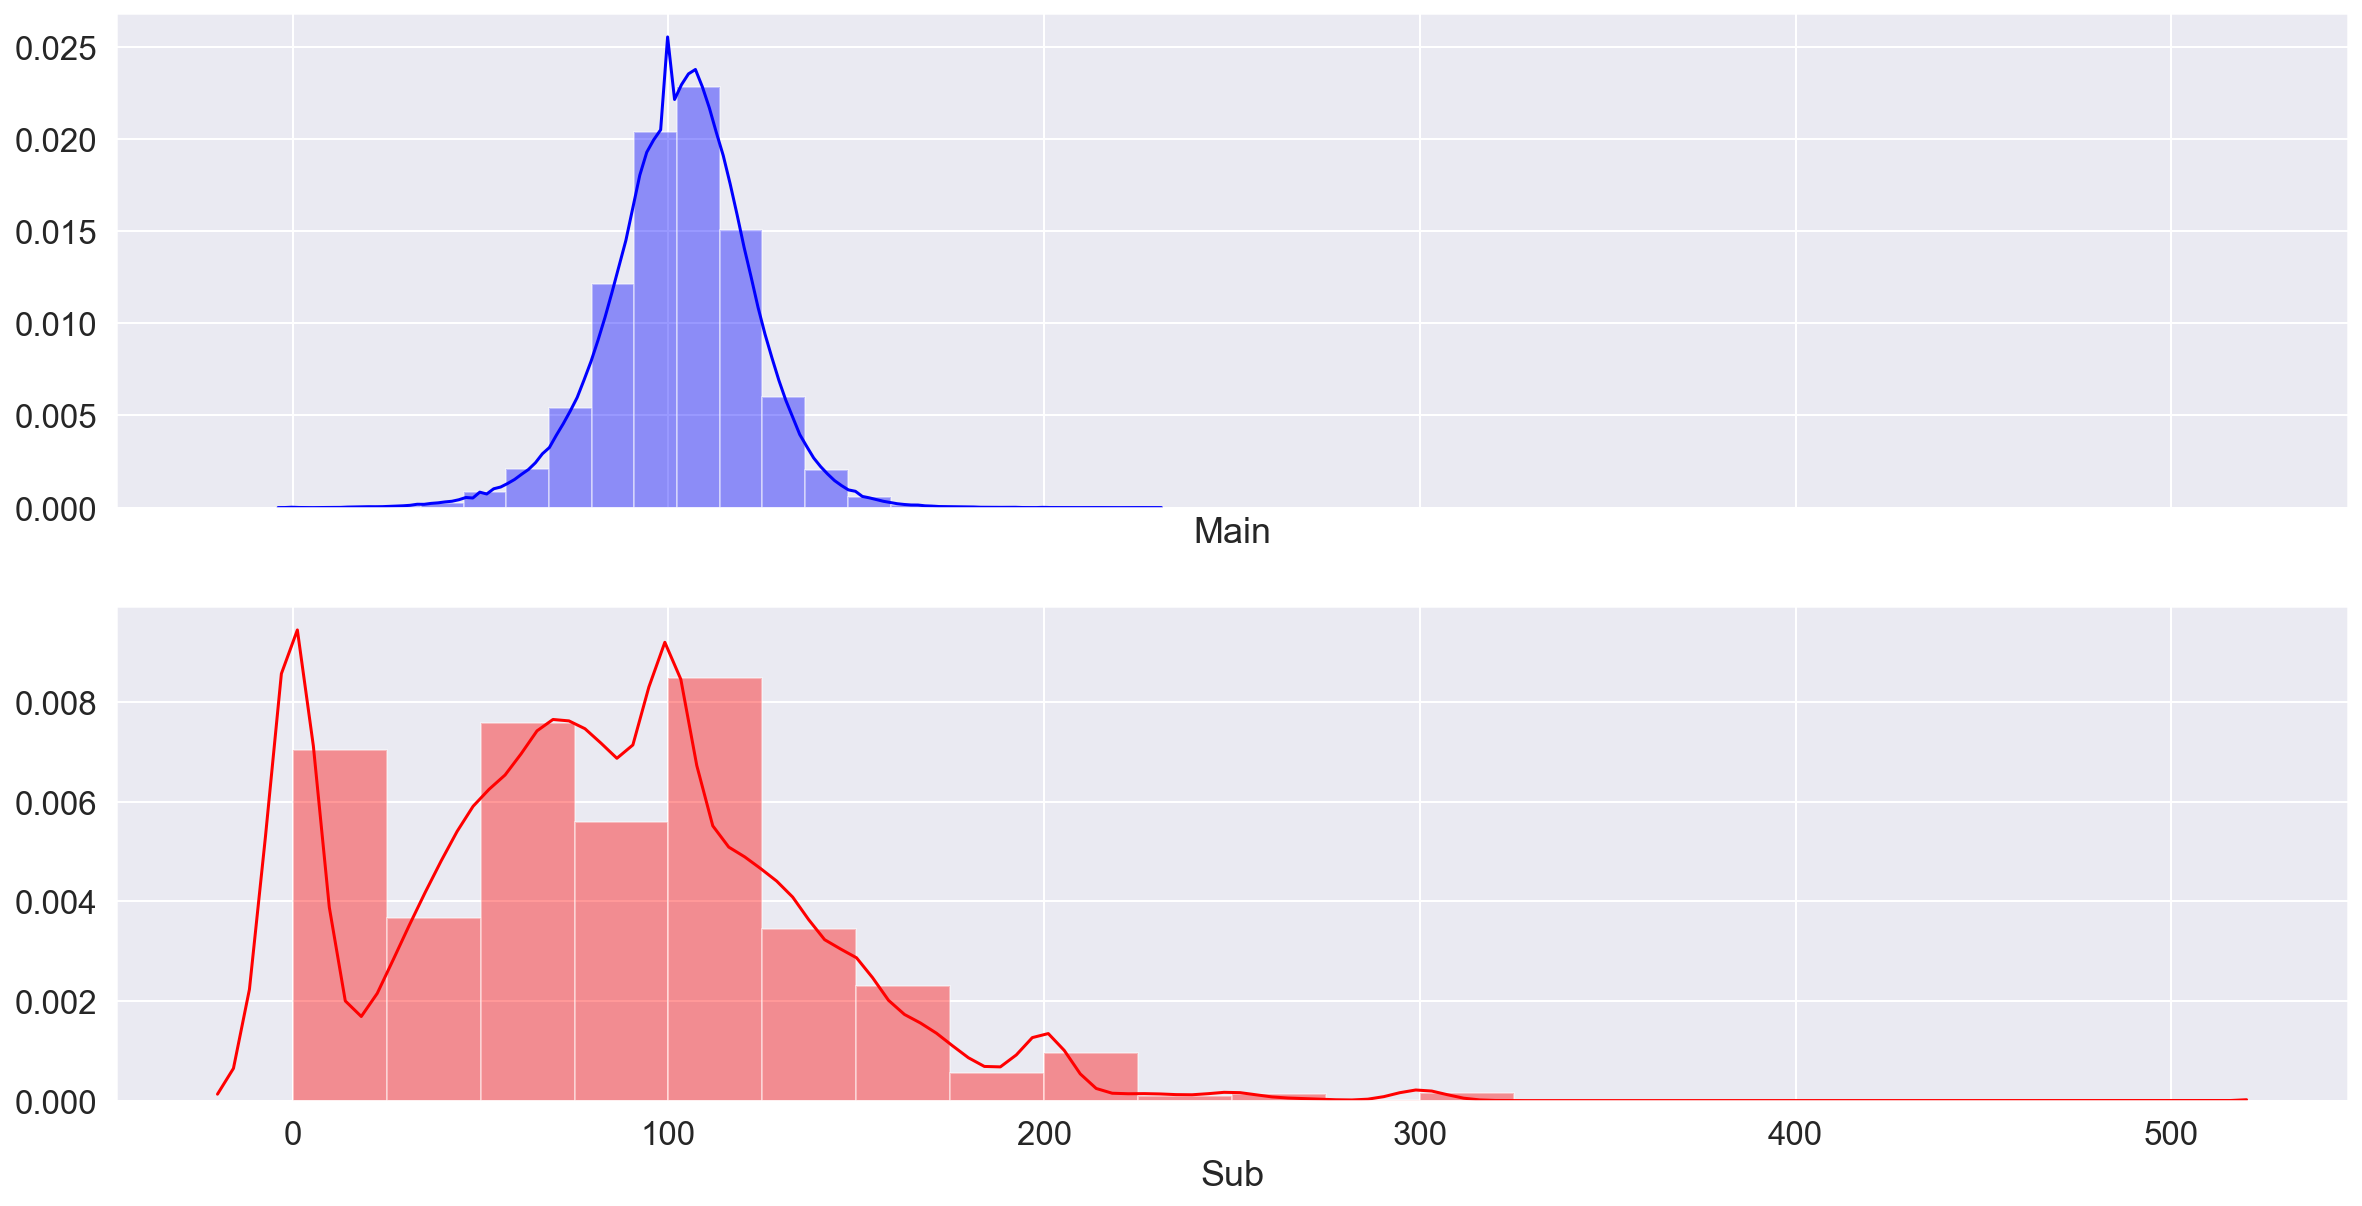

COLUMN : nba_e_def_rating 
 Main min 0.00	 Sub min -833.30 
 Main max 237.50	 Sub max 600.00


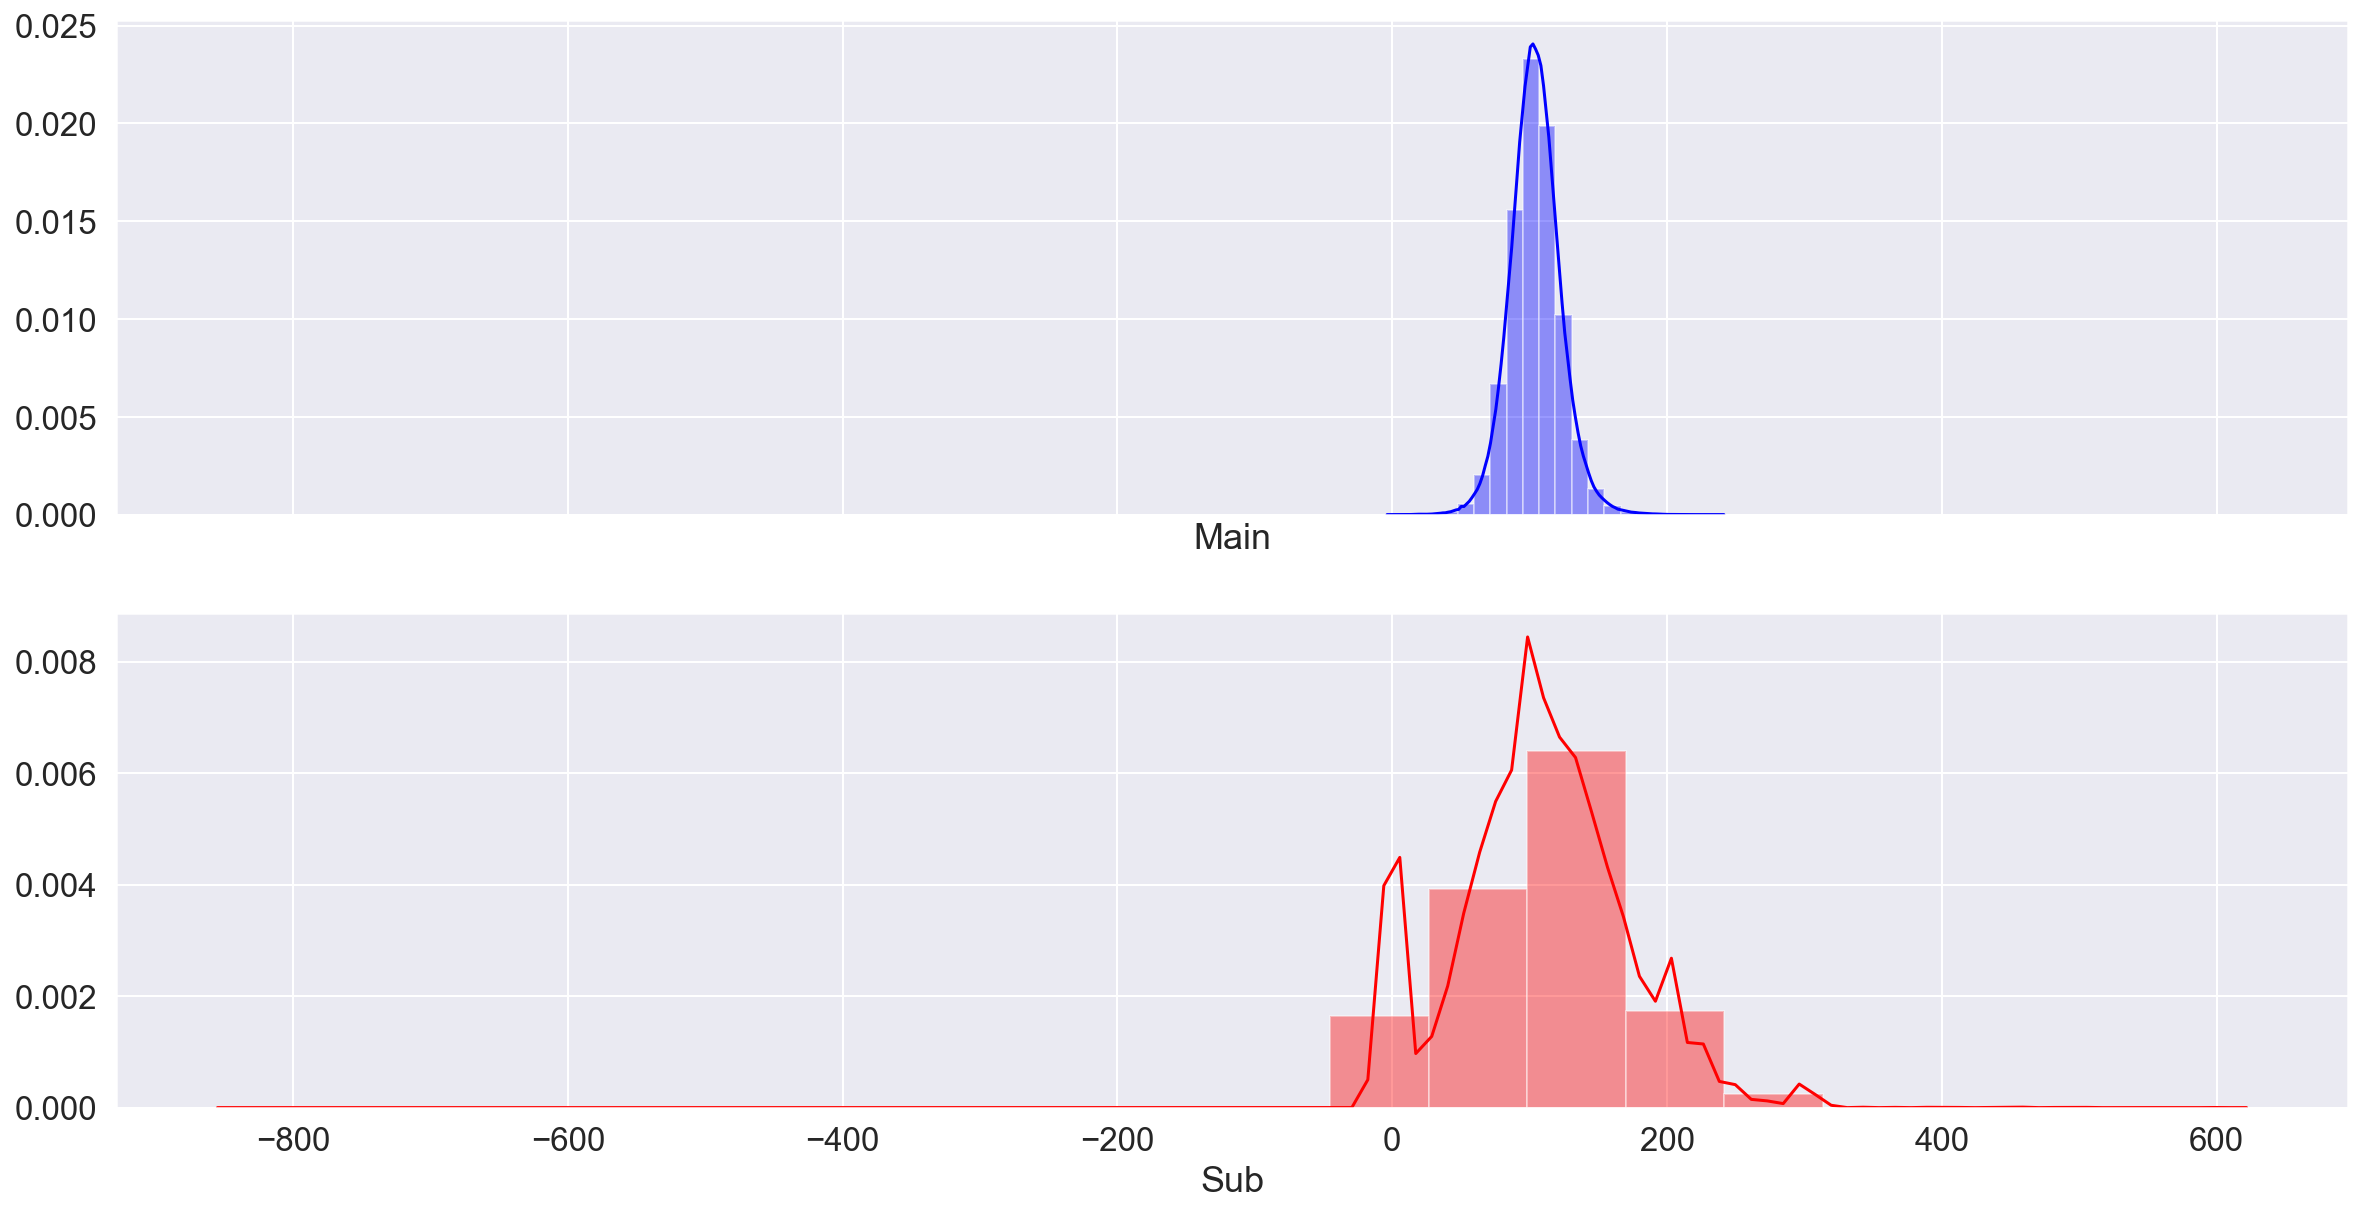

COLUMN : nba_def_rating 
 Main min 0.00	 Sub min 0.00 
 Main max 244.40	 Sub max 500.00


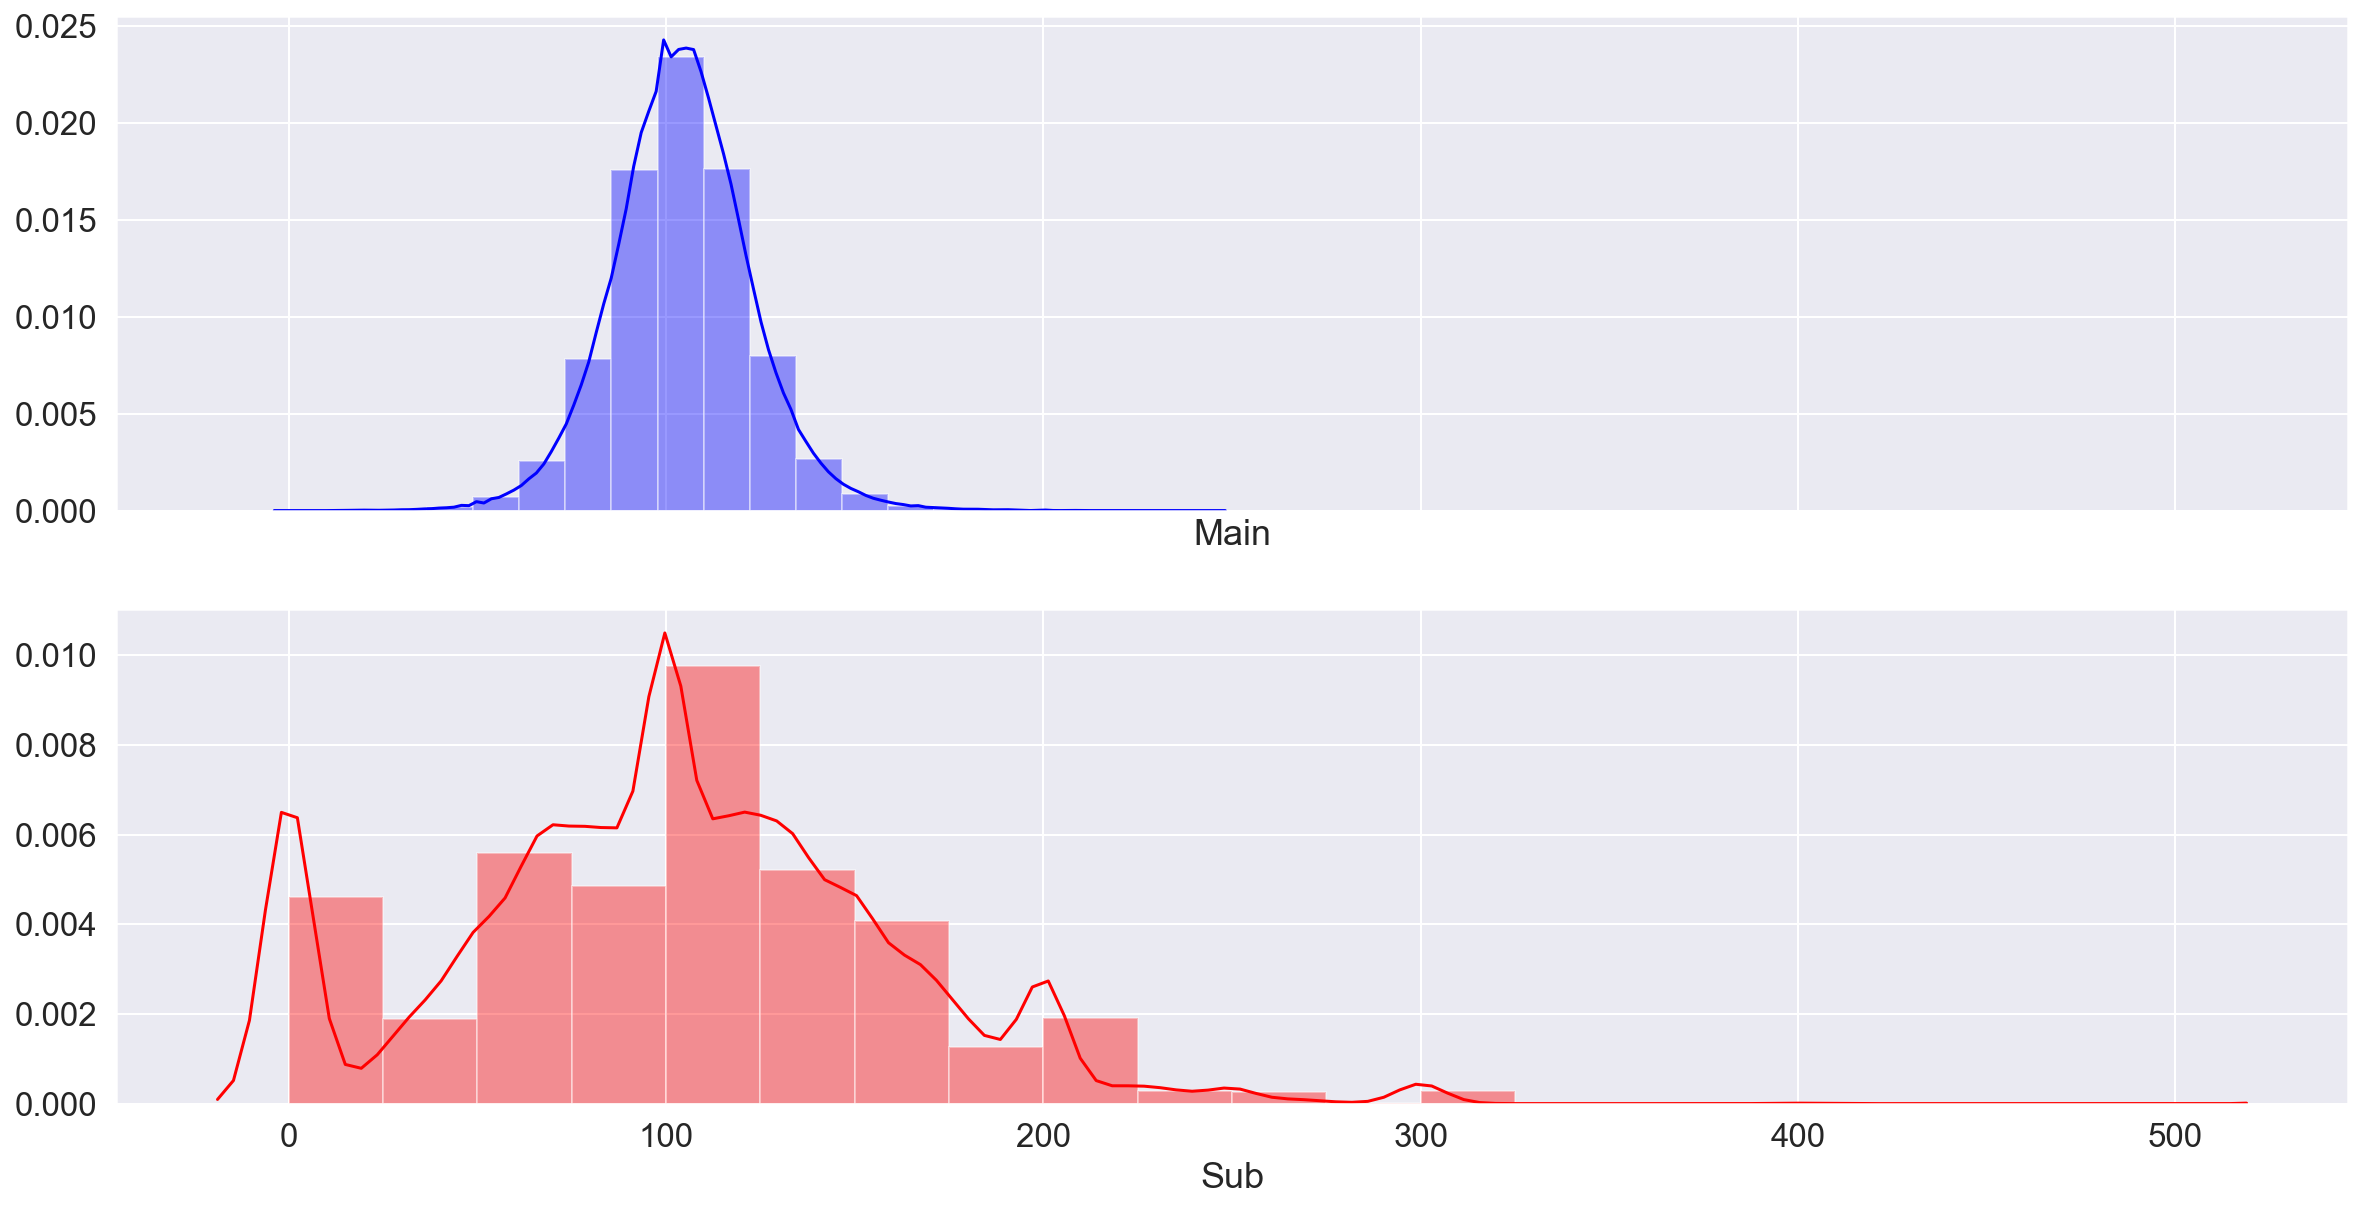

COLUMN : nba_e_net_rating 
 Main min -176.50	 Sub min -1866.70 
 Main max 173.70	 Sub max 1133.30


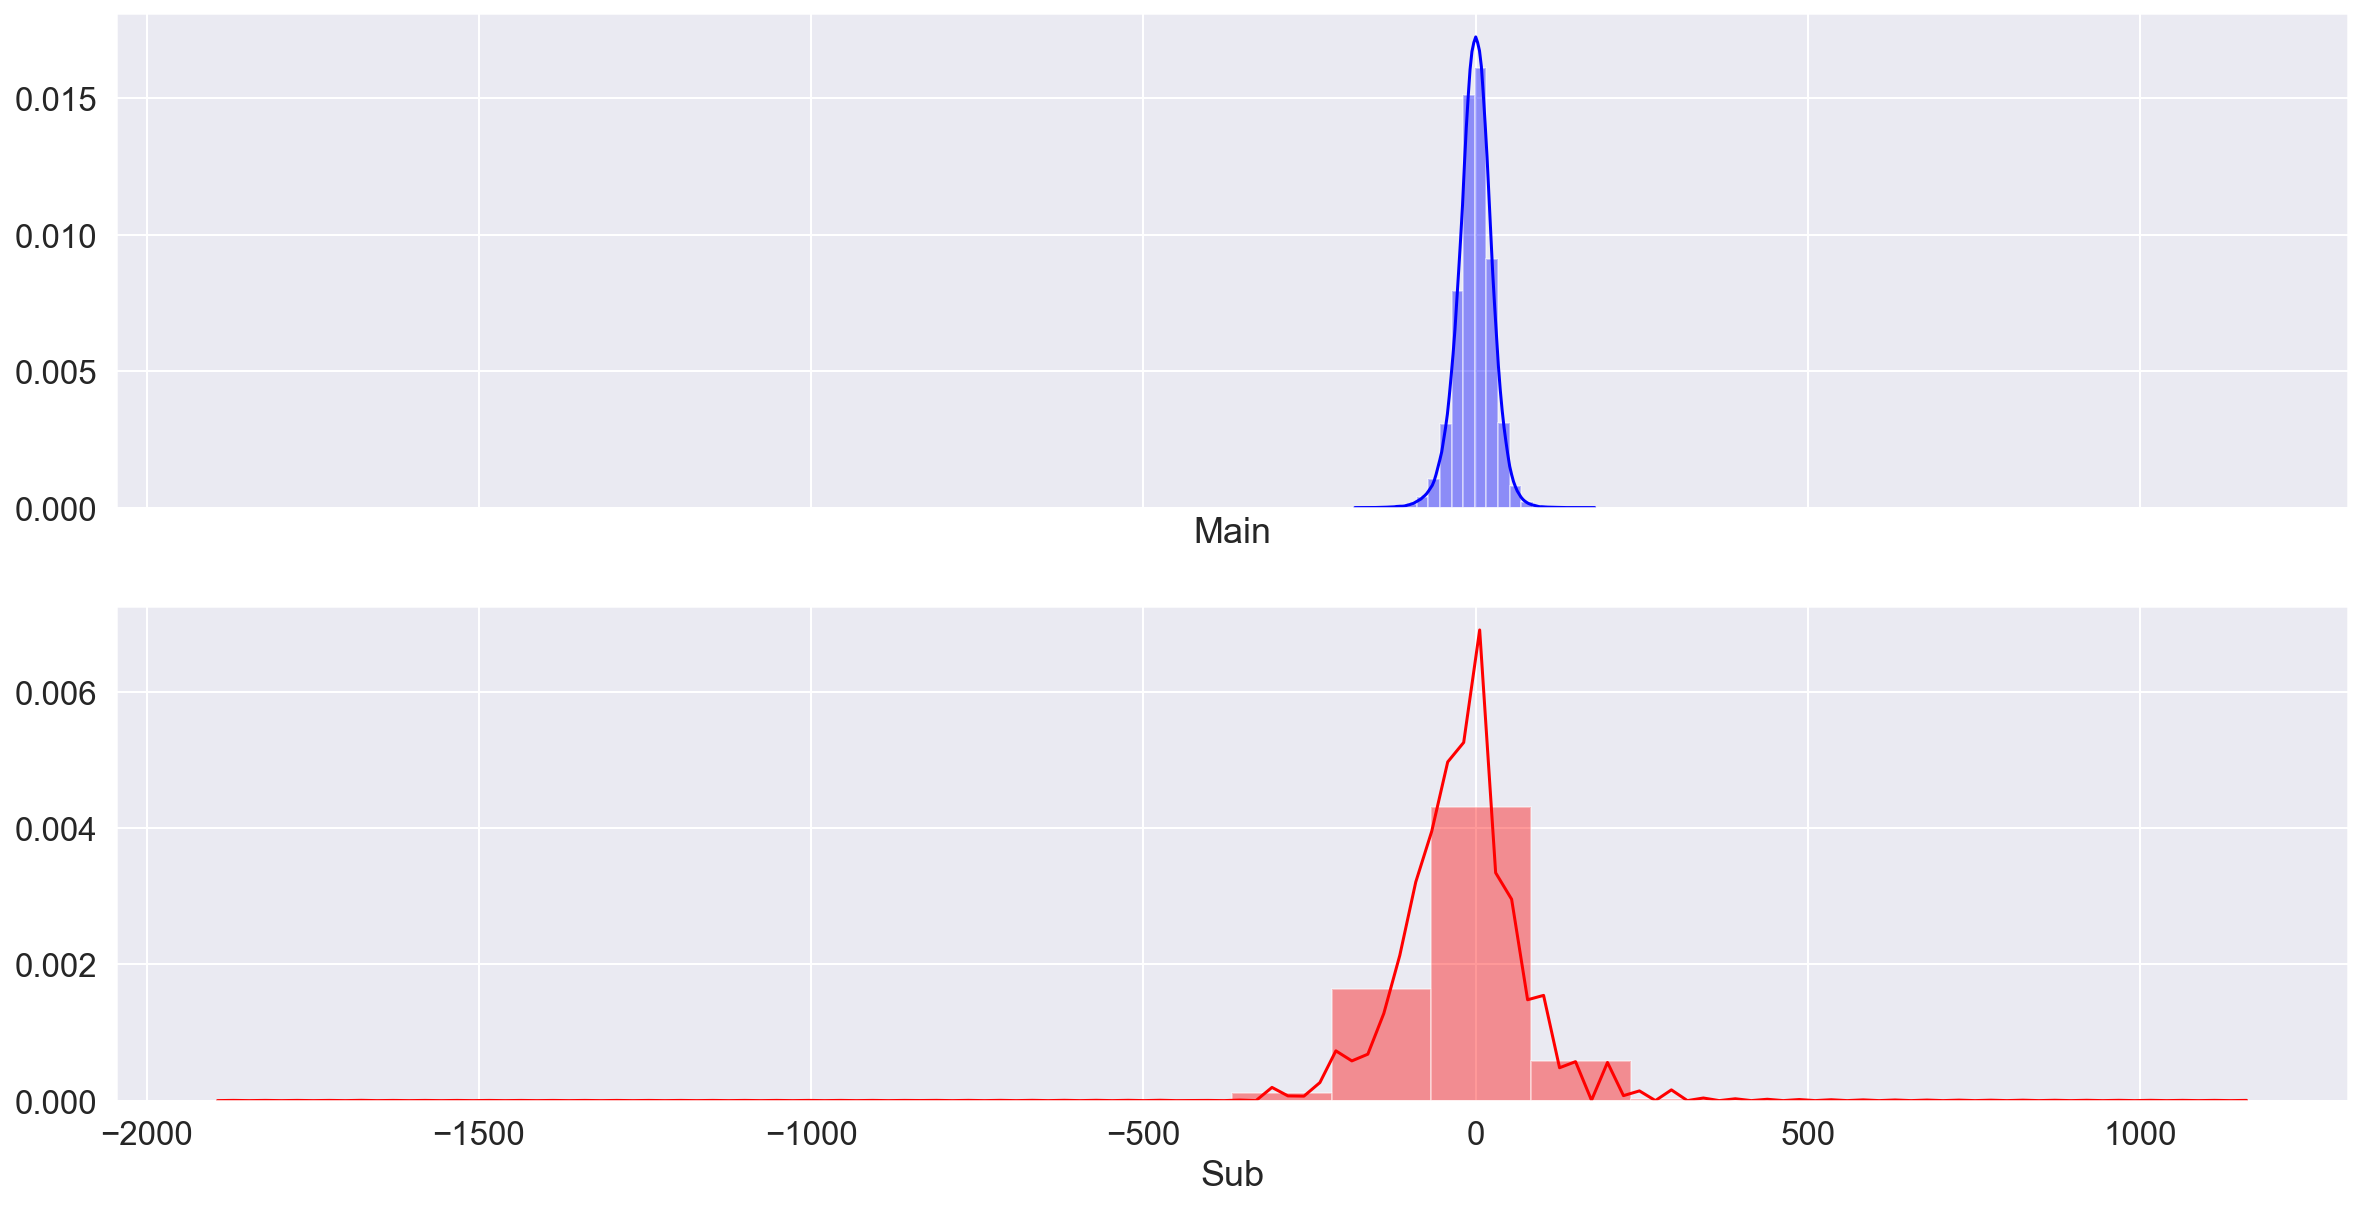

COLUMN : nba_net_rating 
 Main min -180.00	 Sub min -500.00 
 Main max 171.80	 Sub max 500.00


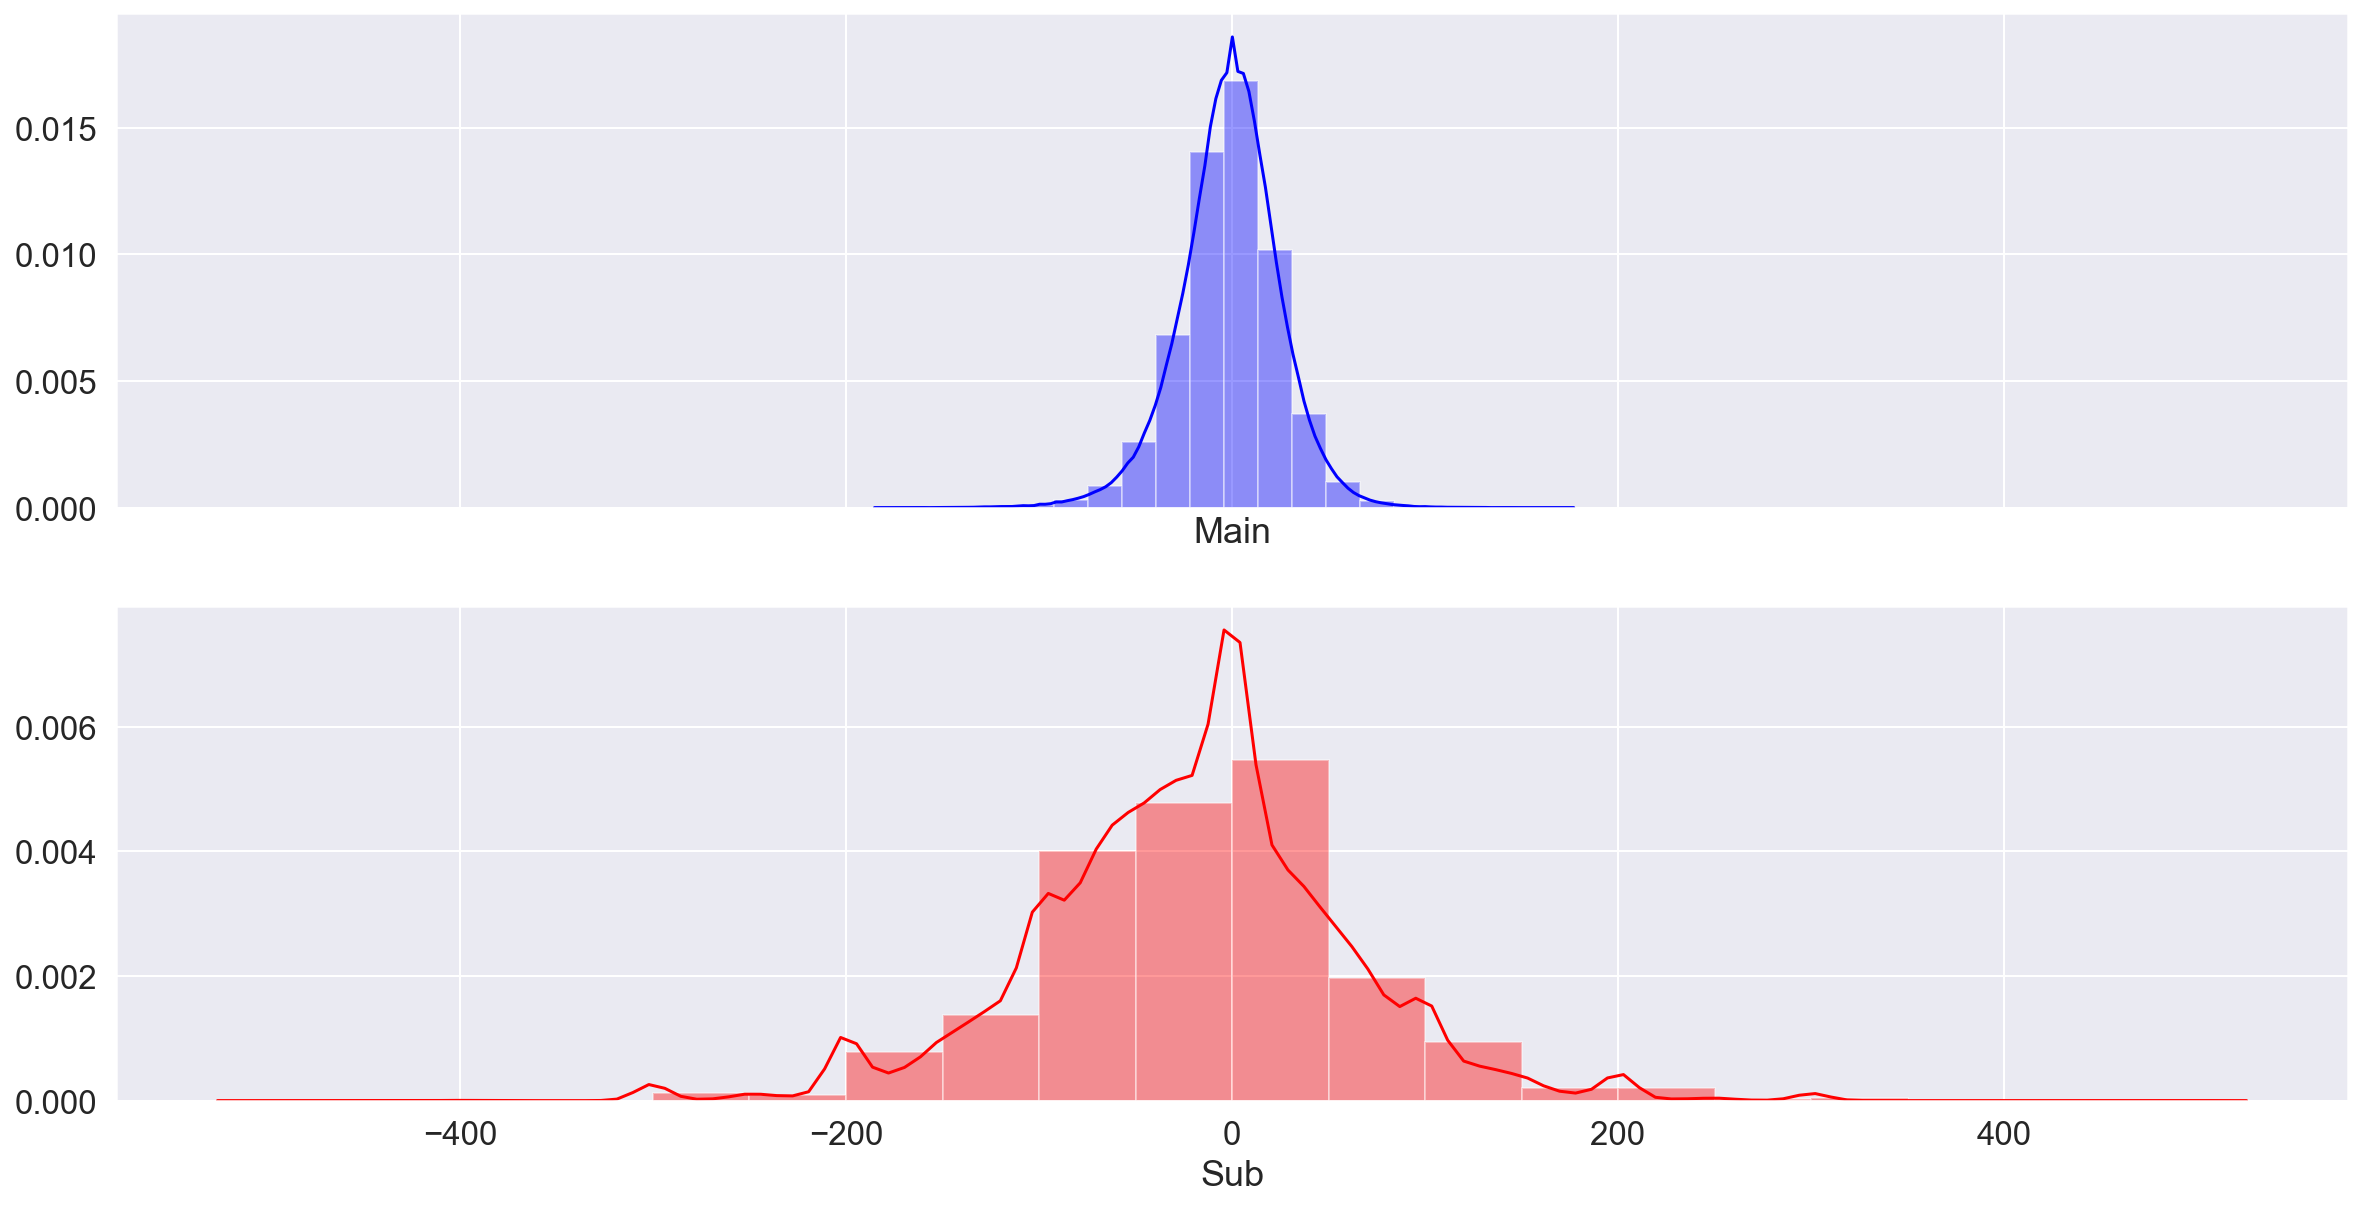

COLUMN : nba_ast_pct 
 Main min 0.00	 Sub min 0.00 
 Main max 1.00	 Sub max 1.00


/Users/finnalexander/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


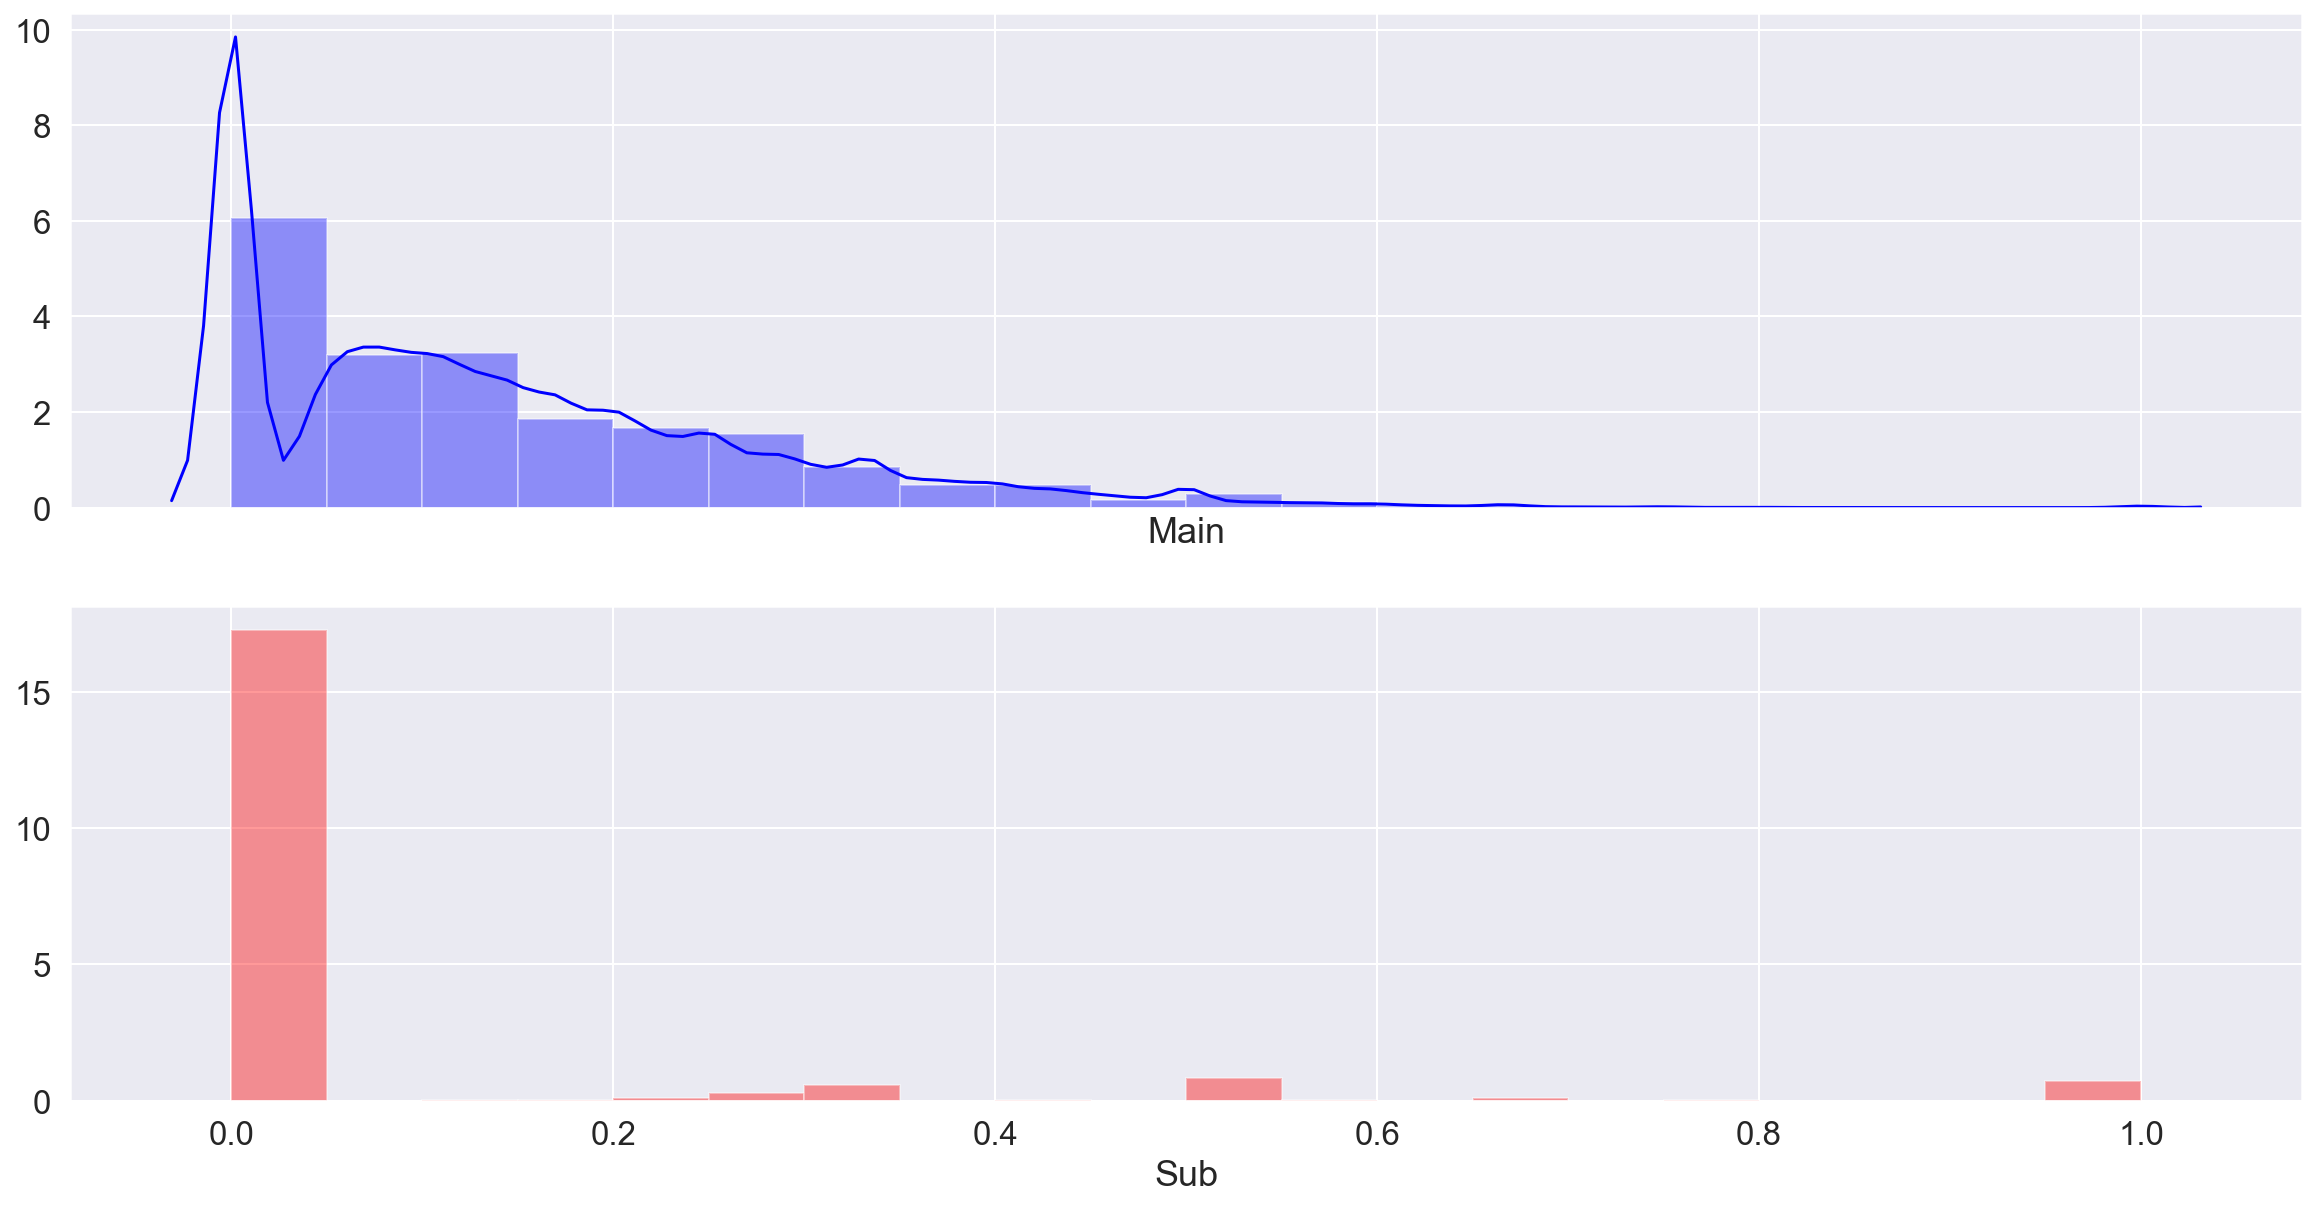

COLUMN : nba_ast_tov 
 Main min 0.00	 Sub min 0.00 
 Main max 21.00	 Sub max 4.00


/Users/finnalexander/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


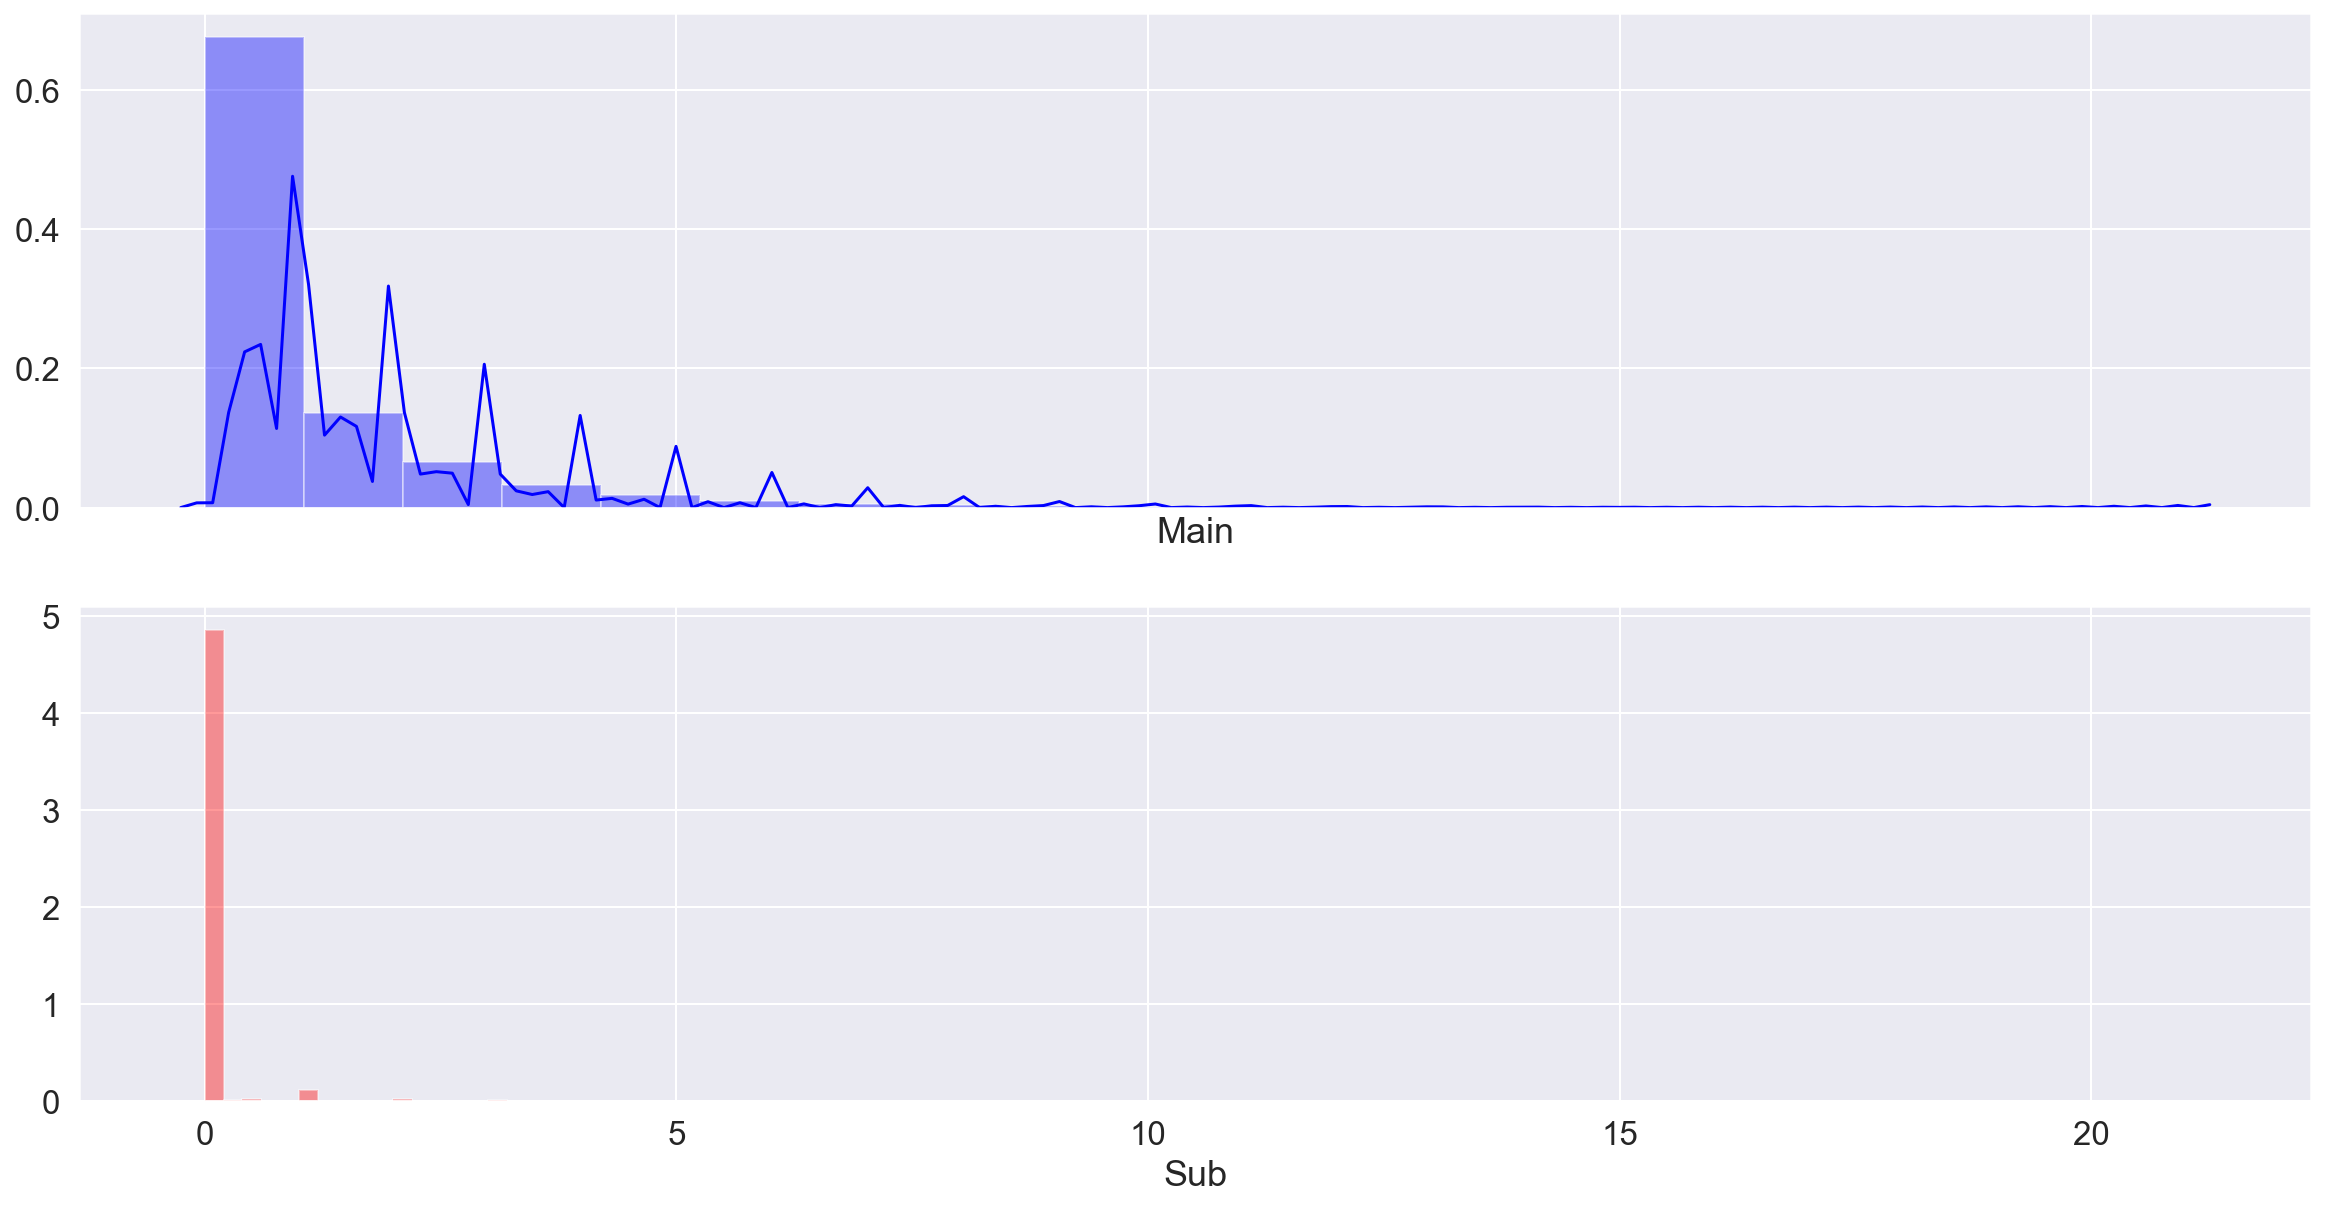

COLUMN : nba_ast_ratio 
 Main min 0.00	 Sub min 0.00 
 Main max 100.00	 Sub max 100.00


/Users/finnalexander/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


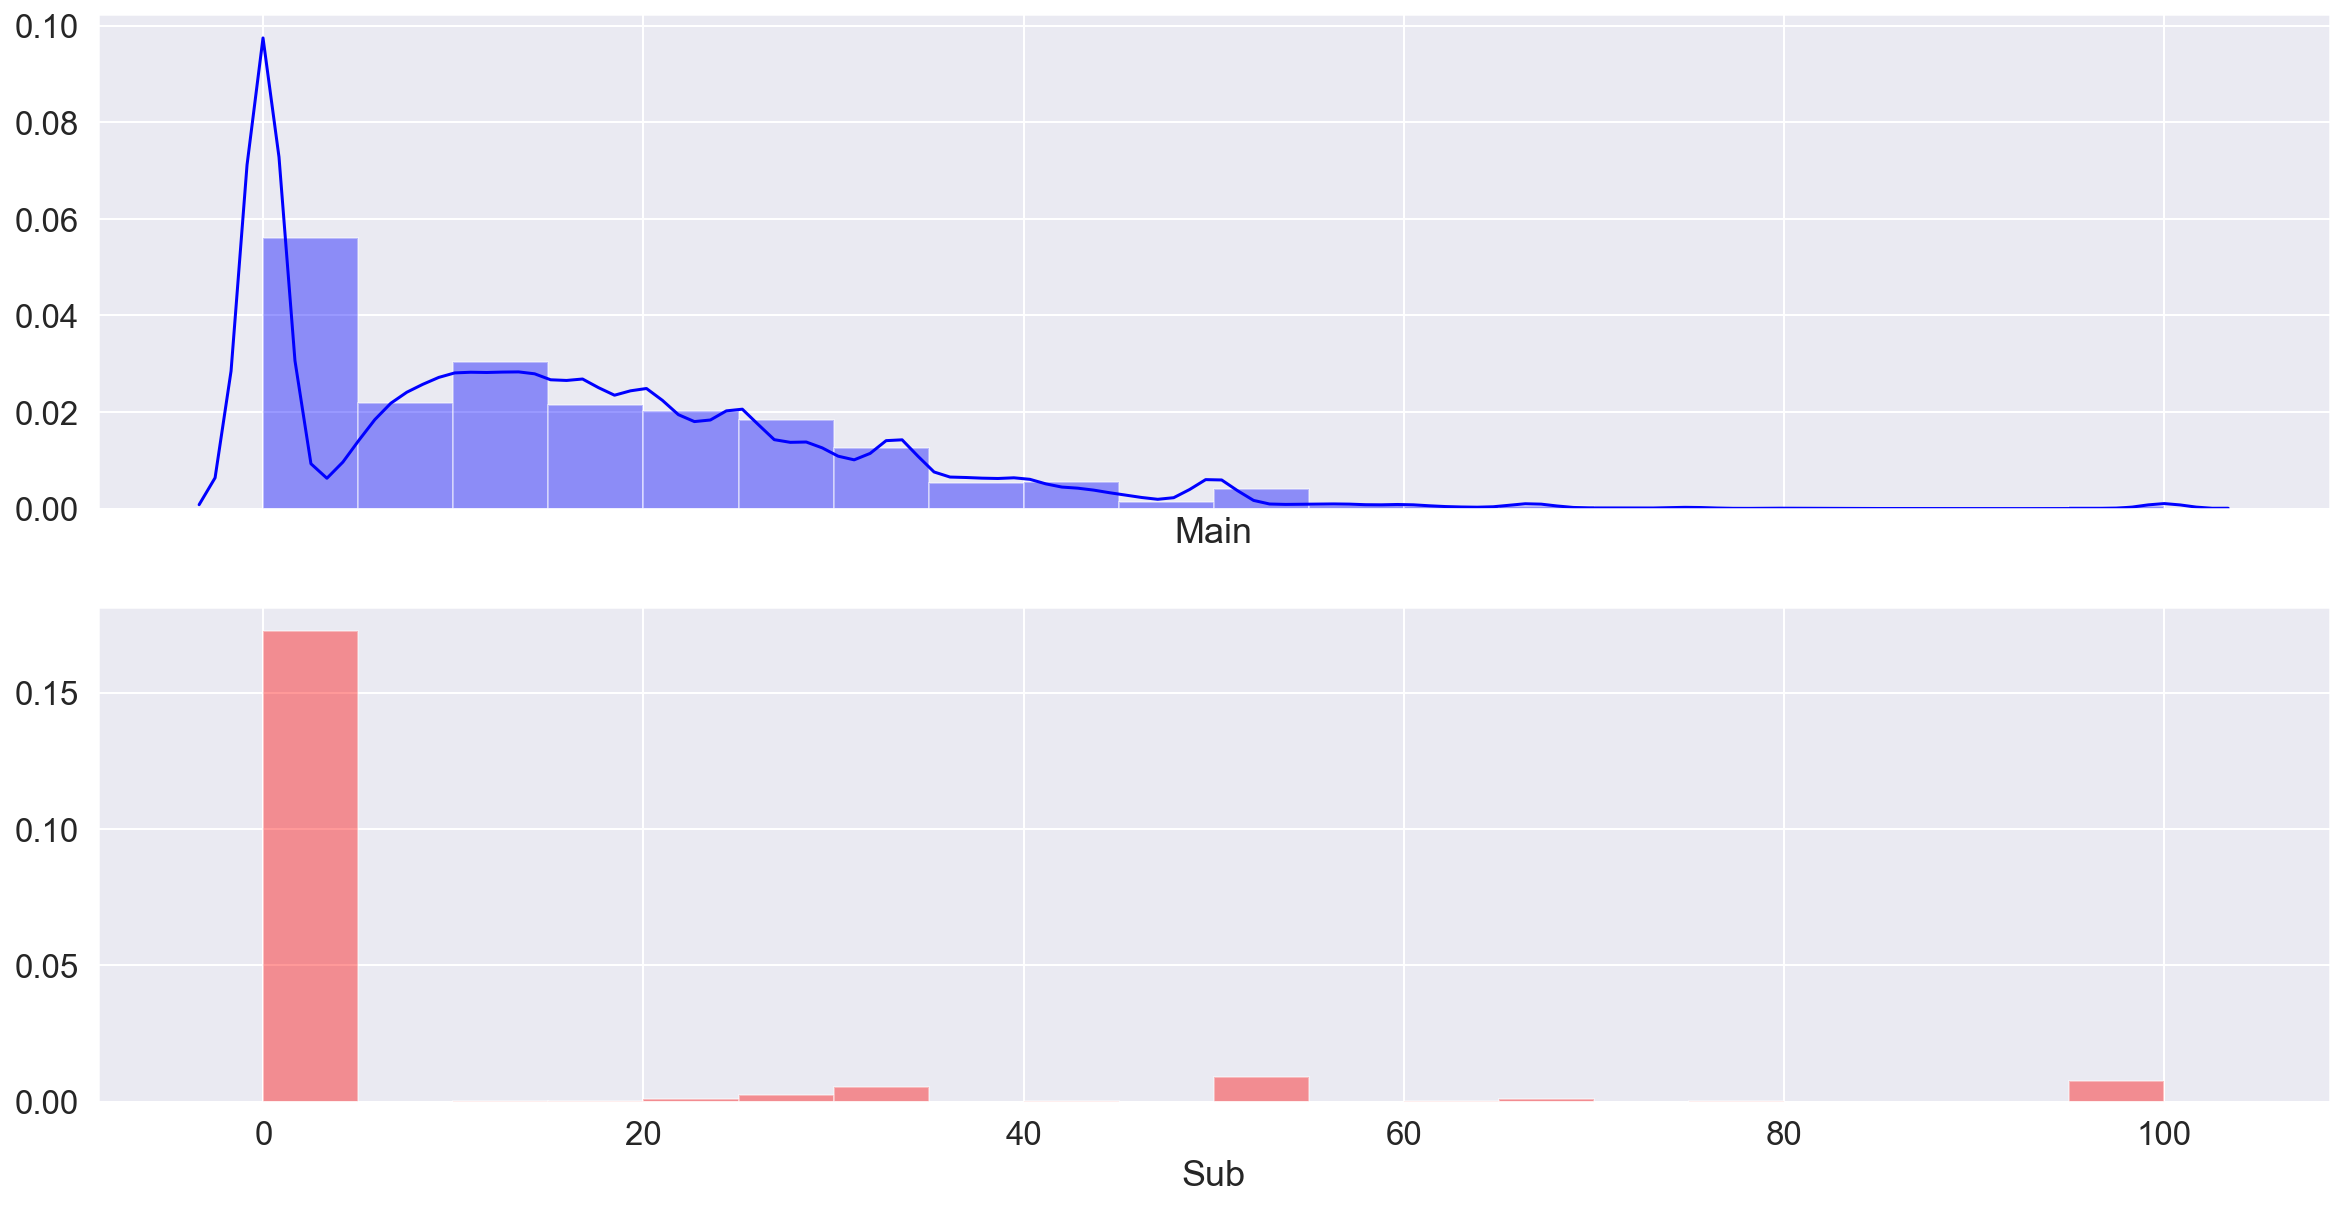

COLUMN : nba_oreb_pct 
 Main min 0.00	 Sub min 0.00 
 Main max 1.00	 Sub max 1.00


/Users/finnalexander/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


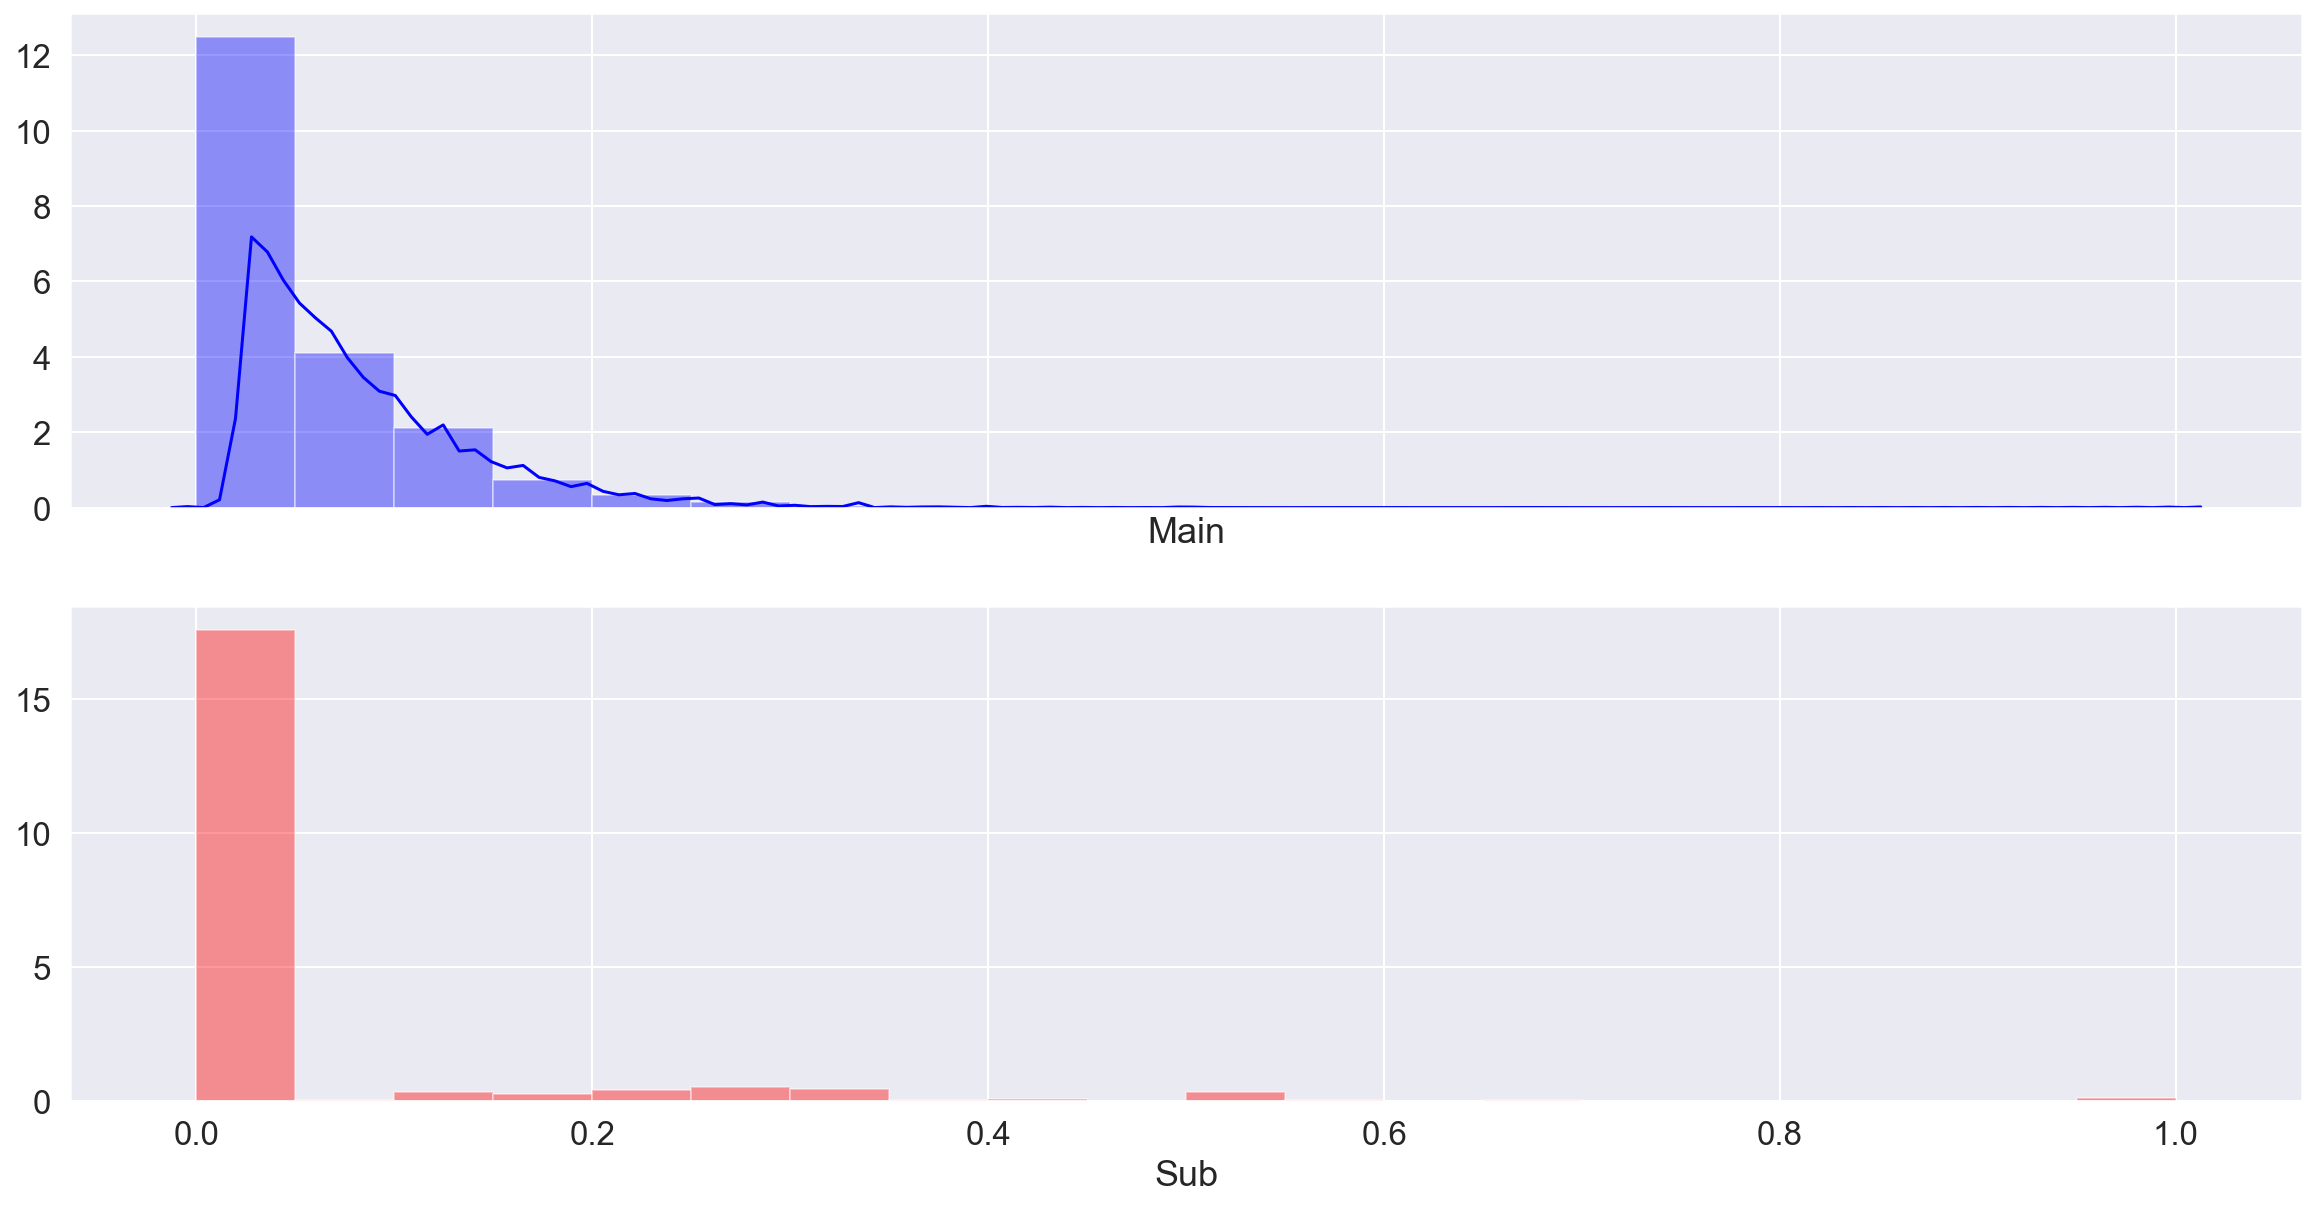

COLUMN : nba_dreb_pct 
 Main min 0.00	 Sub min 0.00 
 Main max 1.00	 Sub max 1.00


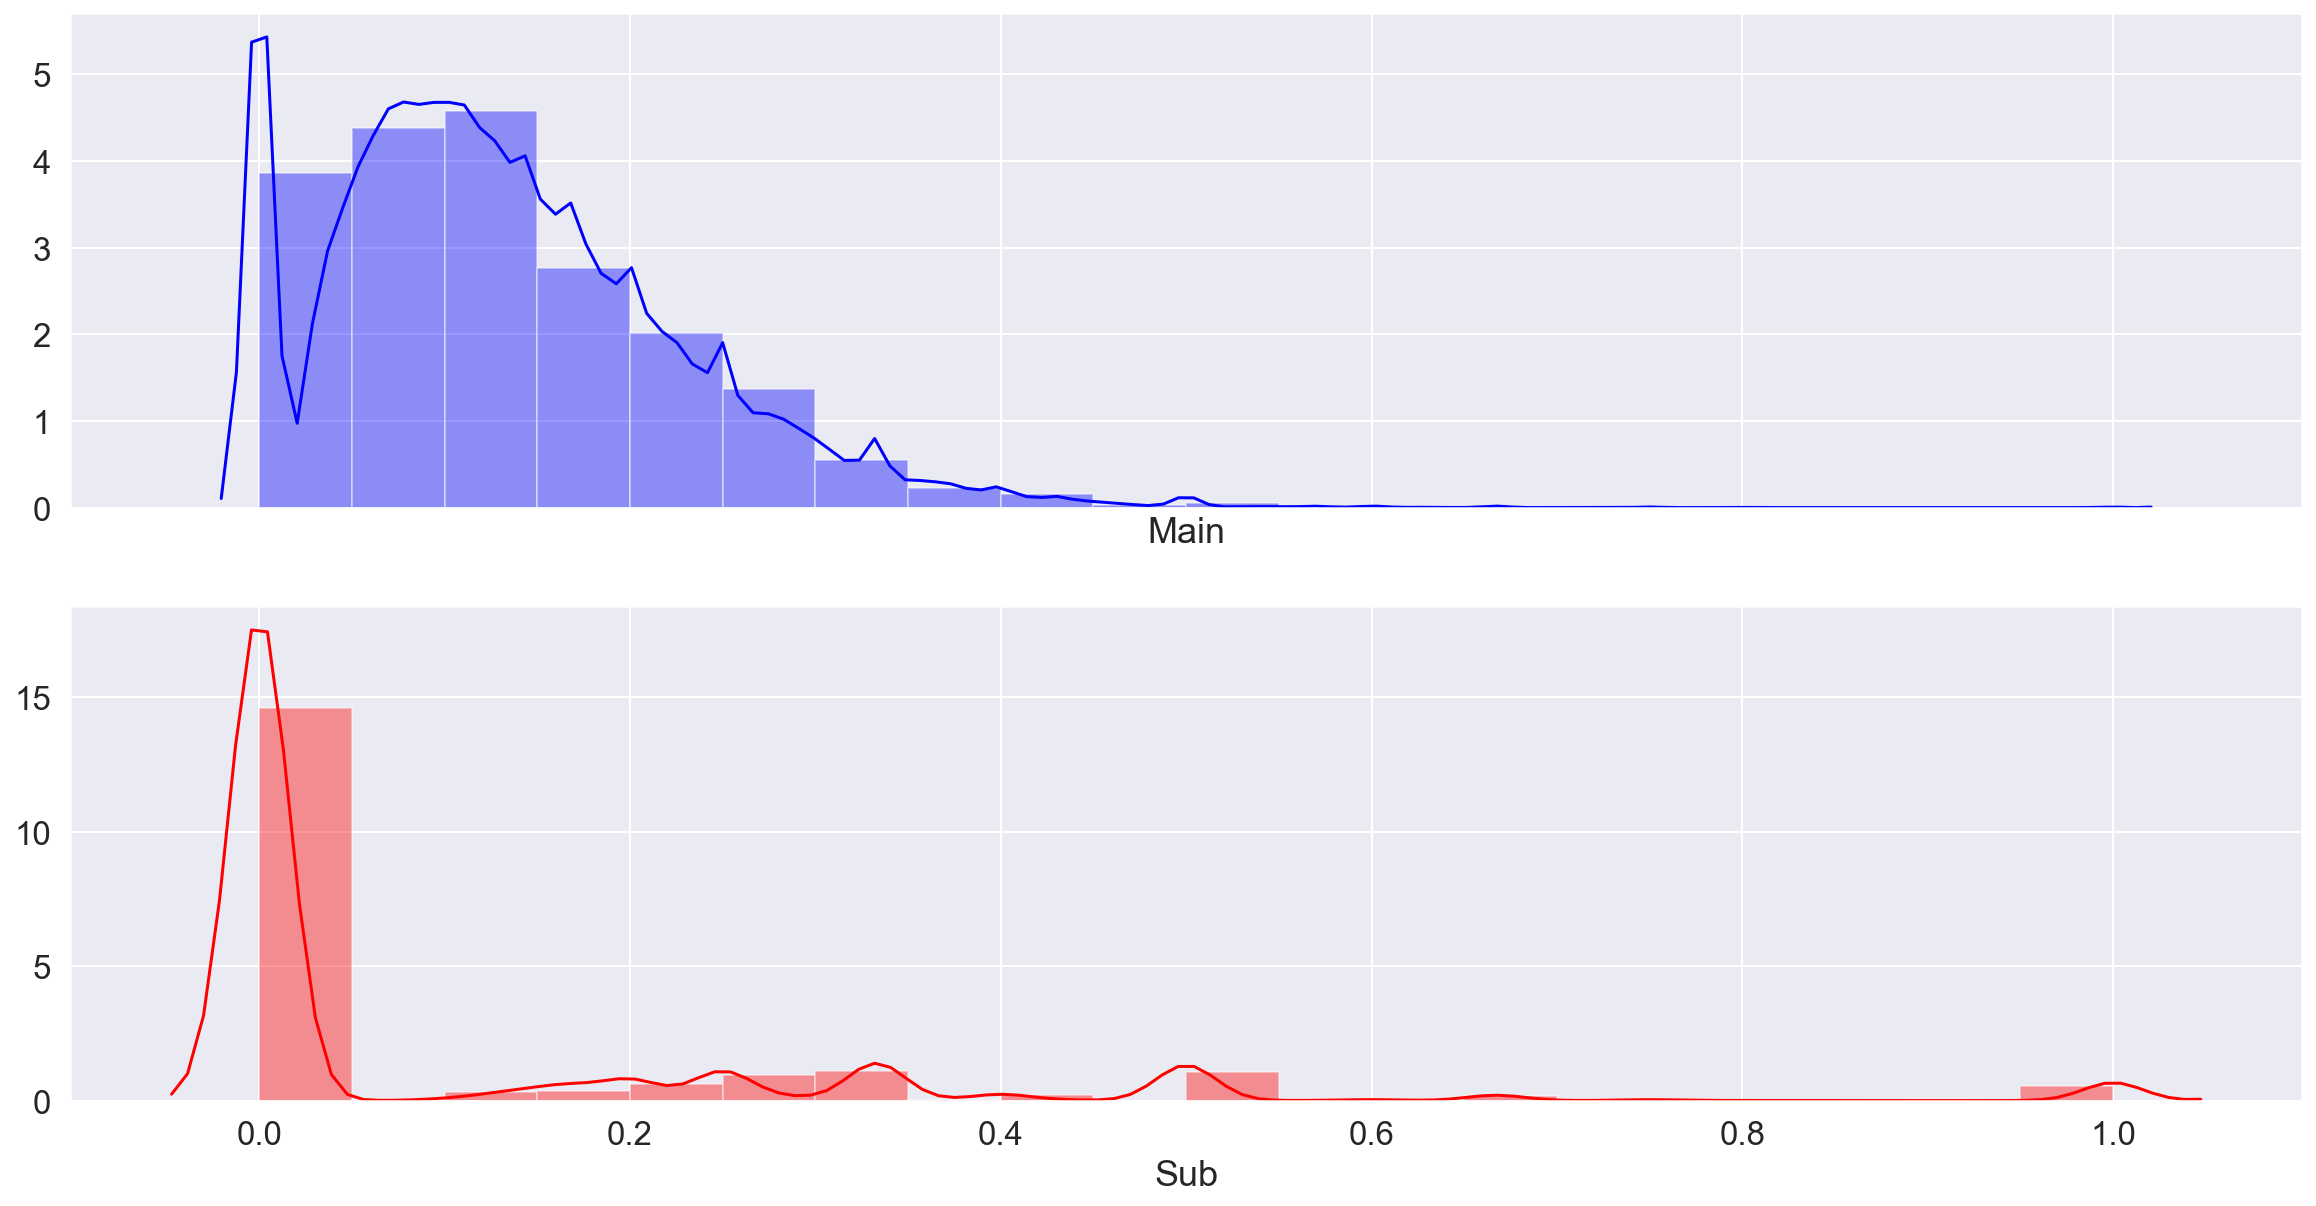

COLUMN : nba_reb_pct 
 Main min 0.00	 Sub min 0.00 
 Main max 0.83	 Sub max 1.00


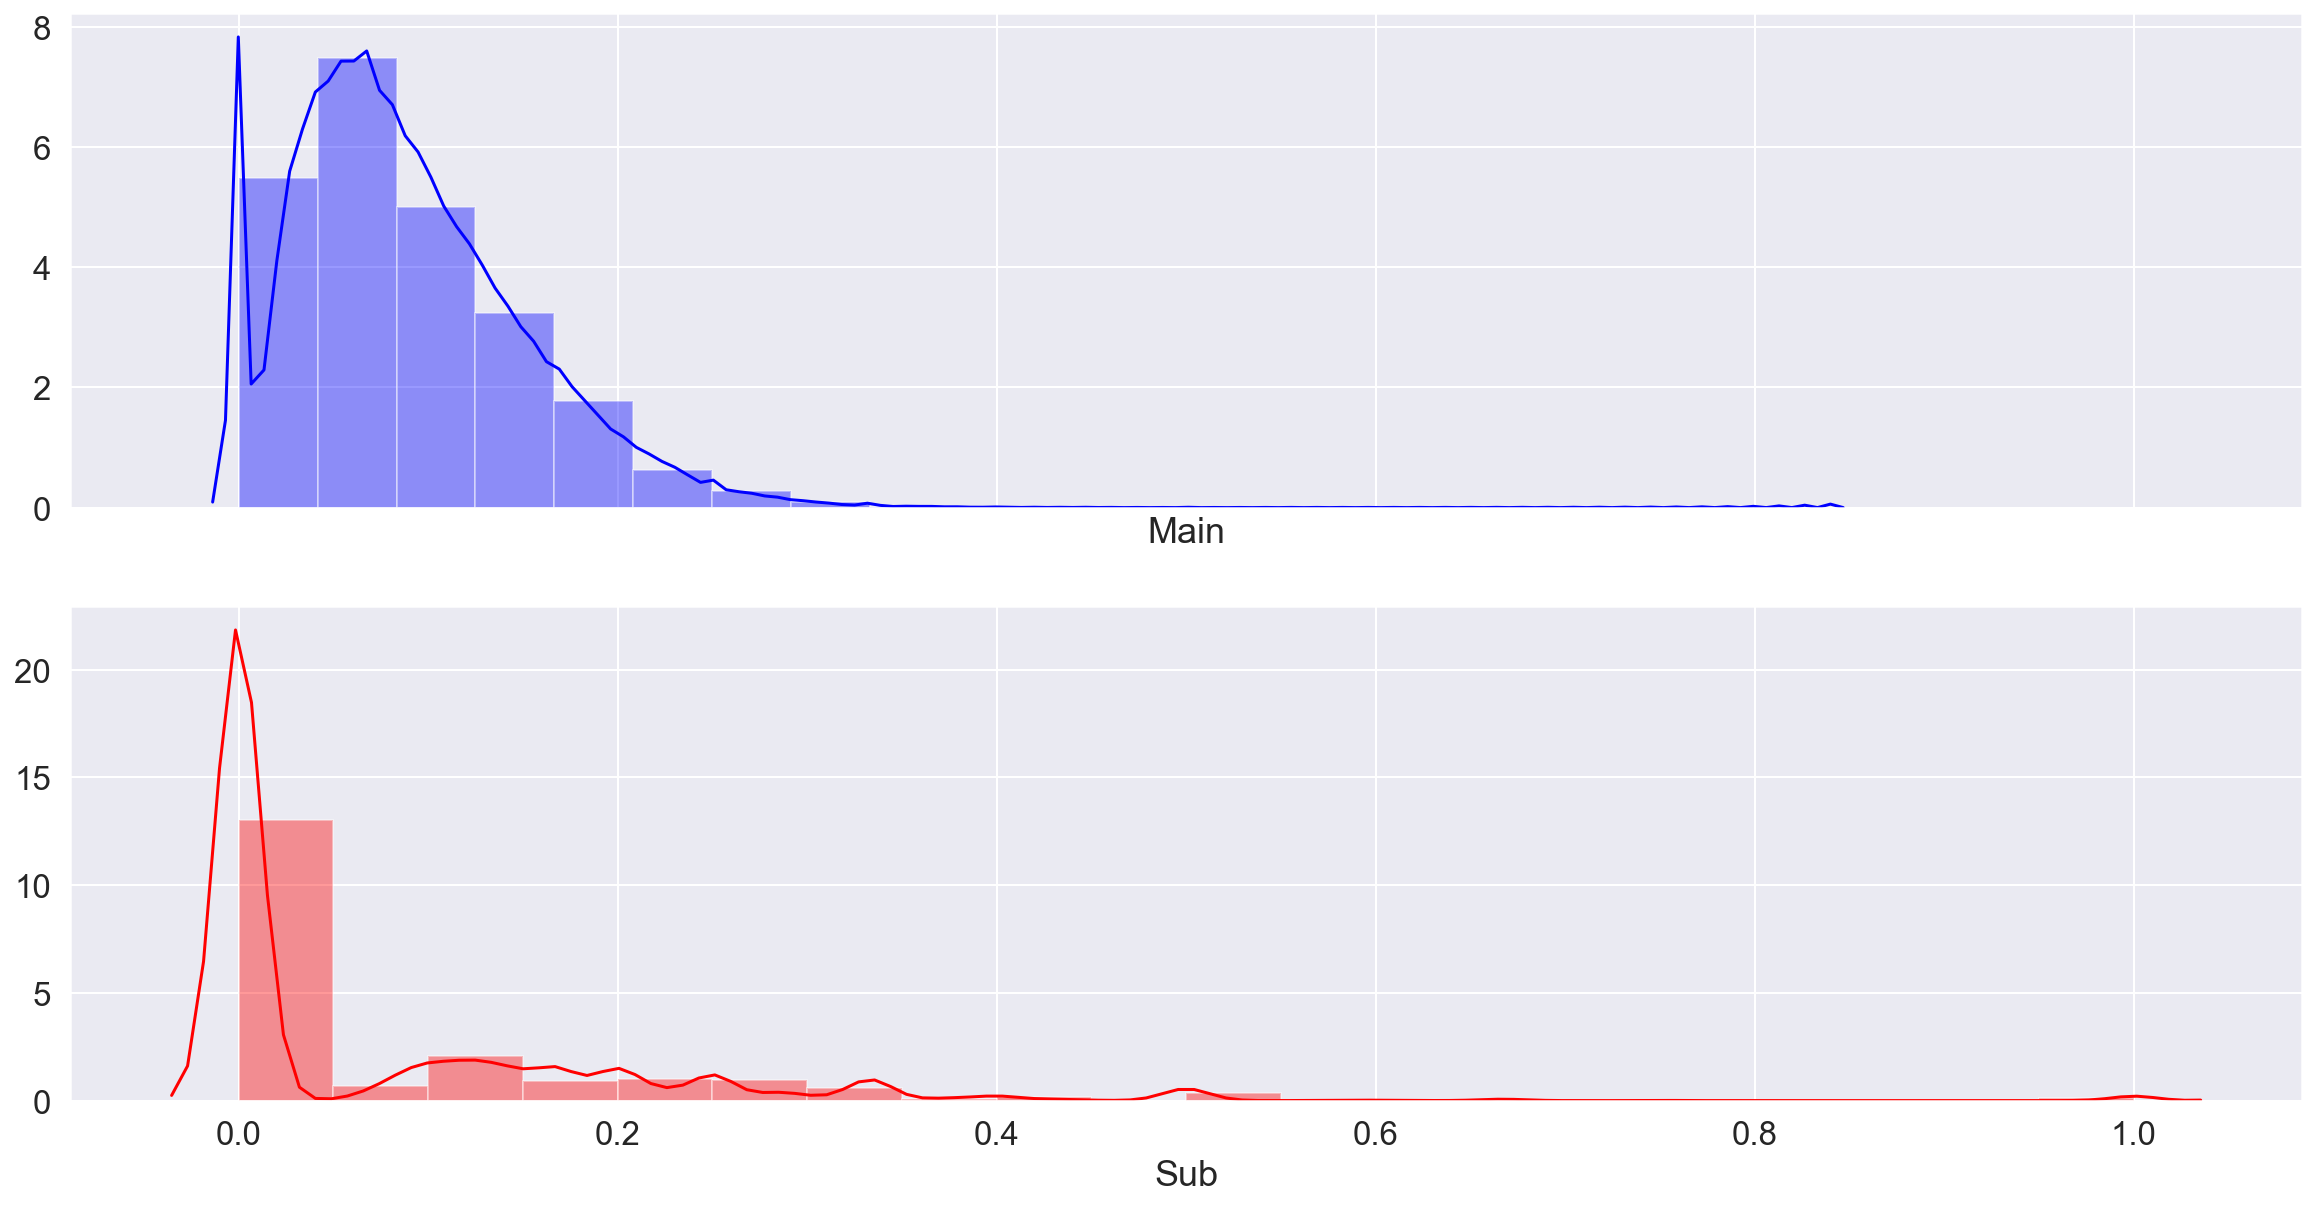

COLUMN : nba_tm_tov_pct 
 Main min 0.00	 Sub min 0.00 
 Main max 100.00	 Sub max 100.00


/Users/finnalexander/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


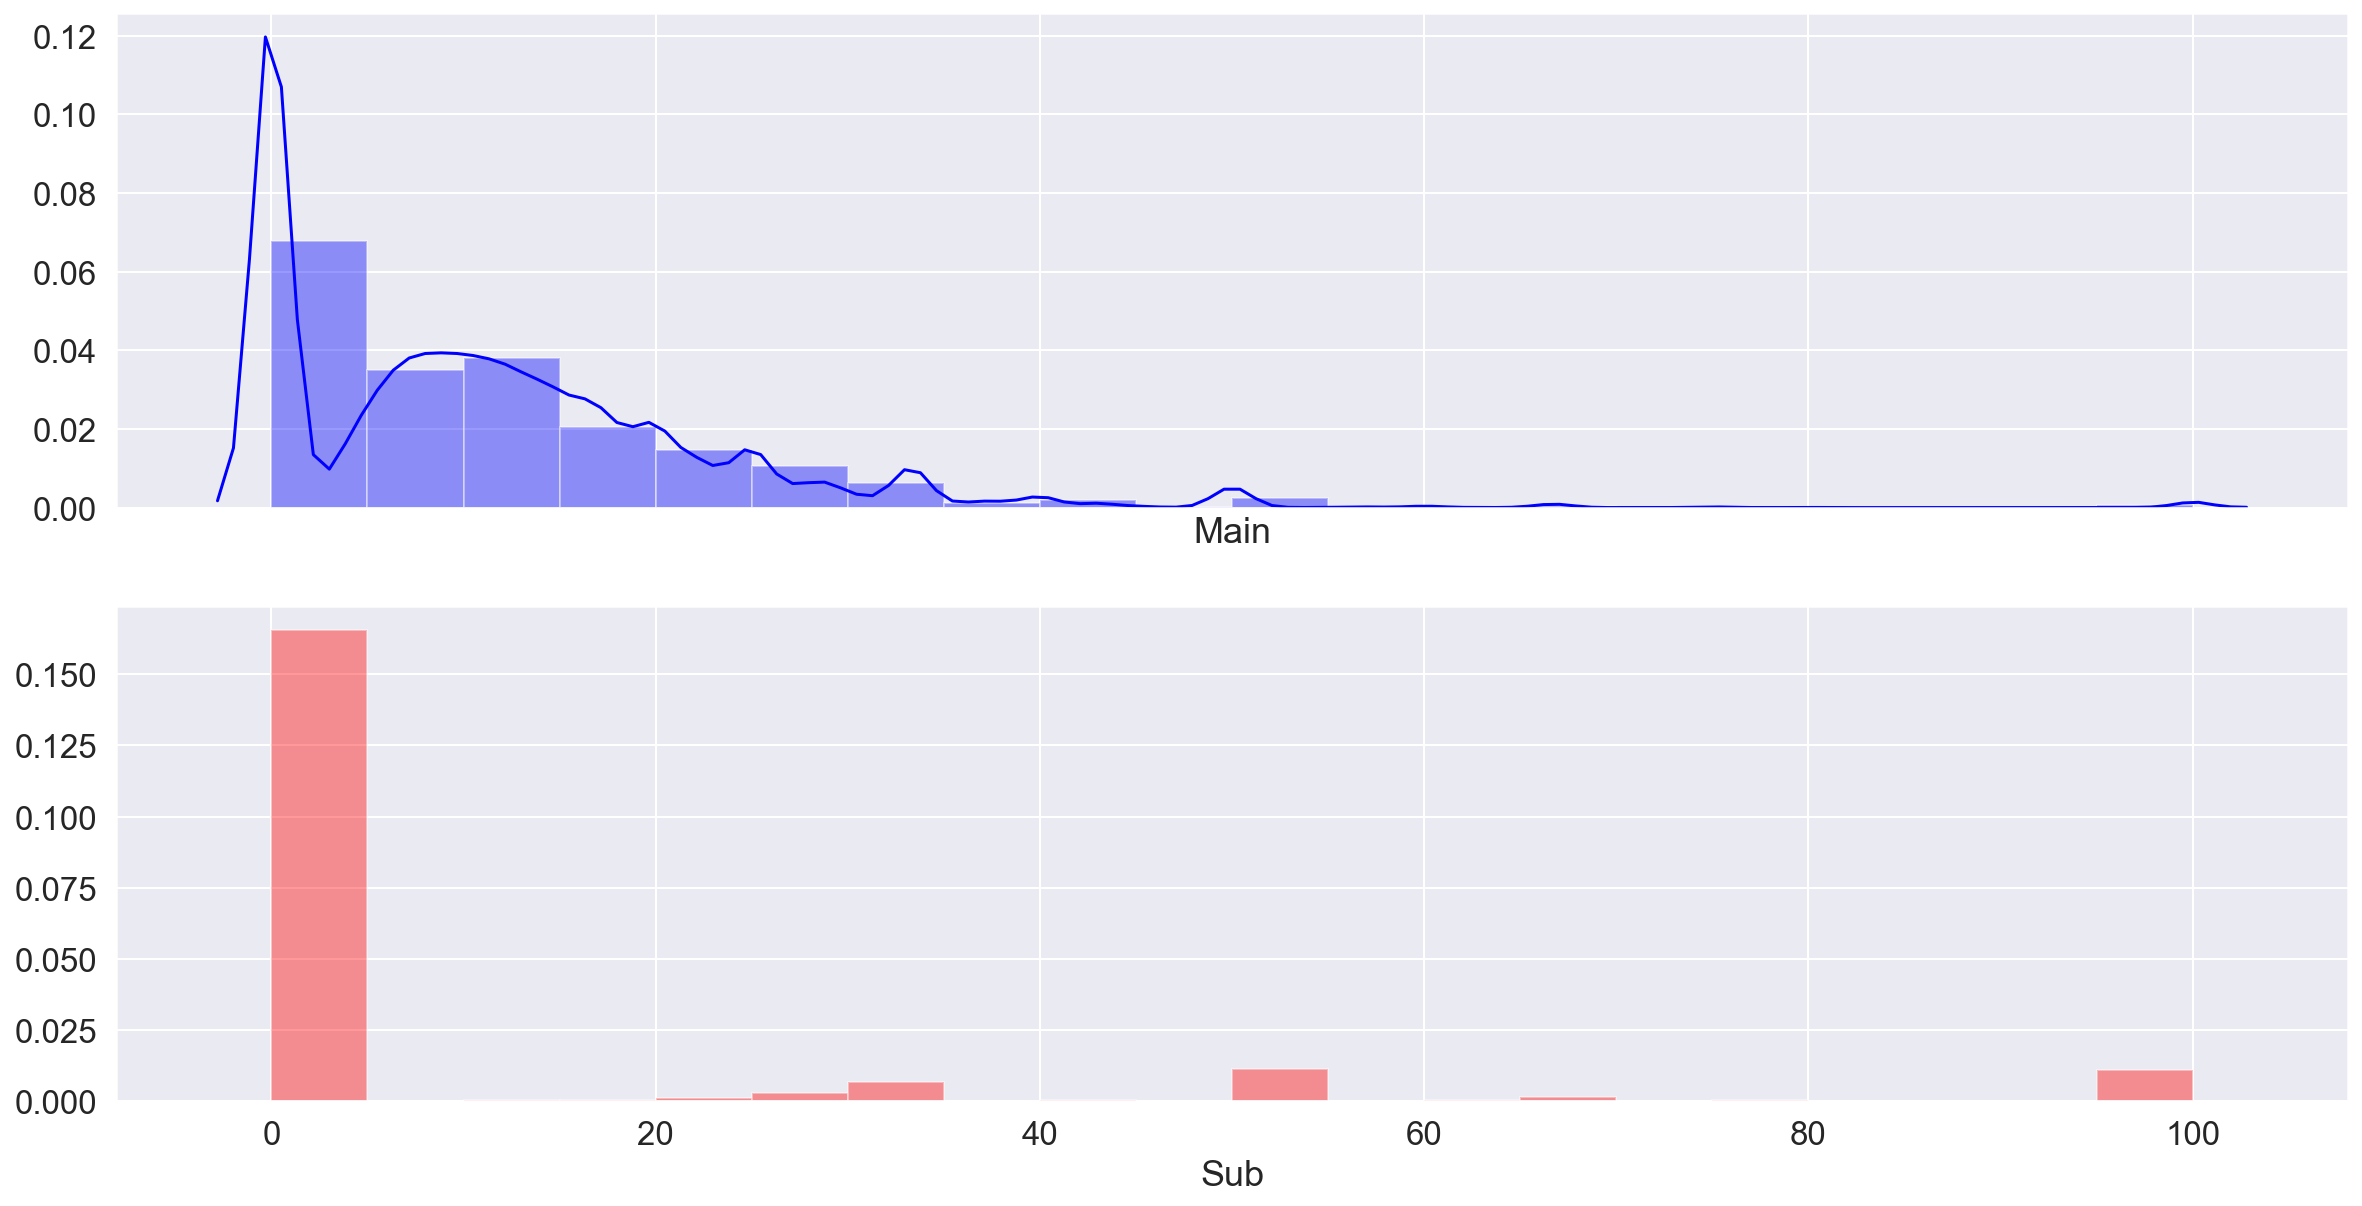

COLUMN : nba_efg_pct 
 Main min 0.00	 Sub min 0.00 
 Main max 1.50	 Sub max 1.50


/Users/finnalexander/Desktop/Anaconda/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


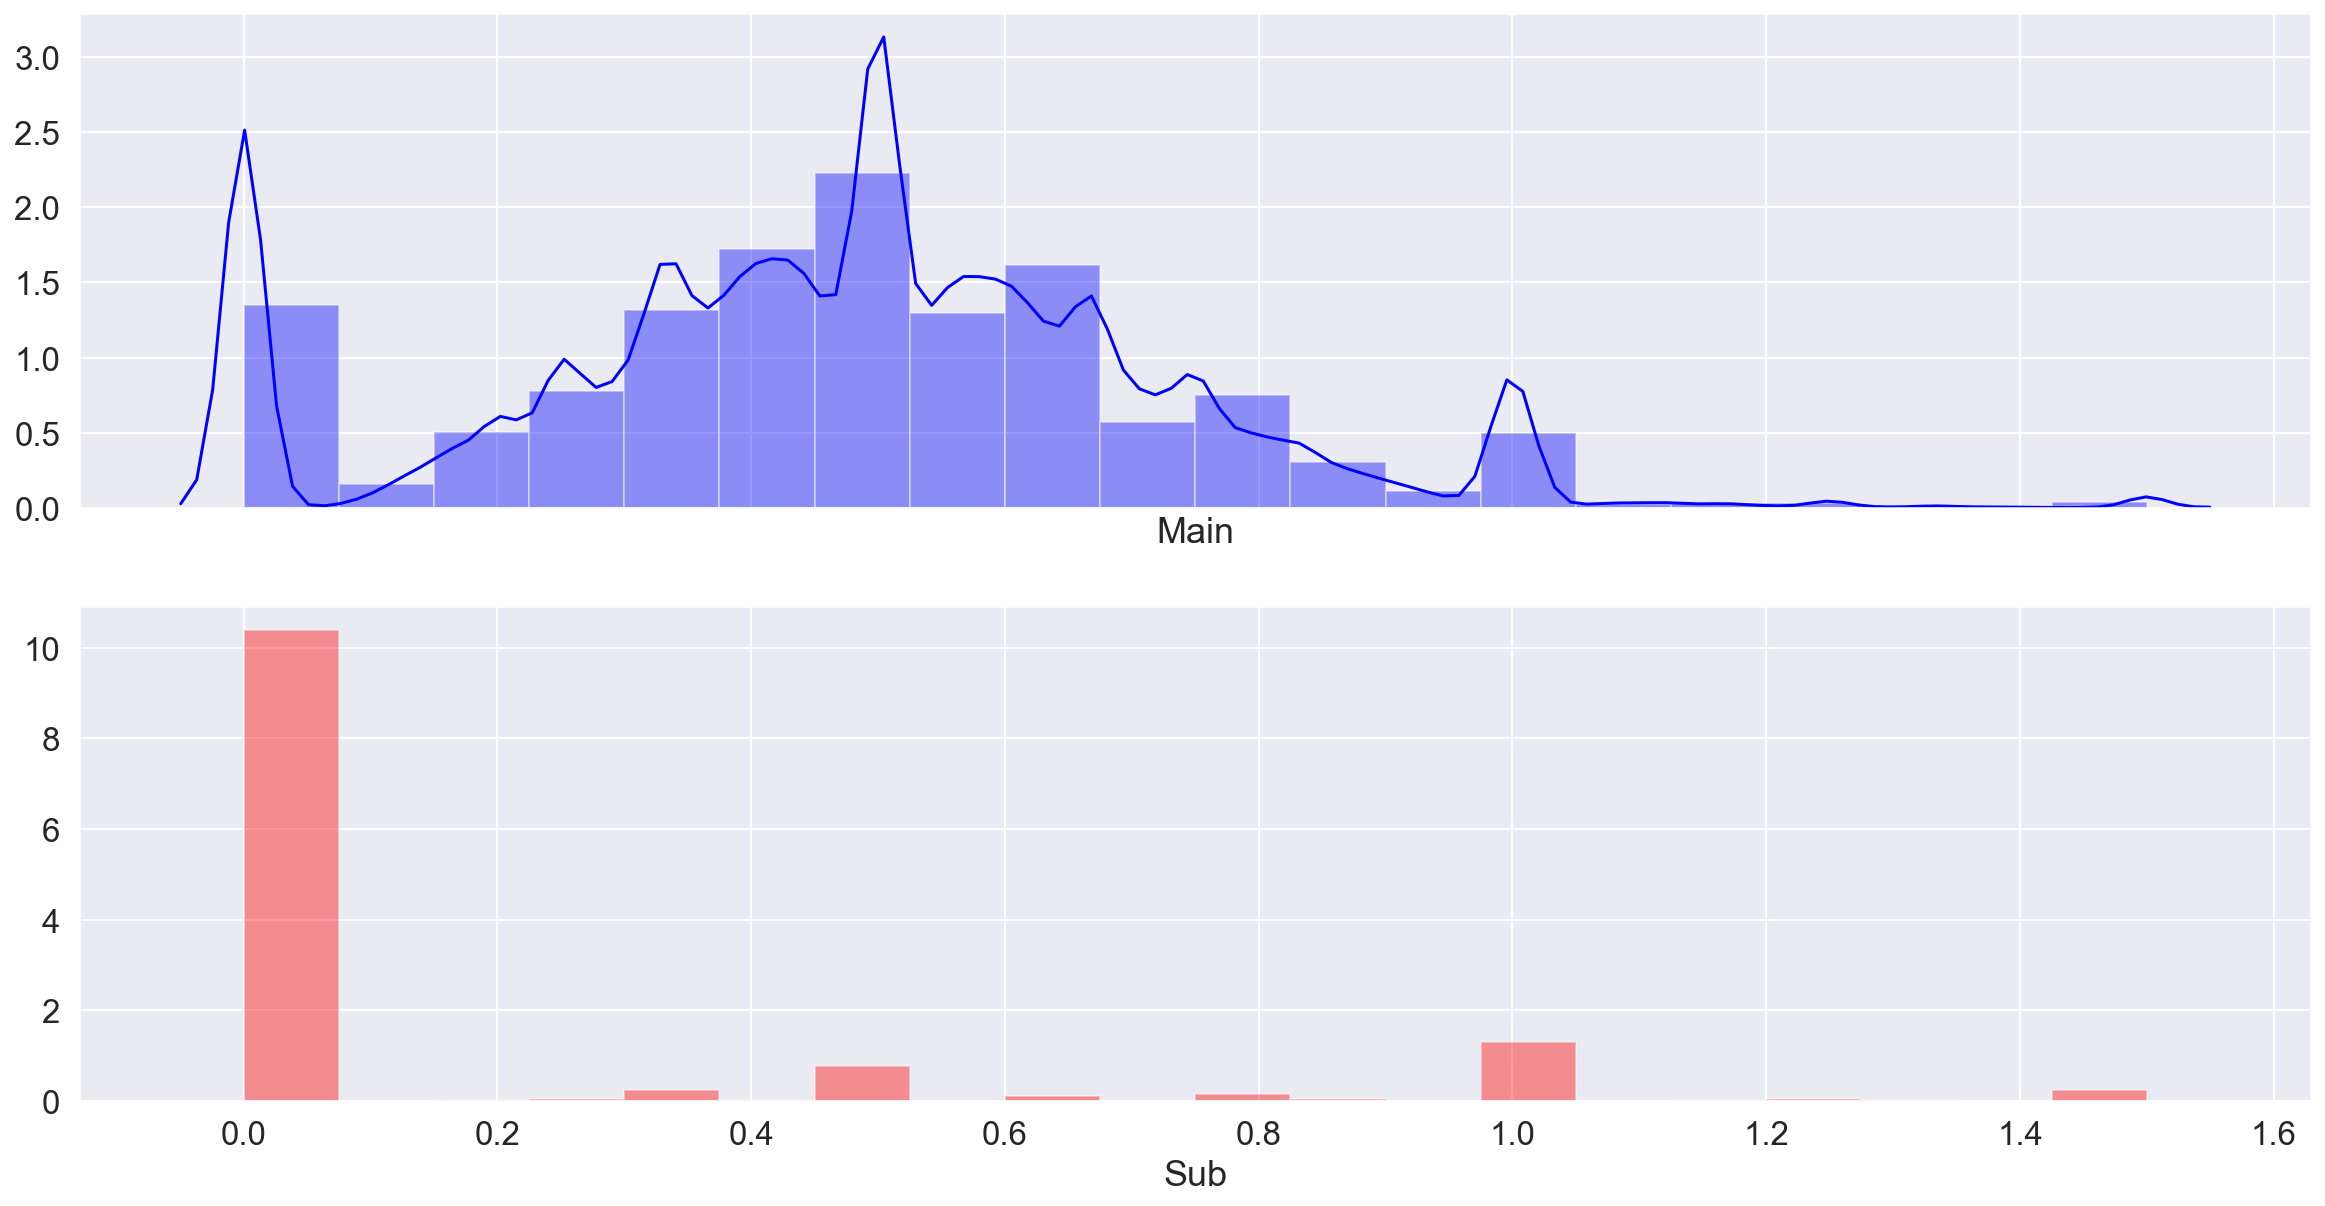

COLUMN : nba_ts_pct 
 Main min 0.00	 Sub min 0.00 
 Main max 1.50	 Sub max 1.50


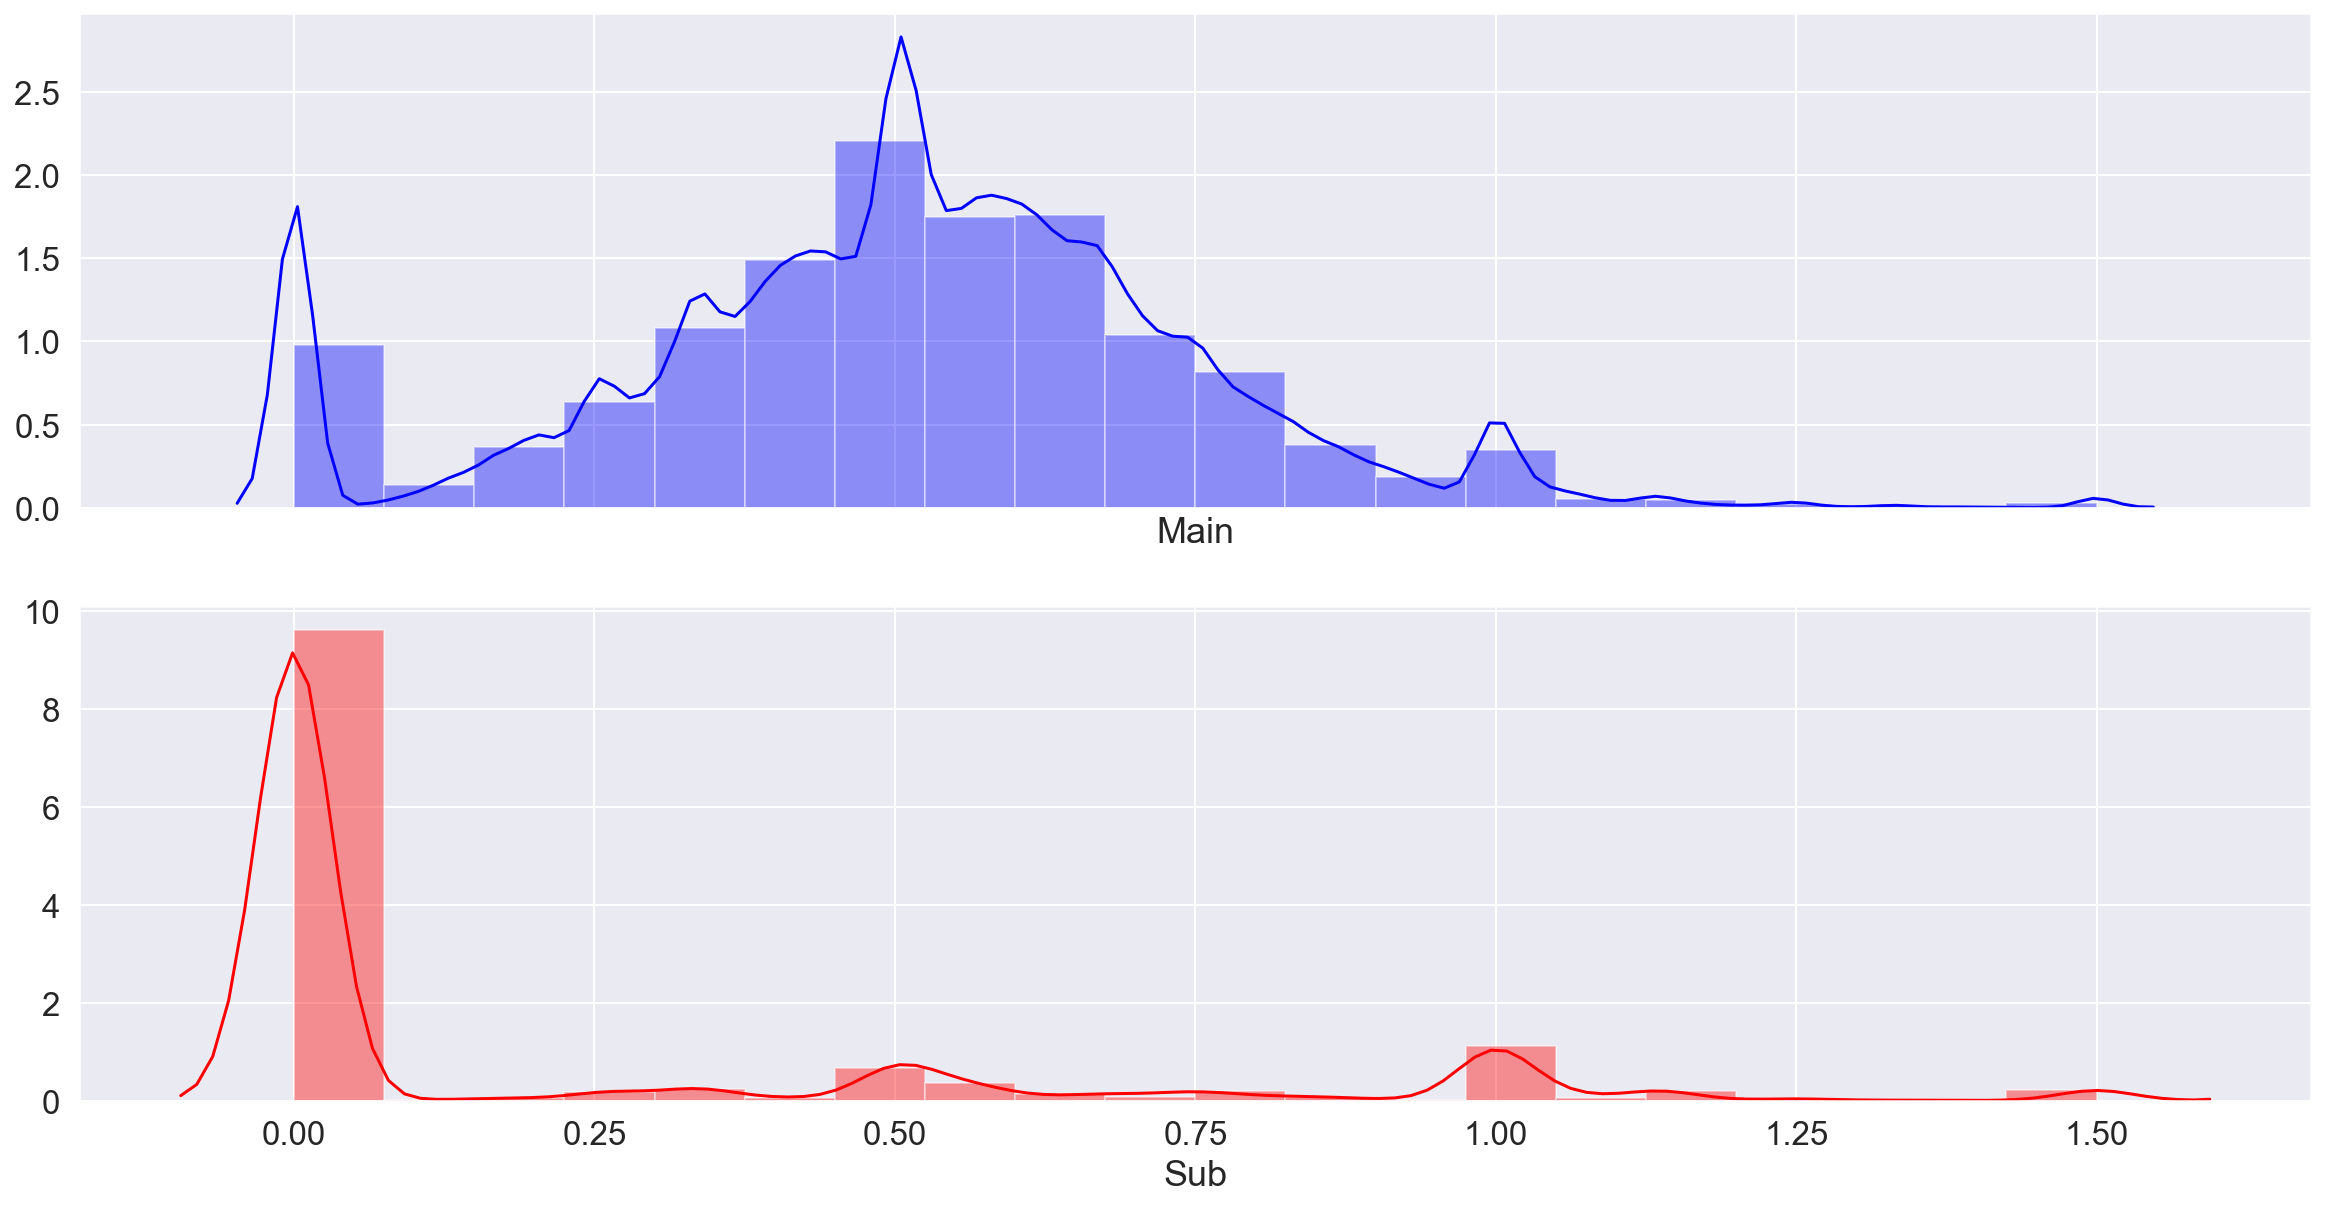

COLUMN : nba_usg_pct 
 Main min 0.00	 Sub min 0.00 
 Main max 0.64	 Sub max 2.00


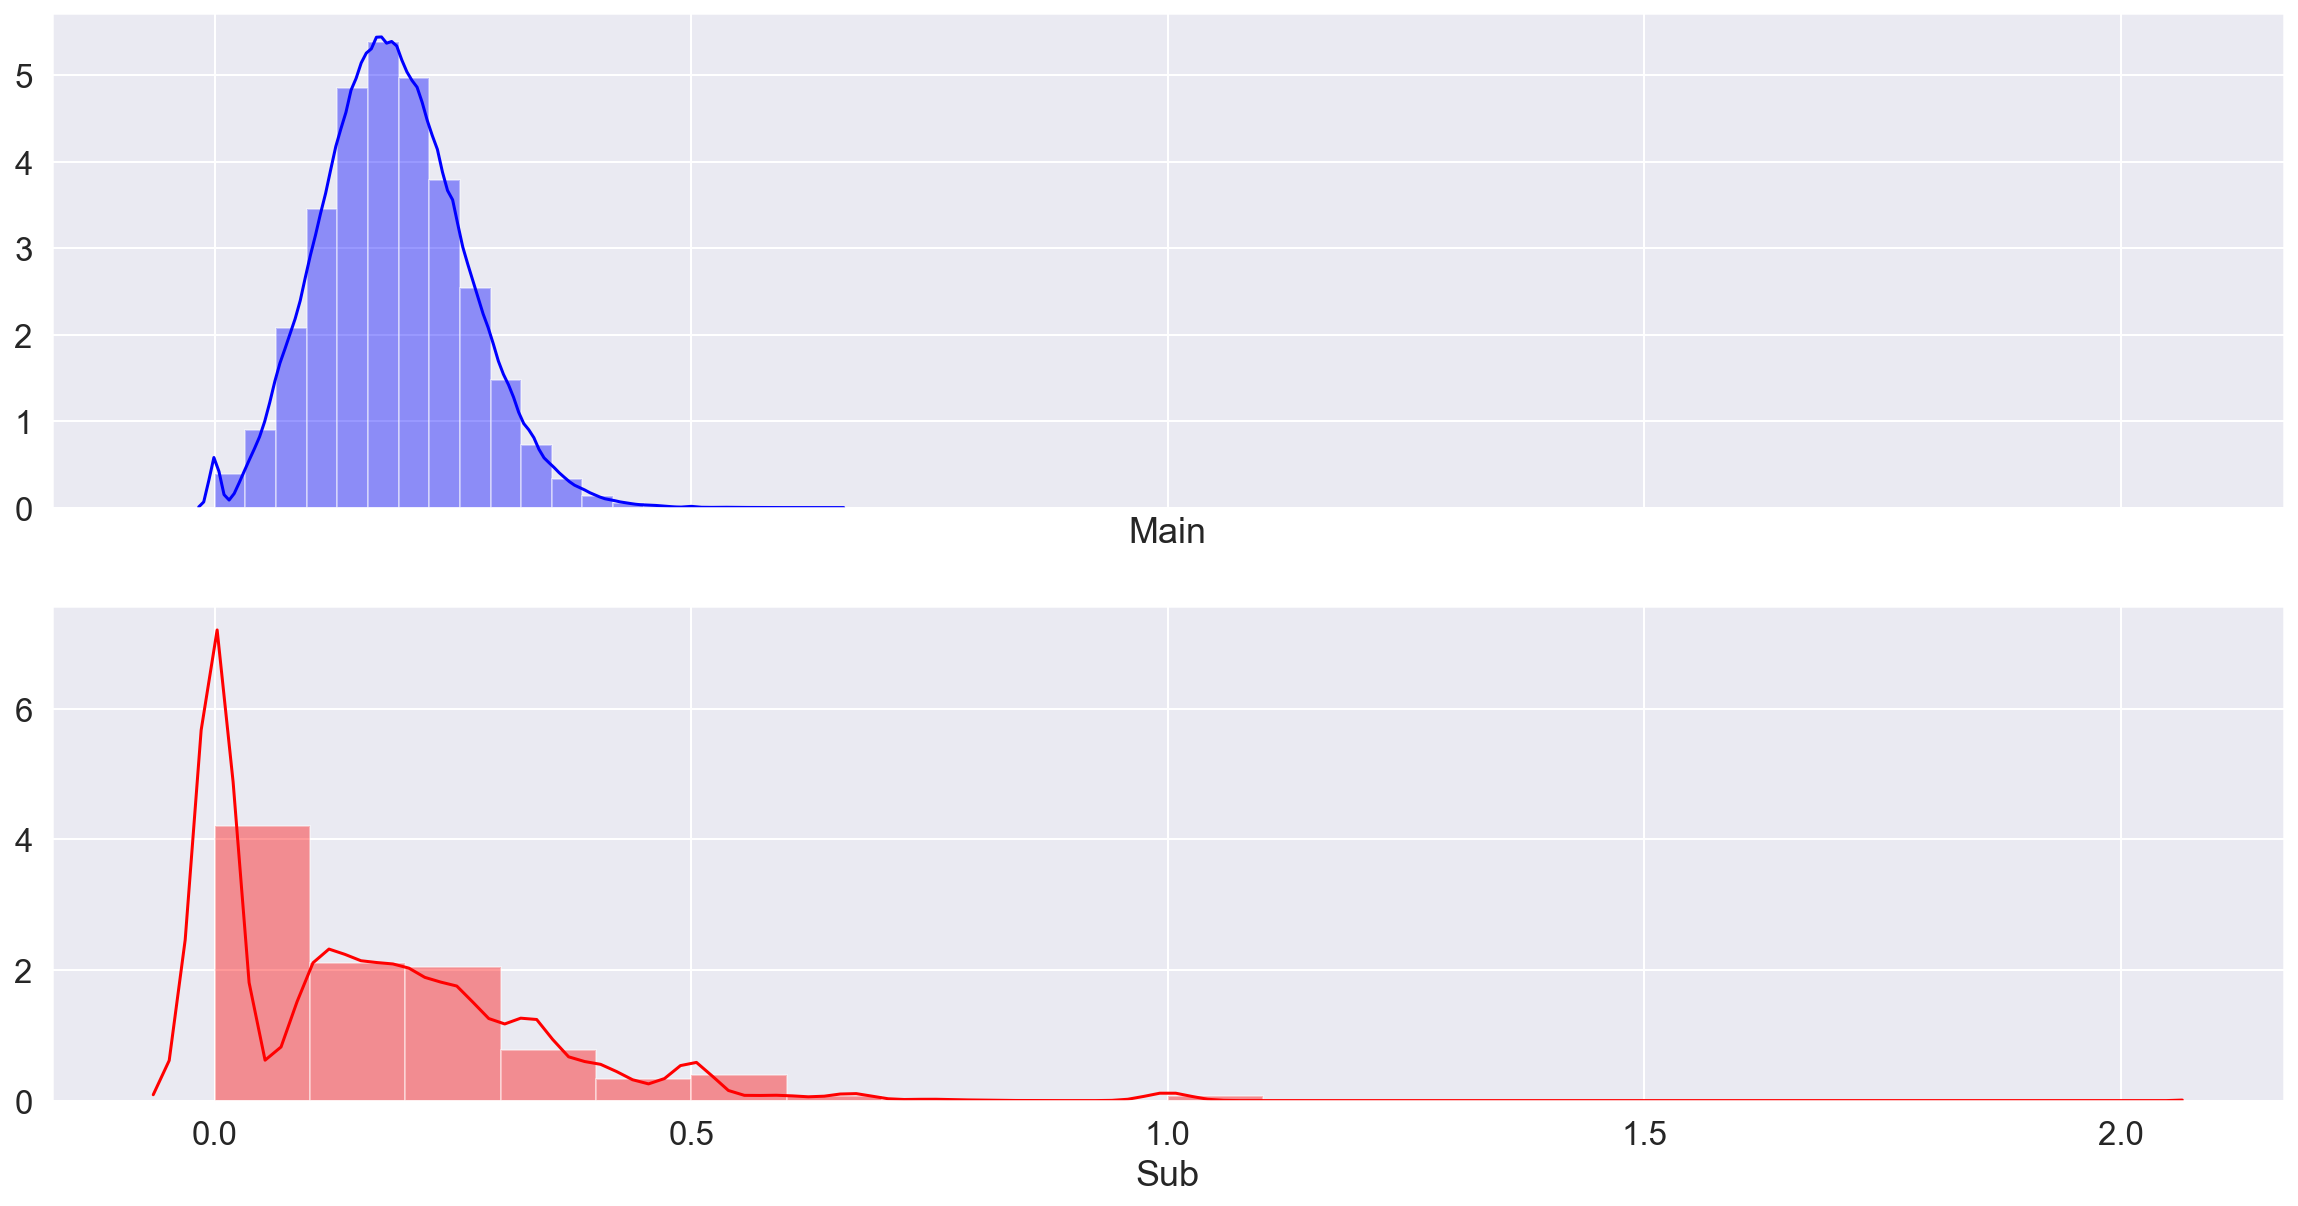

COLUMN : nba_e_pace 
 Main min 56.76	 Sub min -2400.00 
 Main max 162.78	 Sub max 5414.40


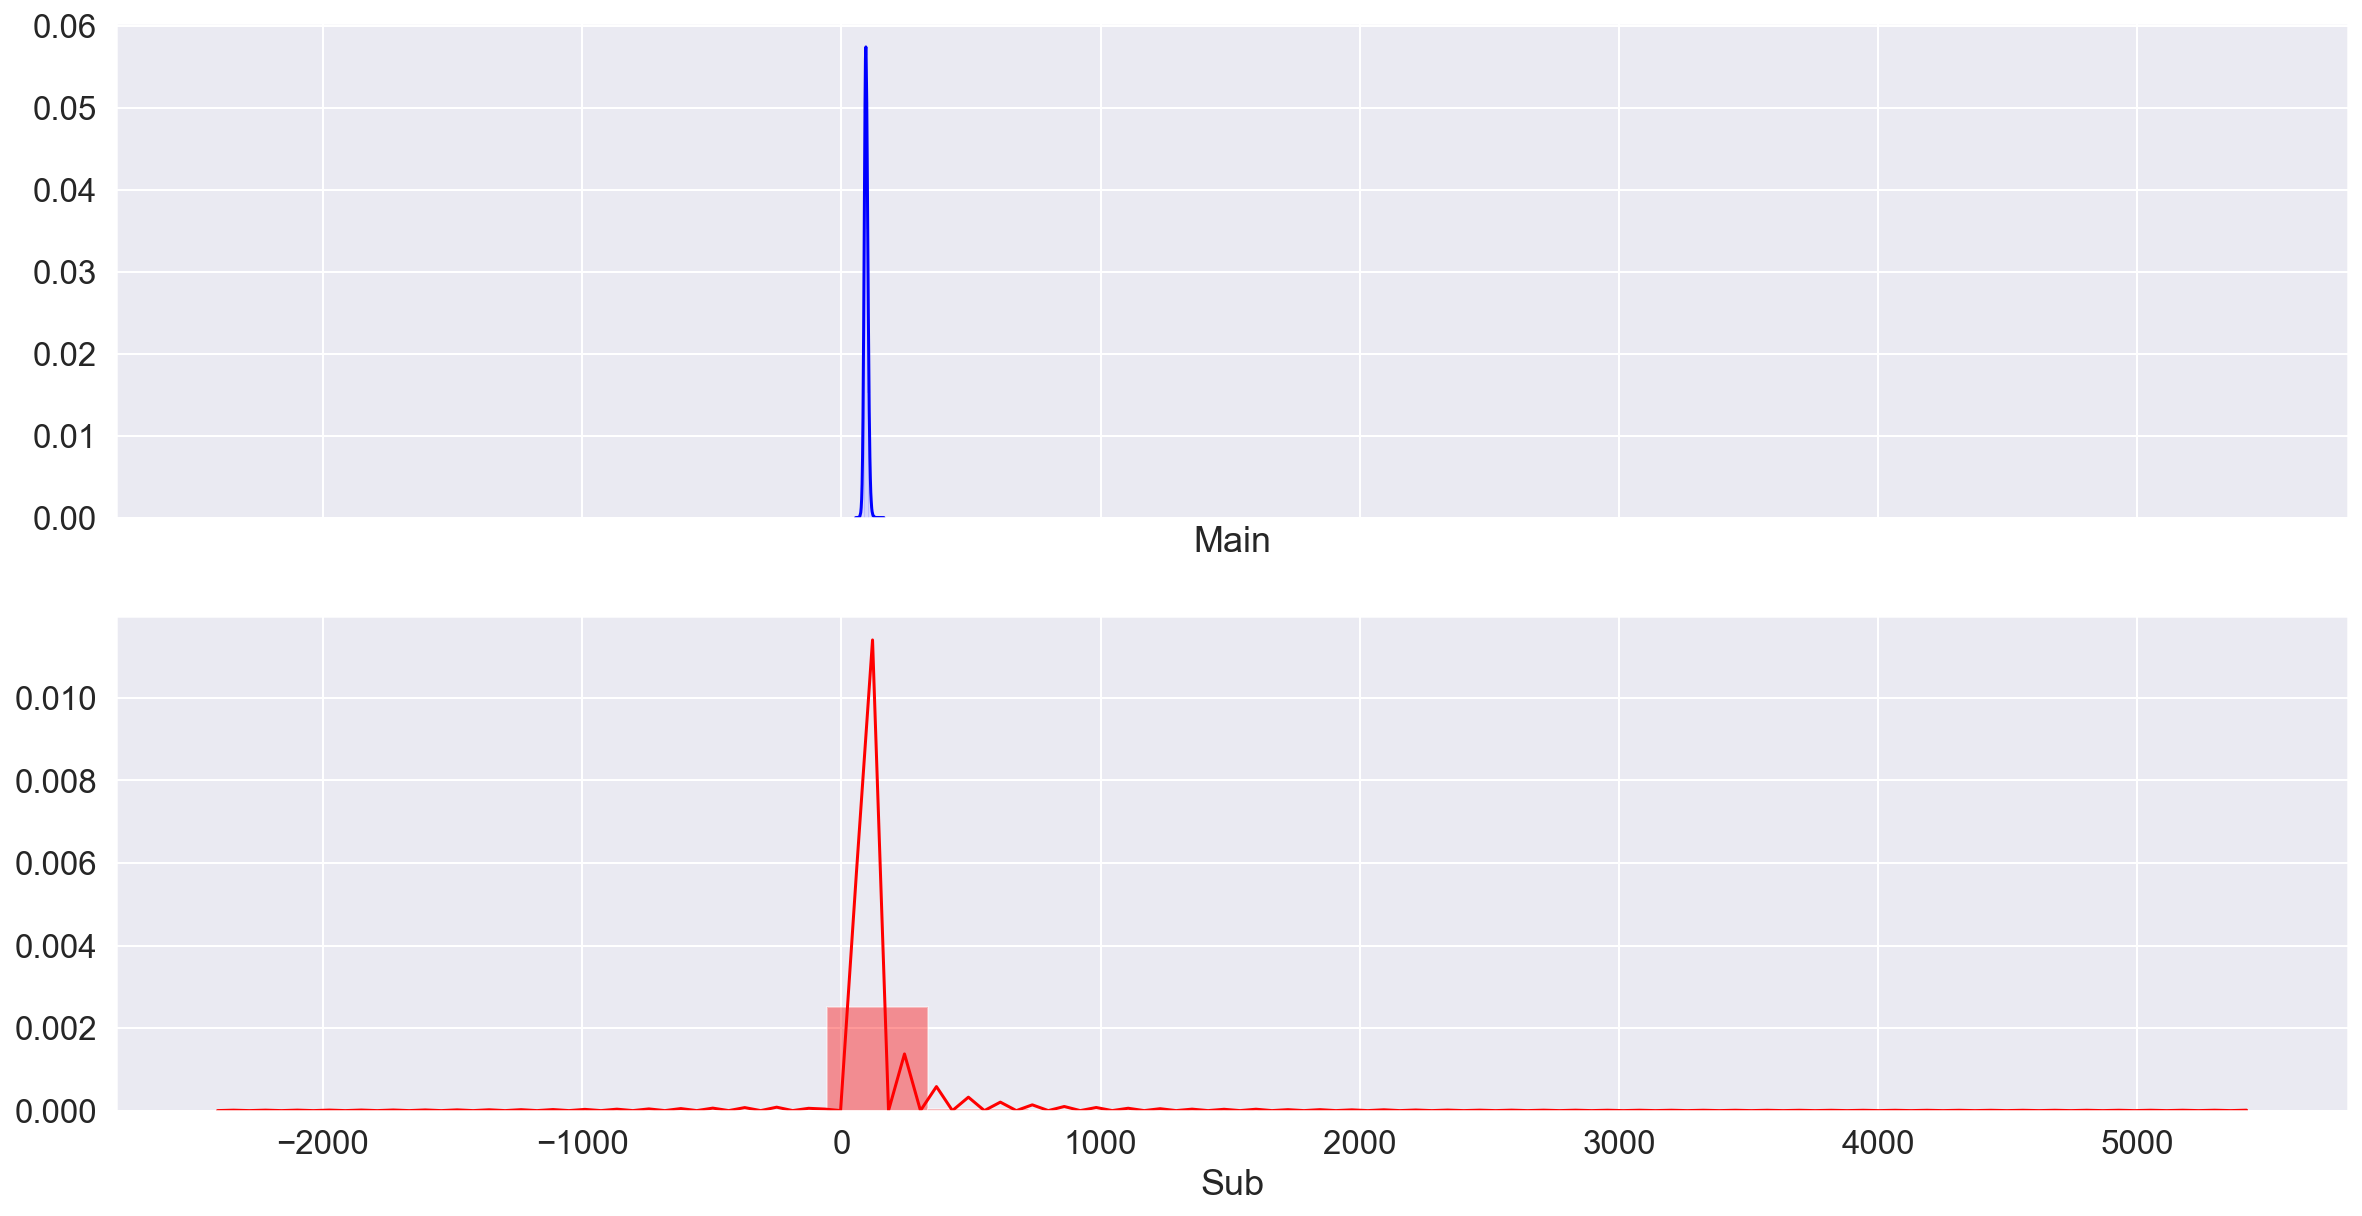

COLUMN : nba_pace 
 Main min 60.18	 Sub min 32.21 
 Main max 163.53	 Sub max 5760.23


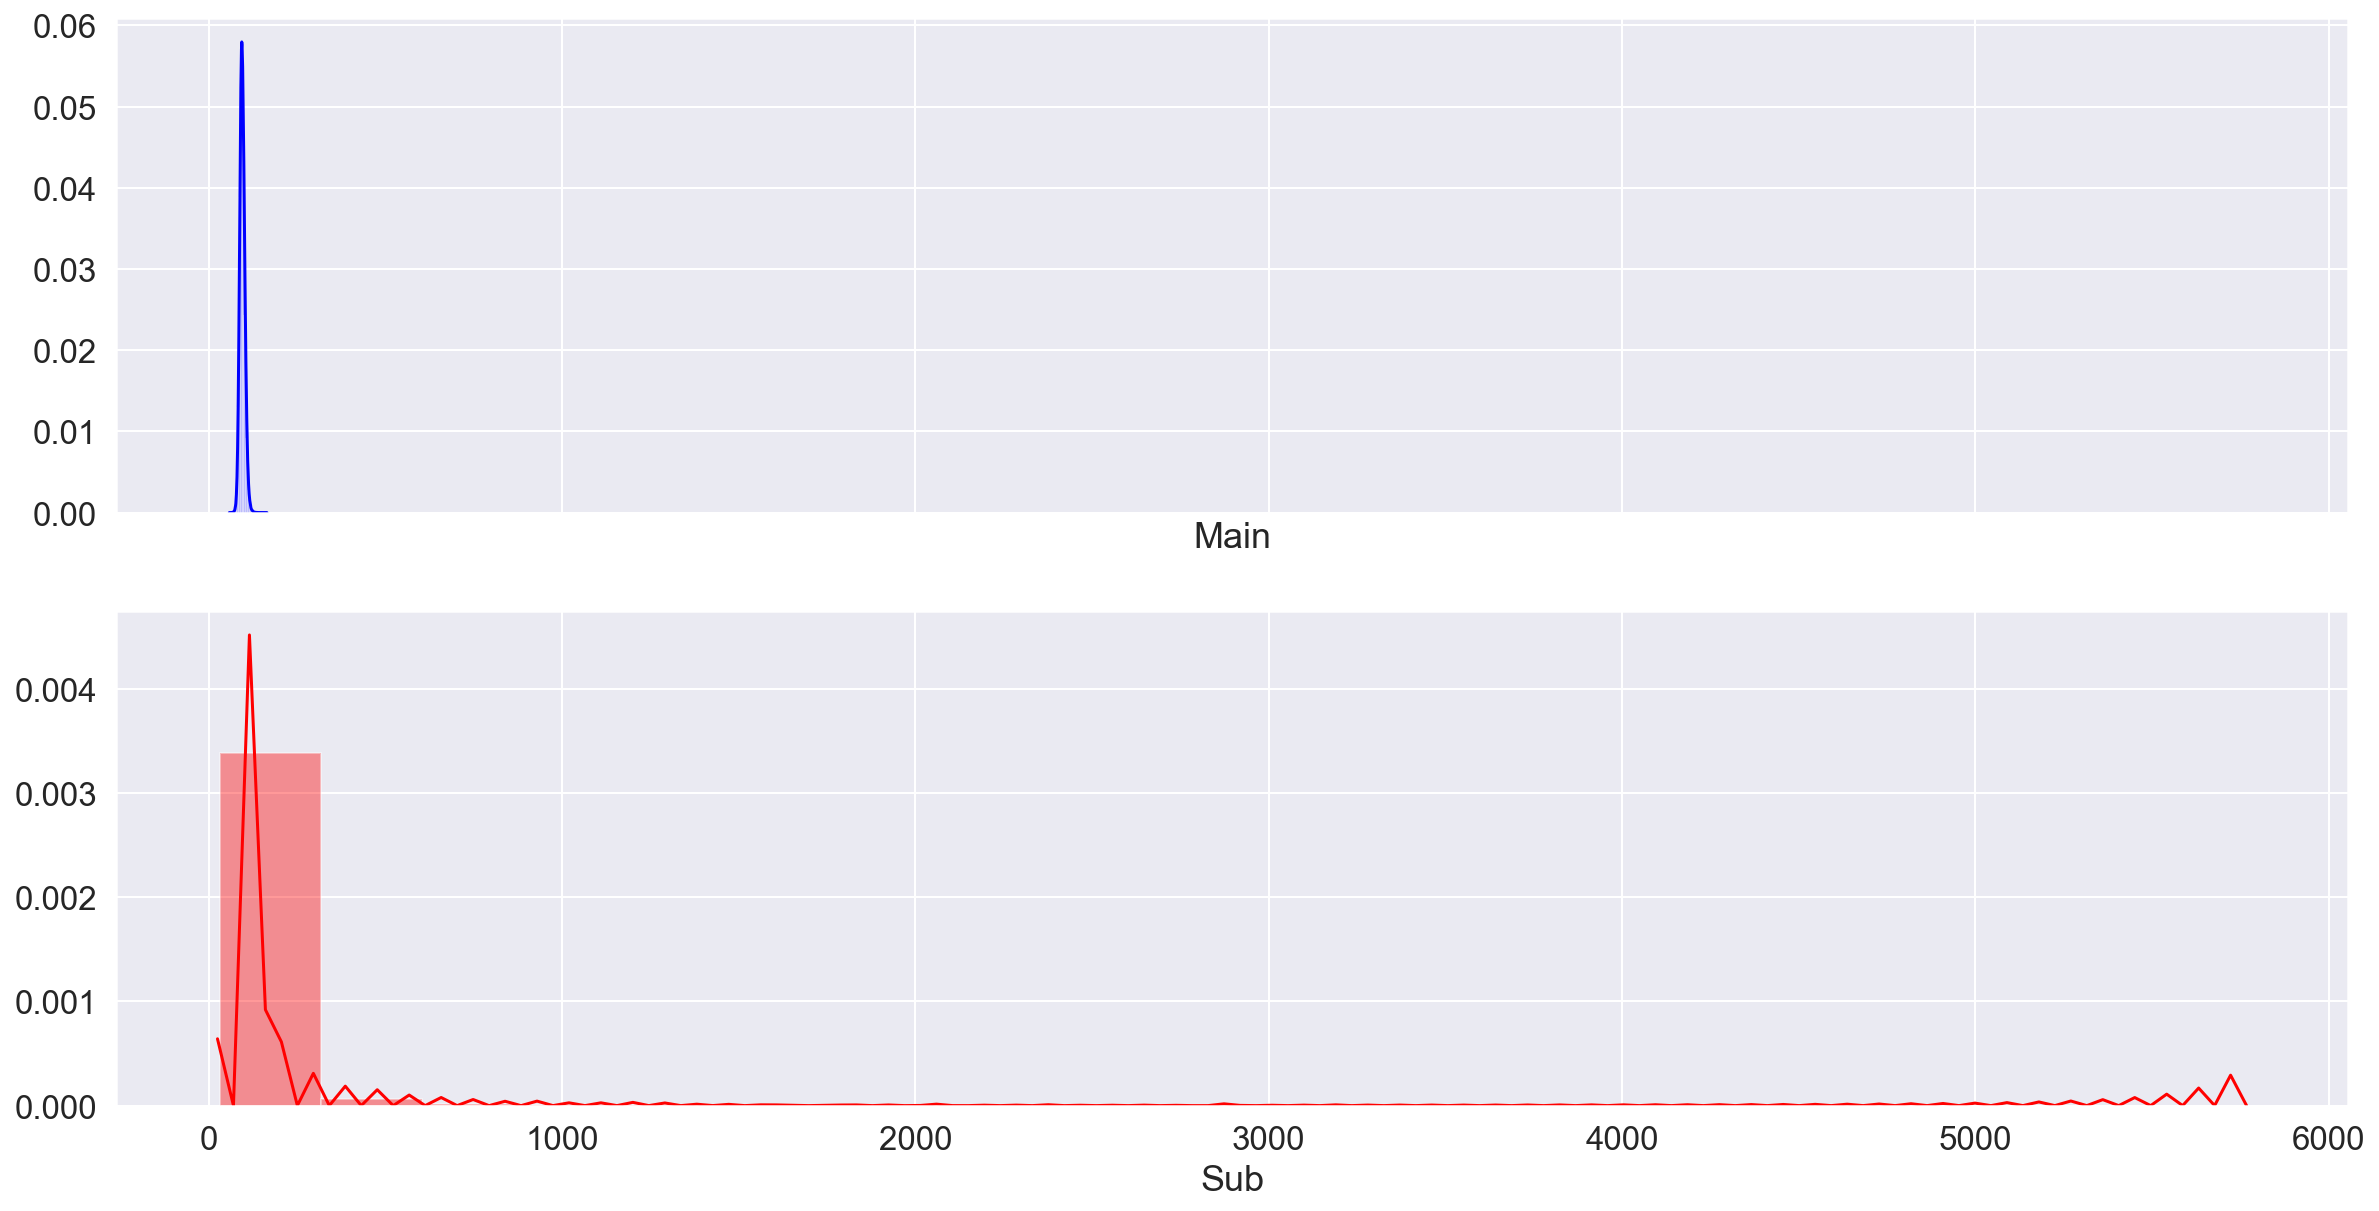

COLUMN : nba_pace_per40 
 Main min 50.15	 Sub min 26.85 
 Main max 136.28	 Sub max 4800.19


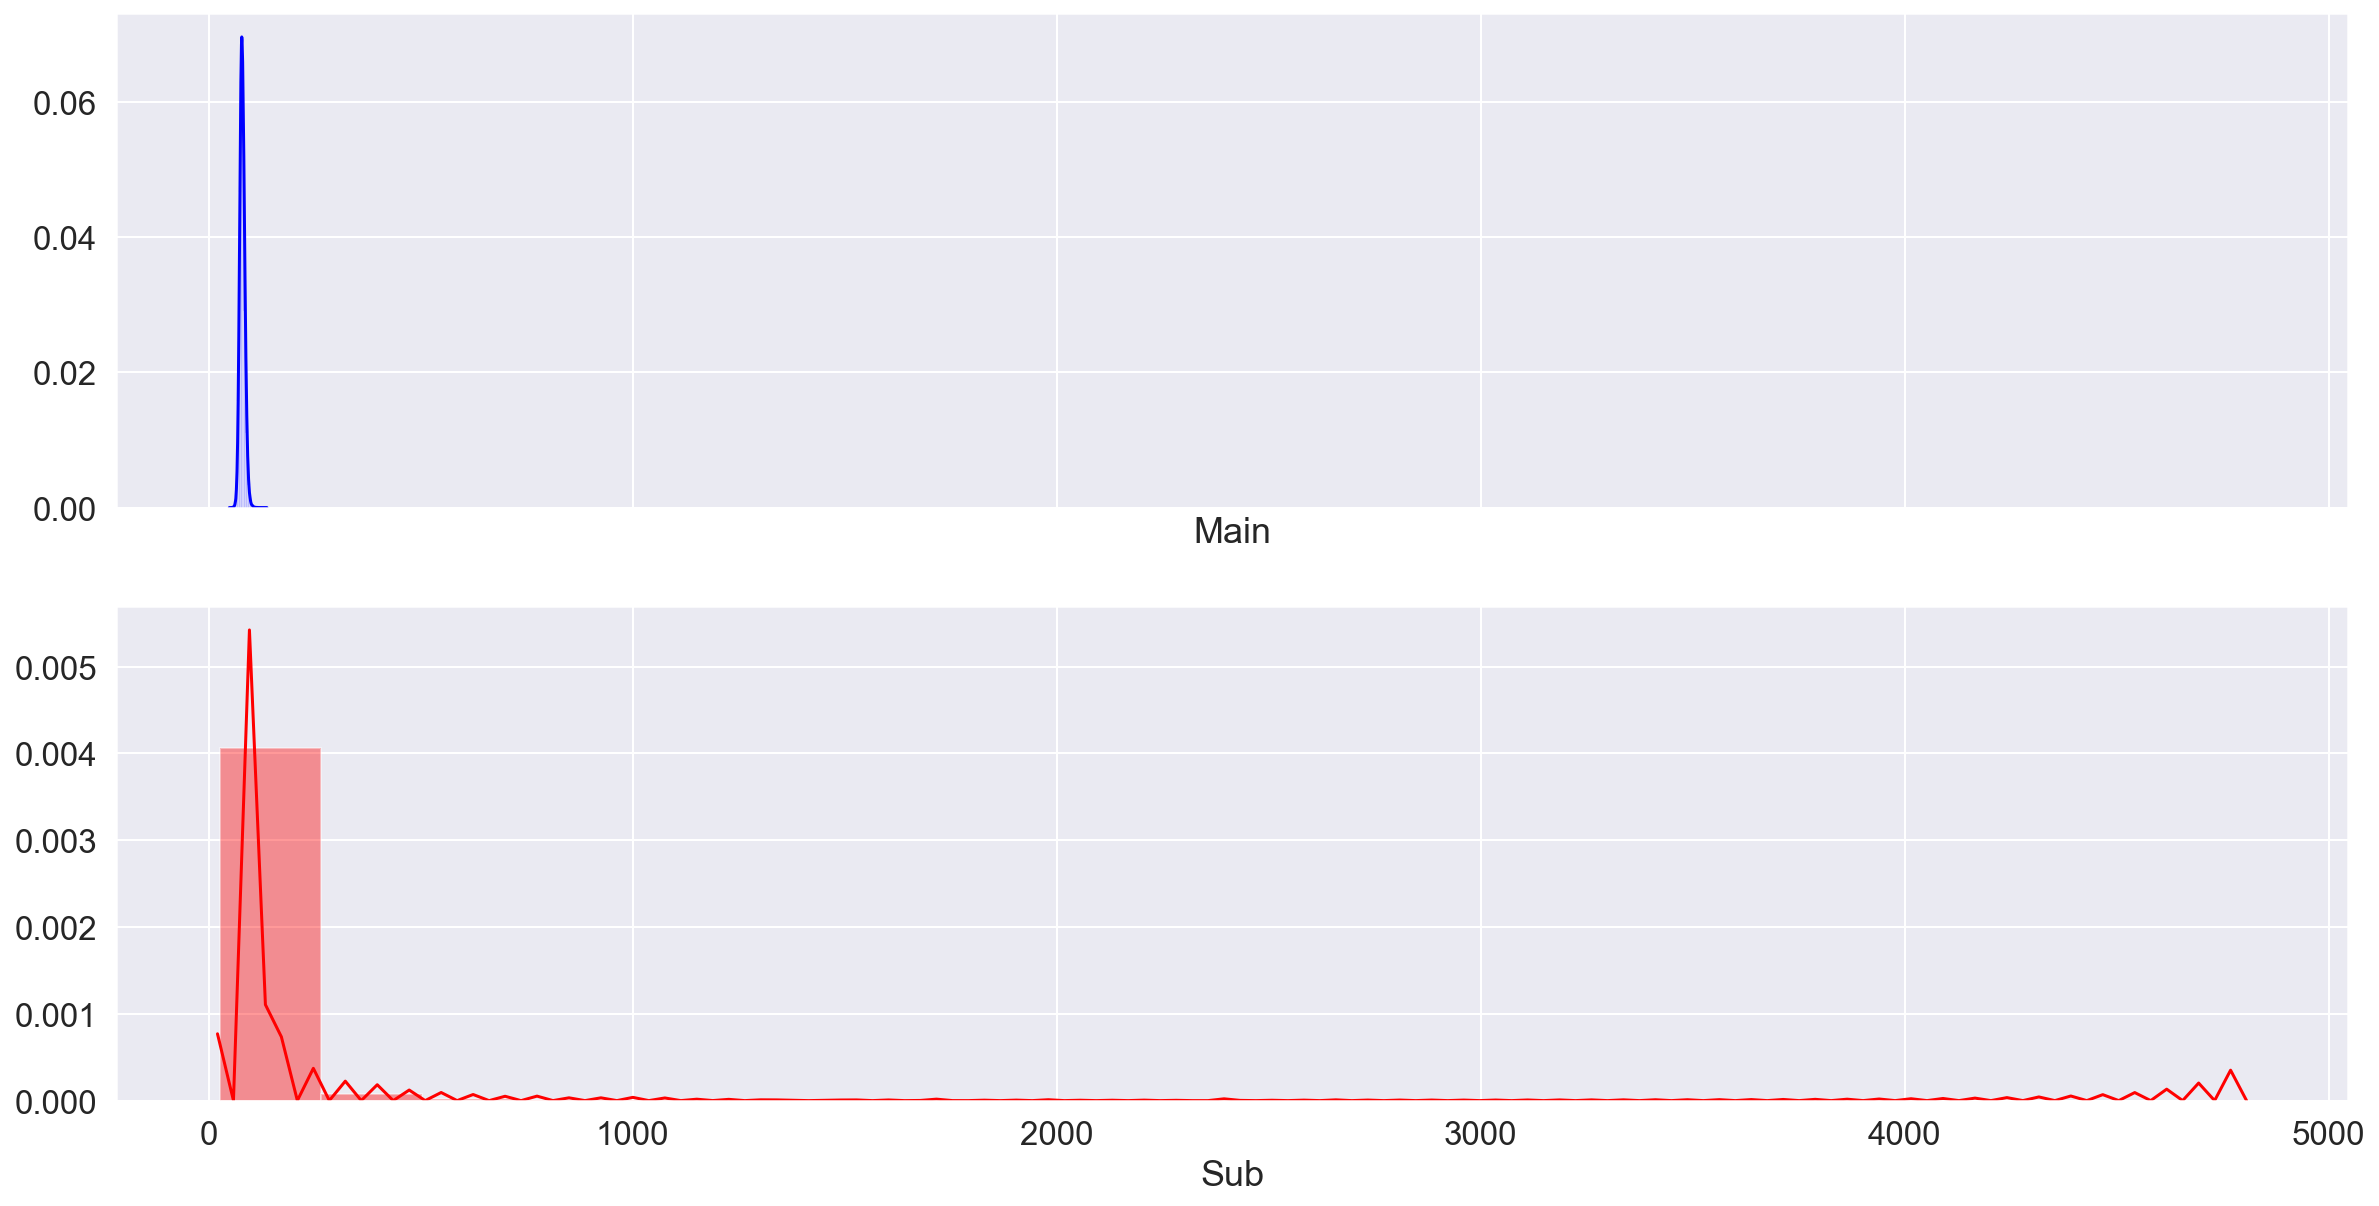

COLUMN : nba_poss 
 Main min 7.00	 Sub min 0.00 
 Main max 122.00	 Sub max 16.00


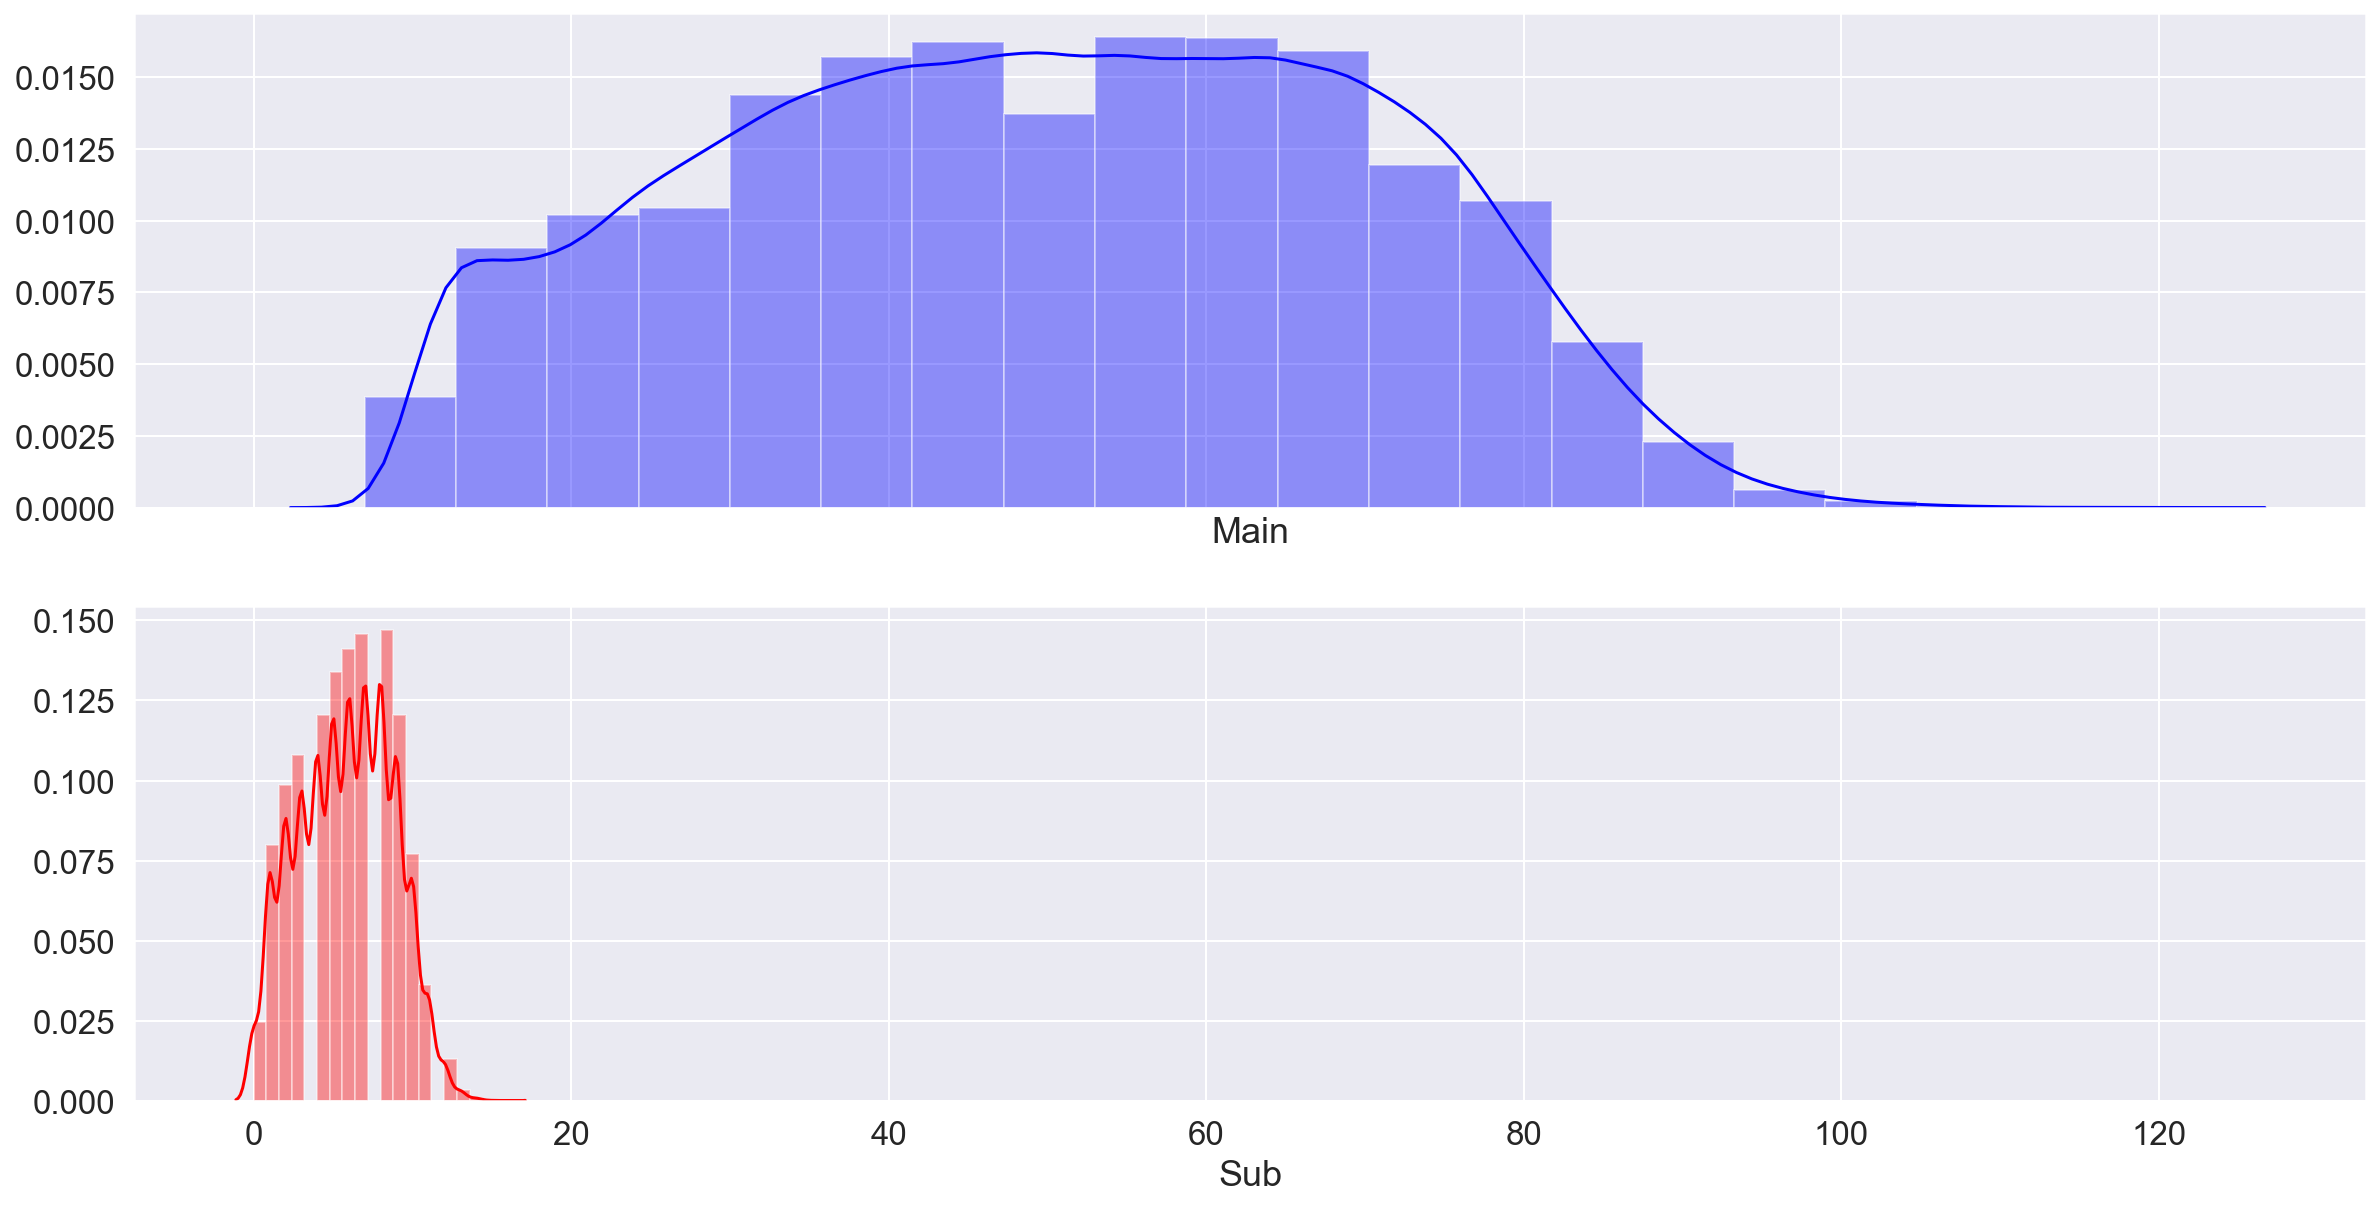

COLUMN : nba_pie 
 Main min -13.00	 Sub min -11.00 
 Main max 10.00	 Sub max 13.00


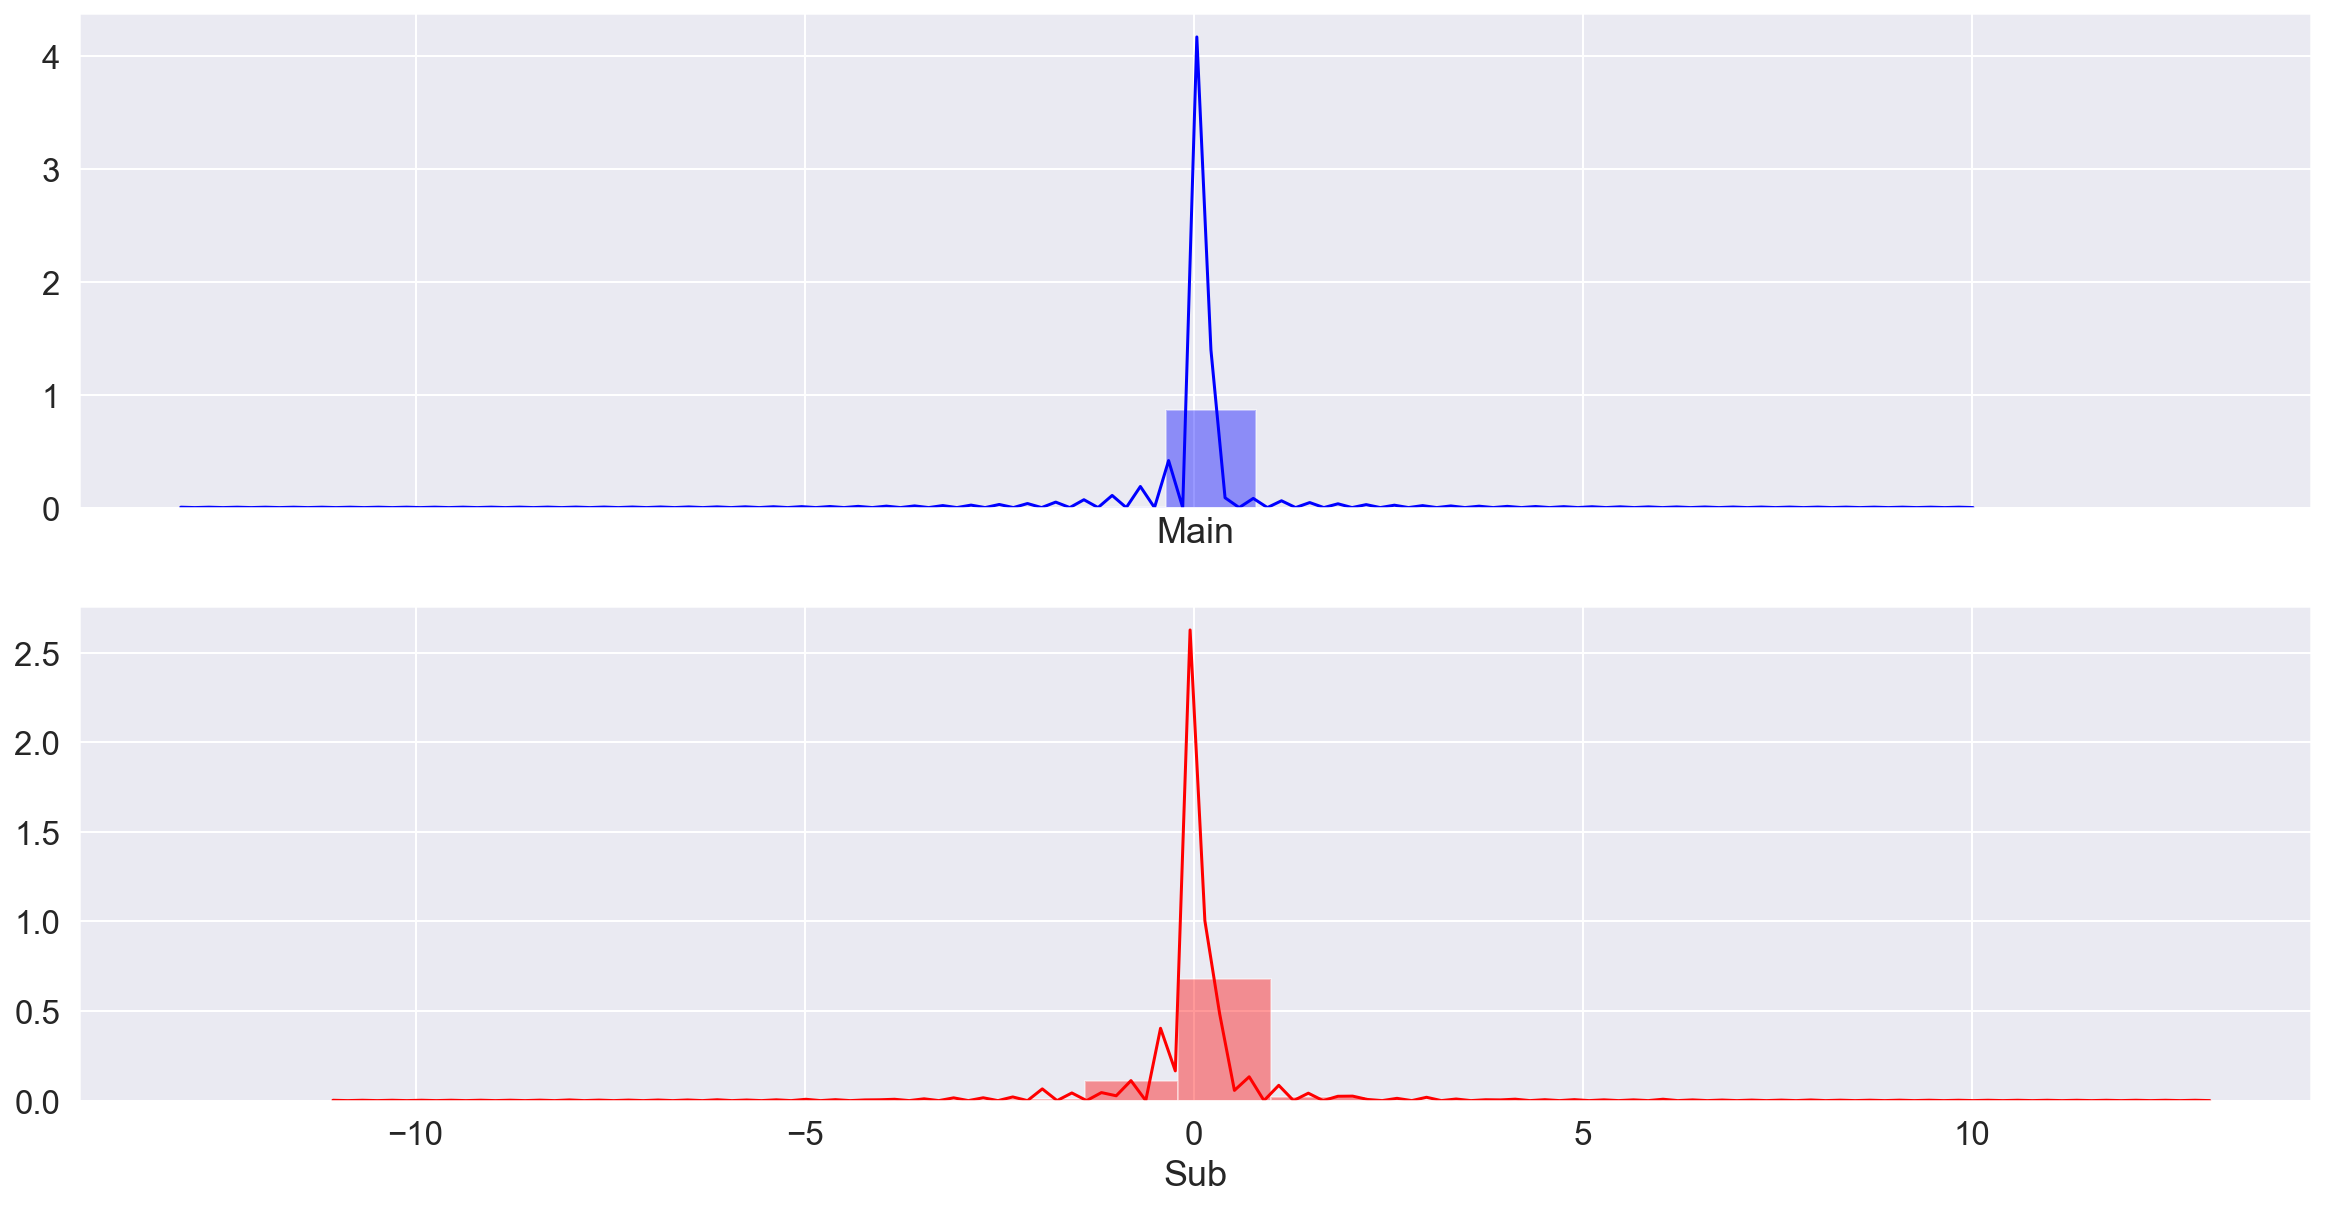

In [213]:
for col in xf.columns:
    if xf[col].dtype==float or xf[col].dtype==int:
        print('COLUMN :',col,'\n',
              f'Main min {mset[col].min():.2f}\t Sub min {sset[col].min():.2f}',
              '\n',
              f'Main max {mset[col].max():.2f}\t Sub max {sset[col].max():.2f}')
        fig , ax = plt.subplots(nrows=2, figsize=(20,10), sharex=True)
        ax[0] = sns.distplot(mset[col], ax=ax[0], axlabel='Main',
                        bins=20, norm_hist=False, color='blue',
                             label=f'{col}\t min {mset[col].min()}\t max{mset[col].max()}')
        ax[1] = sns.distplot(sset[col], ax=ax[1], axlabel='Sub',
                        bins=20, norm_hist=False, color='red',
                             label=f'{col}\t min {sset[col].min()}\t max{sset[col].max()}')#),
        plt.show()

### Removing player performances < 300 seconds
- Looking at the t-scores and distributions in variables (such as in pace metrics and off/def ratings) considering them as outliers and removed. 

In [204]:
mset.to_csv('mainset.csv')